In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

# Naming convention
The files containing the data from our experiments are nested in folders in the following hierarchy : <br><br>
`data_included/participant_##/technique/deprivation_duration/file.csv` <br>
where: <br>
- `##` represents the 2-digit participant number from `01` to `25`, <br>
- `technique` is either `combination` or `rivalry` and <br>
- `deprivation_duration` is either `15min` or `120min`.

The files names reflect all the information on the session they represent in this format :<br>
 `part_##_technique_deprivation-duration_session.csv` <br> 
for example: `part_01_combination_15min_baseline.csv` or `part_23_rivalry_120min_postpatch1.csv`

In [4]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
# import the functions from our dedicated file
import analysis_functions as anf
import config_paper.definitions as definitions
# also import the regular packages to manipulate the data here
import os
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter, MultipleLocator
from scipy.optimize import curve_fit
from scipy.stats import ttest_1samp, pearsonr, linregress, kendalltau, spearmanr, shapiro
from statsmodels.stats.multitest import multipletests
from statsmodels.graphics.agreement import mean_diff_plot
from sklearn.metrics import r2_score, auc
from progressbar import progressbar

rng = np.random.default_rng()

processed_data_dir = os.path.join(definitions.ROOT_DIR, "data_processed")
images_dir = os.path.join(definitions.ROOT_DIR, "images", "review")
os.makedirs(images_dir,exist_ok=True)

data_index = pd.MultiIndex.from_product((definitions.participant_list, definitions.deprivation_durations, definitions.sessions), names=["participant", "deprivation duration", "session"])

If you wish to change our functions, they are defined in the `analysis_functions.py` file.
If you do change them, run the following cell to apply the changes and run the analysis with your new functions.

BEWARE : eventhough parallelisation has been implemented, it takes quite long to analyze everything (~1h30 on M1 Macbook Pro).

In [5]:
# Decide whether to run the analysis (if you modified the analysis functions or want to reproduce our results locally)
run_analysis = True
participant_list = definitions.participant_list
deprivation_durations = definitions.deprivation_durations
sessions = definitions.sessions
postpatch_sessions = definitions.postpatch_sessions
postpatch_sessions_15, postpatch_sessions_120 = [s+"_15min" for s in postpatch_sessions], [s+"_120min" for s in postpatch_sessions]

if run_analysis:
    if False: # Binocular combination
        anf.analyze_binocular_combination_participants_list_parallel(participant_list, deprivation_durations, sessions)
    if True: # Binocular Rivalry
        anf.analyze_binocular_rivlary_participants_list_review(participant_list, deprivation_durations, sessions)


In [6]:
# Compute the MD effect
f_name_bc = ("all_participants_avg_parameters.csv")
model_parameters_bc = pd.read_csv(os.path.join(processed_data_dir, f_name_bc),header=[0,1],index_col=[0,1,2]).droplevel(1,axis=1)
model_parameters_bc.index = data_index

anf.compute_md_effect_bc(model_parameters_bc, participant_list, deprivation_durations, sessions)


# Load our analyzed data to look at it

## Load the data from BR and BC in two separate dataframes

In [7]:
# We load only the average parameters, but the raw parameters are available by replace 'avg' with 'all'
f_name_bc = ("balance_point_and_md_effect.csv")
combination_df = pd.read_csv(os.path.join(processed_data_dir, f_name_bc),index_col=[0,1,2])
combination_df.index = data_index

f_name_br = ("odi_and_md_effect_review.csv")
rivalry_df = pd.read_csv(os.path.join(processed_data_dir, f_name_br),index_col=[0,1,2])
rivalry_df.index = data_index

## Combine them and save the whole dataframe to disk

In [8]:
# We need the data in a form that will be compatible with the later tests
# We choose a form as such : each column represents a session, and the index is the participants
combination_effects_rearranged = pd.DataFrame(index=participant_list).rename_axis(index="participant")
rivalry_effects_rearranged = pd.DataFrame(index=participant_list).rename_axis(index="participant")

# We also make one for the raw values
combination_raw_rearranged = pd.DataFrame(index=participant_list).rename_axis(index="participant")
rivalry_raw_rearranged = pd.DataFrame(index=participant_list).rename_axis(index="participant")

for dur in deprivation_durations:
    combination_raw_rearranged[f"baseline_{dur}"] = combination_df.loc[(slice(None), dur, "baseline"), "eta"].to_numpy(dtype="float")
    rivalry_raw_rearranged[f"baseline_{dur}"] = rivalry_df.loc[(slice(None), dur, "baseline"), "ODI"].to_numpy(dtype="float")
    for session in postpatch_sessions:
        col_name = f"{session}_{dur}"
        combination_effects_rearranged[col_name] = combination_df.loc[(slice(None), dur, session), "MD_effect"].to_numpy(dtype="float")
        rivalry_effects_rearranged[col_name] = rivalry_df.loc[(slice(None), dur, session), "MD_effect"].to_numpy(dtype="float")

        # Make the same for raw values
        combination_raw_rearranged[col_name] = combination_df.loc[(slice(None), dur, session), "eta"].to_numpy(dtype="float")
        rivalry_raw_rearranged[col_name] = rivalry_df.loc[(slice(None), dur, session), "ODI"].to_numpy(dtype="float")

In [9]:
combination_save_df = combination_raw_rearranged.join(combination_effects_rearranged,lsuffix="_raw",rsuffix="_effect")
rivalry_save_df = rivalry_raw_rearranged.join(rivalry_effects_rearranged,lsuffix="_raw",rsuffix="_effect")

jasp_save_df = combination_save_df.join(rivalry_save_df,lsuffix="_combination",rsuffix="_rivalry")
save_name = "raw_values_and_effects_br_bc_review.csv"
jasp_save_df.to_csv(os.path.join(processed_data_dir, save_name))

In [10]:
# Some useful objects to clarify operations in the following steps
vertical_effects_df = {
    "15min":{
        "rivalry":rivalry_effects_rearranged[rivalry_effects_rearranged.columns[pd.Series(rivalry_effects_rearranged.columns).str.contains("_15min")]],
        "combination":combination_effects_rearranged[combination_effects_rearranged.columns[pd.Series(combination_effects_rearranged.columns).str.contains("_15min")]]
    },
    "120min":{
        "rivalry":rivalry_effects_rearranged[rivalry_effects_rearranged.columns[pd.Series(rivalry_effects_rearranged.columns).str.contains("_120min")]],
        "combination":combination_effects_rearranged[combination_effects_rearranged.columns[pd.Series(combination_effects_rearranged.columns).str.contains("_120min")]]
    }
}

vertical_raw_df = {
    "15min":{
        "rivalry":rivalry_raw_rearranged[rivalry_raw_rearranged.columns[pd.Series(rivalry_raw_rearranged.columns).str.contains("_15min")]],
        "combination":combination_raw_rearranged[combination_raw_rearranged.columns[pd.Series(combination_raw_rearranged.columns).str.contains("_15min")]]
    },
    "120min":{
        "rivalry":rivalry_raw_rearranged[rivalry_raw_rearranged.columns[pd.Series(rivalry_raw_rearranged.columns).str.contains("_120min")]],
        "combination":combination_raw_rearranged[combination_raw_rearranged.columns[pd.Series(combination_raw_rearranged.columns).str.contains("_120min")]]
    }
}

#### Reviewer's suggestion for effect vs effect

In [11]:
# Mean effect computation
arithmetic_mean_effect = {
    "15min":{
        "rivalry":None,
        "combination":None
    },
    "120min":{
        "rivalry":None,
        "combination":None
    }
}
arithmetic_mean_effect["15min"]["rivalry"] = np.log10(vertical_raw_df["15min"]["rivalry"][postpatch_sessions_15].mean(axis=1)) - np.log10(vertical_raw_df["15min"]["rivalry"]["baseline_15min"])
arithmetic_mean_effect["120min"]["rivalry"] = np.log10(vertical_raw_df["120min"]["rivalry"][postpatch_sessions_120].mean(axis=1)) - np.log10(vertical_raw_df["120min"]["rivalry"]["baseline_120min"])
arithmetic_mean_effect["15min"]["combination"] = np.log10(vertical_raw_df["15min"]["combination"][postpatch_sessions_15].mean(axis=1)) - np.log10(vertical_raw_df["15min"]["combination"]["baseline_15min"])
arithmetic_mean_effect["120min"]["combination"] = np.log10(vertical_raw_df["120min"]["combination"][postpatch_sessions_120].mean(axis=1)) - np.log10(vertical_raw_df["120min"]["combination"]["baseline_120min"])

In [12]:
mean_effect_values = {
    "15min":{
        "combination":combination_df.loc[(slice(None), "15min", slice(None)), "MD_effect"].groupby(level="session").mean().dropna(),
        "rivalry":rivalry_df.loc[(slice(None), "15min", slice(None)), "MD_effect"].groupby(level="session").mean().dropna()
    },
    "120min":{
        "combination":combination_df.loc[(slice(None), "120min", slice(None)), "MD_effect"].groupby(level="session").mean().dropna(),
        "rivalry":rivalry_df.loc[(slice(None), "120min", slice(None)), "MD_effect"].groupby(level="session").mean().dropna()
    }
}

sem_effect_values = {
    "15min":{
        "combination":combination_df.loc[(slice(None), "15min", slice(None)), "MD_effect"].groupby(level="session").sem().dropna(),
        "rivalry":rivalry_df.loc[(slice(None), "15min", slice(None)), "MD_effect"].groupby(level="session").sem().dropna()
    },
    "120min":{
        "combination":combination_df.loc[(slice(None), "120min", slice(None)), "MD_effect"].groupby(level="session").sem().dropna(),
        "rivalry":rivalry_df.loc[(slice(None), "120min", slice(None)), "MD_effect"].groupby(level="session").sem().dropna()
    }
}

### Linear fit on the data

In [13]:
# Plot and fit parameters

# The time vectors to plot and fit our curves
time_discrete = np.log10([4, 14, 30, 64, 94])
time_discrete_labels = [4, 14, 30, 64, 94] # Will be used for the plot labels
time_continuous = np.linspace(np.log10(4), np.log10(94), num=150)

# Plot colors
colors = {"combination":"blue", "rivalry":"red"}

marker_size = 25 #Size of the markers used for the data
error_bar_width = 3 #Linewidth of the error-bars stems
capsize = 6 #Size (length) of the error-bar caps
capthick = 3 #Thickness of the error-bars caps
empty_markers_thickness = 2 #Linewidth of the frame of the empty markers
fit_lines_width = 3 #Linewodth of the linear fit lines

spines_linewidth = 3

histogram_bars_linewidth = 2
# Plot kw_dicts
kw_dicts_results = {
    "15min":{
        "rivalry":dict(
                ls = "",
                color=colors["rivalry"],
                ecolor=colors["rivalry"],
                elinewidth=error_bar_width,
                capsize=capsize,
                capthick=capthick,
                marker="o",
                fillstyle="full", #15 minutes is filled disks
                mew = empty_markers_thickness, #mew : marker edge width
                ms = marker_size
            ),
        "combination":dict(
                ls = "",
                color=colors["combination"],
                ecolor=colors["combination"],
                elinewidth=error_bar_width,
                capsize=capsize,
                capthick=capthick,
                marker="o",
                fillstyle="full", #15 minutes is filled disks
                mew = empty_markers_thickness, #mew : marker edge width
                ms = marker_size
            )
        
    },
    "120min":{
        "rivalry":dict(
                ls = "",
                color=colors["rivalry"],
                ecolor=colors["rivalry"],
                elinewidth=error_bar_width,
                capsize=capsize,
                capthick=capthick,
                marker="o",
                fillstyle="none", #120 minutes is empty disks
                mew = empty_markers_thickness, #mew : marker edge width
                ms = marker_size
            ),
        "combination":dict(
                ls = "",
                color=colors["combination"],
                ecolor=colors["combination"],
                elinewidth=error_bar_width,
                capsize=capsize,
                capthick=capthick,
                marker="o",
                fillstyle="none", #120 minutes is empty disks
                mew = empty_markers_thickness, #mew : marker edge width
                ms = marker_size
            )
    }
}
kw_dicts_auc = {
    "15min":{
        "rivalry":dict(
                ls = "",
                color=colors["rivalry"],
                ecolor=colors["rivalry"],
                elinewidth=error_bar_width,
                capsize=capsize,
                capthick=capthick,
                marker="s",
                fillstyle="full", #15 minutes is filled disks
                mew = empty_markers_thickness, #mew : marker edge width
                ms = marker_size
            ),
        "combination":dict(
                ls = "",
                color=colors["combination"],
                ecolor=colors["combination"],
                elinewidth=error_bar_width,
                capsize=capsize,
                capthick=capthick,
                marker="s",
                fillstyle="full", #15 minutes is filled disks
                mew = empty_markers_thickness, #mew : marker edge width
                ms = marker_size
            )
        
    },
    "120min":{
        "rivalry":dict(
                ls = "",
                color=colors["rivalry"],
                ecolor=colors["rivalry"],
                elinewidth=error_bar_width,
                capsize=capsize,
                capthick=capthick,
                marker="s",
                fillstyle="none", #120 minutes is empty disks
                mew = empty_markers_thickness, #mew : marker edge width
                ms = marker_size
            ),
        "combination":dict(
                ls = "",
                color=colors["combination"],
                ecolor=colors["combination"],
                elinewidth=error_bar_width,
                capsize=capsize,
                capthick=capthick,
                marker="s",
                fillstyle="none", #120 minutes is empty disks
                mew = empty_markers_thickness, #mew : marker edge width
                ms = marker_size
            )
    }
}

# Significance marker
marker_size_one_star = 14
significance_markers ={
    0:dict(text="", style=dict()),
    1:dict(text=r"$\ast$", style=dict(linestyle='', color='0.8', markersize = marker_size_one_star, markerfacecolor="black", markeredgecolor="none")),
    2:dict(text=r"$\ast \ast$", style=dict(linestyle='', color='0.8', markersize = 2.3 * marker_size_one_star, markerfacecolor="black", markeredgecolor="none")),
    3:dict(text=r"$\ast \ast \ast$", style=dict(linestyle='', color='0.8', markersize = 4 * marker_size_one_star, markerfacecolor="black", markeredgecolor="none"))
}

vertical_offset_significance_markers = 0.007

In [14]:
linear_fit_parameters = {
    "15min":{
        "rivalry":None,
        "combination":None
    },
    "120min":{
        "rivalry":None,
        "combination":None
    }
}
linear_fit_parameters["15min"]["rivalry"], _ = curve_fit(
    anf.lin_fit_function, 
    time_discrete, 
    mean_effect_values["15min"]["rivalry"]
    )
linear_fit_parameters["120min"]["rivalry"], _ = curve_fit(
    anf.lin_fit_function, 
    time_discrete, 
    mean_effect_values["120min"]["rivalry"]
    )
linear_fit_parameters["15min"]["combination"], _ = curve_fit(
    anf.lin_fit_function, 
    time_discrete, 
    mean_effect_values["15min"]["combination"]
    )
linear_fit_parameters["120min"]["combination"], _ = curve_fit(
    anf.lin_fit_function, 
    time_discrete, 
    mean_effect_values["120min"]["combination"]
    )


# Goodness of fit
goodness_of_fit = {
    "15min":{
        "rivalry":r2_score(
            mean_effect_values["15min"]["rivalry"], 
            anf.lin_fit_function(time_discrete, *linear_fit_parameters["15min"]["rivalry"])
            ),
        "combination":r2_score(
            mean_effect_values["15min"]["combination"], 
            anf.lin_fit_function(time_discrete, *linear_fit_parameters["15min"]["combination"])
            )
    },
    "120min":{
        "rivalry":r2_score(
            mean_effect_values["120min"]["rivalry"], 
            anf.lin_fit_function(time_discrete, *linear_fit_parameters["120min"]["rivalry"])
            ),
        "combination":r2_score(
            mean_effect_values["120min"]["combination"], 
            anf.lin_fit_function(time_discrete, *linear_fit_parameters["120min"]["combination"])
            )
    }
}

### One sample t-test vs 0, Bonferroni correction

In [15]:
zeros = [0, 0, 0, 0, 0]
ttests_bonferroni = {
    "15min":{
        "rivalry":{},
        "combination":{}
    },
    "120min":{
        "rivalry":{},
        "combination":{}
    }
}
# Compute the t-test against 0 for each condition
ttests_bonferroni["15min"]["combination"]["t-value"], ttests_bonferroni["15min"]["combination"]["p-value raw"] = ttest_1samp(vertical_effects_df["15min"]["combination"], zeros)
ttests_bonferroni["120min"]["combination"]["t-value"], ttests_bonferroni["120min"]["combination"]["p-value raw"] = ttest_1samp(vertical_effects_df["120min"]["combination"], zeros)
ttests_bonferroni["15min"]["rivalry"]["t-value"], ttests_bonferroni["15min"]["rivalry"]["p-value raw"] = ttest_1samp(vertical_effects_df["15min"]["rivalry"], zeros)
ttests_bonferroni["120min"]["rivalry"]["t-value"], ttests_bonferroni["120min"]["rivalry"]["p-value raw"] = ttest_1samp(vertical_effects_df["120min"]["rivalry"], zeros)

# Apply the bonferroni correction for multiple comparisons
ttests_bonferroni["15min"]["combination"]["significant after correction"], ttests_bonferroni["15min"]["combination"]["p-value adjusted"], _, _ = multipletests(ttests_bonferroni["15min"]["combination"]["p-value raw"], 0.05, "bonferroni")
ttests_bonferroni["120min"]["combination"]["significant after correction"], ttests_bonferroni["120min"]["combination"]["p-value adjusted"], _, _ = multipletests(ttests_bonferroni["120min"]["combination"]["p-value raw"], 0.05, "bonferroni")
ttests_bonferroni["15min"]["rivalry"]["significant after correction"], ttests_bonferroni["15min"]["rivalry"]["p-value adjusted"], _, _ = multipletests(ttests_bonferroni["15min"]["rivalry"]["p-value raw"], 0.05, "bonferroni")
ttests_bonferroni["120min"]["rivalry"]["significant after correction"], ttests_bonferroni["120min"]["rivalry"]["p-value adjusted"], _, _ = multipletests(ttests_bonferroni["120min"]["rivalry"]["p-value raw"], 0.05, "bonferroni")

# Store the significance level for each session, for plotting purposes
ttests_bonferroni["15min"]["combination"]["significance level"] = [anf.significance_level(p) for p in ttests_bonferroni["15min"]["combination"]["p-value adjusted"]]
ttests_bonferroni["120min"]["combination"]["significance level"] = [anf.significance_level(p) for p in ttests_bonferroni["120min"]["combination"]["p-value adjusted"]]
ttests_bonferroni["15min"]["rivalry"]["significance level"] = [anf.significance_level(p) for p in ttests_bonferroni["15min"]["rivalry"]["p-value adjusted"]]
ttests_bonferroni["120min"]["rivalry"]["significance level"] = [anf.significance_level(p) for p in ttests_bonferroni["120min"]["rivalry"]["p-value adjusted"]]

In [16]:
print(np.array2string(ttests_bonferroni["120min"]["rivalry"]["p-value adjusted"], precision=6, suppress_small=True))

[0.000001 0.000001 0.000037 0.000945 0.000671]


In [17]:
print("comb 15: ", ttests_bonferroni["15min"]["combination"]["t-value"], ttests_bonferroni["15min"]["combination"]["p-value adjusted"], anf.cohend(vertical_effects_df["15min"]["combination"], zeros).values)
print("riv 15: ", ttests_bonferroni["15min"]["rivalry"]["t-value"], ttests_bonferroni["15min"]["rivalry"]["p-value adjusted"], anf.cohend(vertical_effects_df["15min"]["rivalry"], zeros).values)
print("comb 120: ", ttests_bonferroni["120min"]["combination"]["t-value"], ttests_bonferroni["120min"]["combination"]["p-value adjusted"], anf.cohend(vertical_effects_df["120min"]["combination"], zeros).values)
print("riv 120: ", ttests_bonferroni["120min"]["rivalry"]["t-value"], ttests_bonferroni["120min"]["rivalry"]["p-value adjusted"], anf.cohend(vertical_effects_df["120min"]["rivalry"], zeros).values)

comb 15:  [4.14023262 3.10502198 2.98585885 1.25679456 1.00510213] [0.00184737 0.02414484 0.03208813 1.         1.        ] [0.89439247 0.67076141 0.64501923 0.27149866 0.21712688]
riv 15:  [3.97759585 2.54401281 1.44638688 0.44435271 1.37534693] [0.00278794 0.08906898 0.8050167  1.         0.90863393] [0.85925891 0.54956958 0.31245528 0.09599116 0.29710889]
comb 120:  [9.74899879 8.3143738  8.17305799 6.25962638 3.99022582] [4.02842524e-09 7.92299016e-08 1.07816348e-07 9.02907301e-06
 2.70040838e-03] [2.10602444 1.79611002 1.76558232 1.35223385 0.8619873 ]
riv 120:  [7.04051287 7.18426034 5.69089111 4.40417113 4.53853917] [1.40109020e-06 1.00245431e-06 3.66007424e-05 9.44976540e-04
 6.71375715e-04] [1.52092461 1.55197761 1.22937299 0.9514097  0.98043652]


In [18]:
riv_15_stats = pd.DataFrame(index = postpatch_sessions)
riv_15_stats["t-value"] = ttests_bonferroni["15min"]["rivalry"]["t-value"]
riv_15_stats["p-value adjusted"] = ttests_bonferroni["15min"]["rivalry"]["p-value adjusted"]
riv_15_stats["Cohen's d"] = anf.cohend(vertical_effects_df["15min"]["rivalry"], zeros).values

riv_120_stats = pd.DataFrame(index = postpatch_sessions)
riv_120_stats["t-value"] = ttests_bonferroni["120min"]["rivalry"]["t-value"]
riv_120_stats["p-value adjusted"] = ttests_bonferroni["120min"]["rivalry"]["p-value adjusted"]
riv_120_stats["Cohen's d"] = anf.cohend(vertical_effects_df["120min"]["rivalry"], zeros).values

comb_15_stats = pd.DataFrame(index = postpatch_sessions)
comb_15_stats["t-value"] = ttests_bonferroni["15min"]["combination"]["t-value"]
comb_15_stats["p-value adjusted"] = ttests_bonferroni["15min"]["combination"]["p-value adjusted"]
comb_15_stats["Cohen's d"] = anf.cohend(vertical_effects_df["15min"]["combination"], zeros).values

comb_120_stats = pd.DataFrame(index = postpatch_sessions)
comb_120_stats["t-value"] = ttests_bonferroni["120min"]["combination"]["t-value"]
comb_120_stats["p-value adjusted"] = ttests_bonferroni["120min"]["combination"]["p-value adjusted"]
comb_120_stats["Cohen's d"] = anf.cohend(vertical_effects_df["120min"]["combination"], zeros).values


print("riv 15:\n",riv_15_stats)
print("riv 120:\n",riv_120_stats)
print("comb 15:\n",comb_15_stats)
print("comb 120:\n",comb_120_stats)

riv 15:
              t-value  p-value adjusted  Cohen's d
postpatch1  3.977596          0.002788   0.859259
postpatch2  2.544013          0.089069   0.549570
postpatch3  1.446387          0.805017   0.312455
postpatch4  0.444353          1.000000   0.095991
postpatch5  1.375347          0.908634   0.297109
riv 120:
              t-value  p-value adjusted  Cohen's d
postpatch1  7.040513          0.000001   1.520925
postpatch2  7.184260          0.000001   1.551978
postpatch3  5.690891          0.000037   1.229373
postpatch4  4.404171          0.000945   0.951410
postpatch5  4.538539          0.000671   0.980437
comb 15:
              t-value  p-value adjusted  Cohen's d
postpatch1  4.140233          0.001847   0.894392
postpatch2  3.105022          0.024145   0.670761
postpatch3  2.985859          0.032088   0.645019
postpatch4  1.256795          1.000000   0.271499
postpatch5  1.005102          1.000000   0.217127
comb 120:
              t-value  p-value adjusted  Cohen's d
postpatch1

## Plot the results !

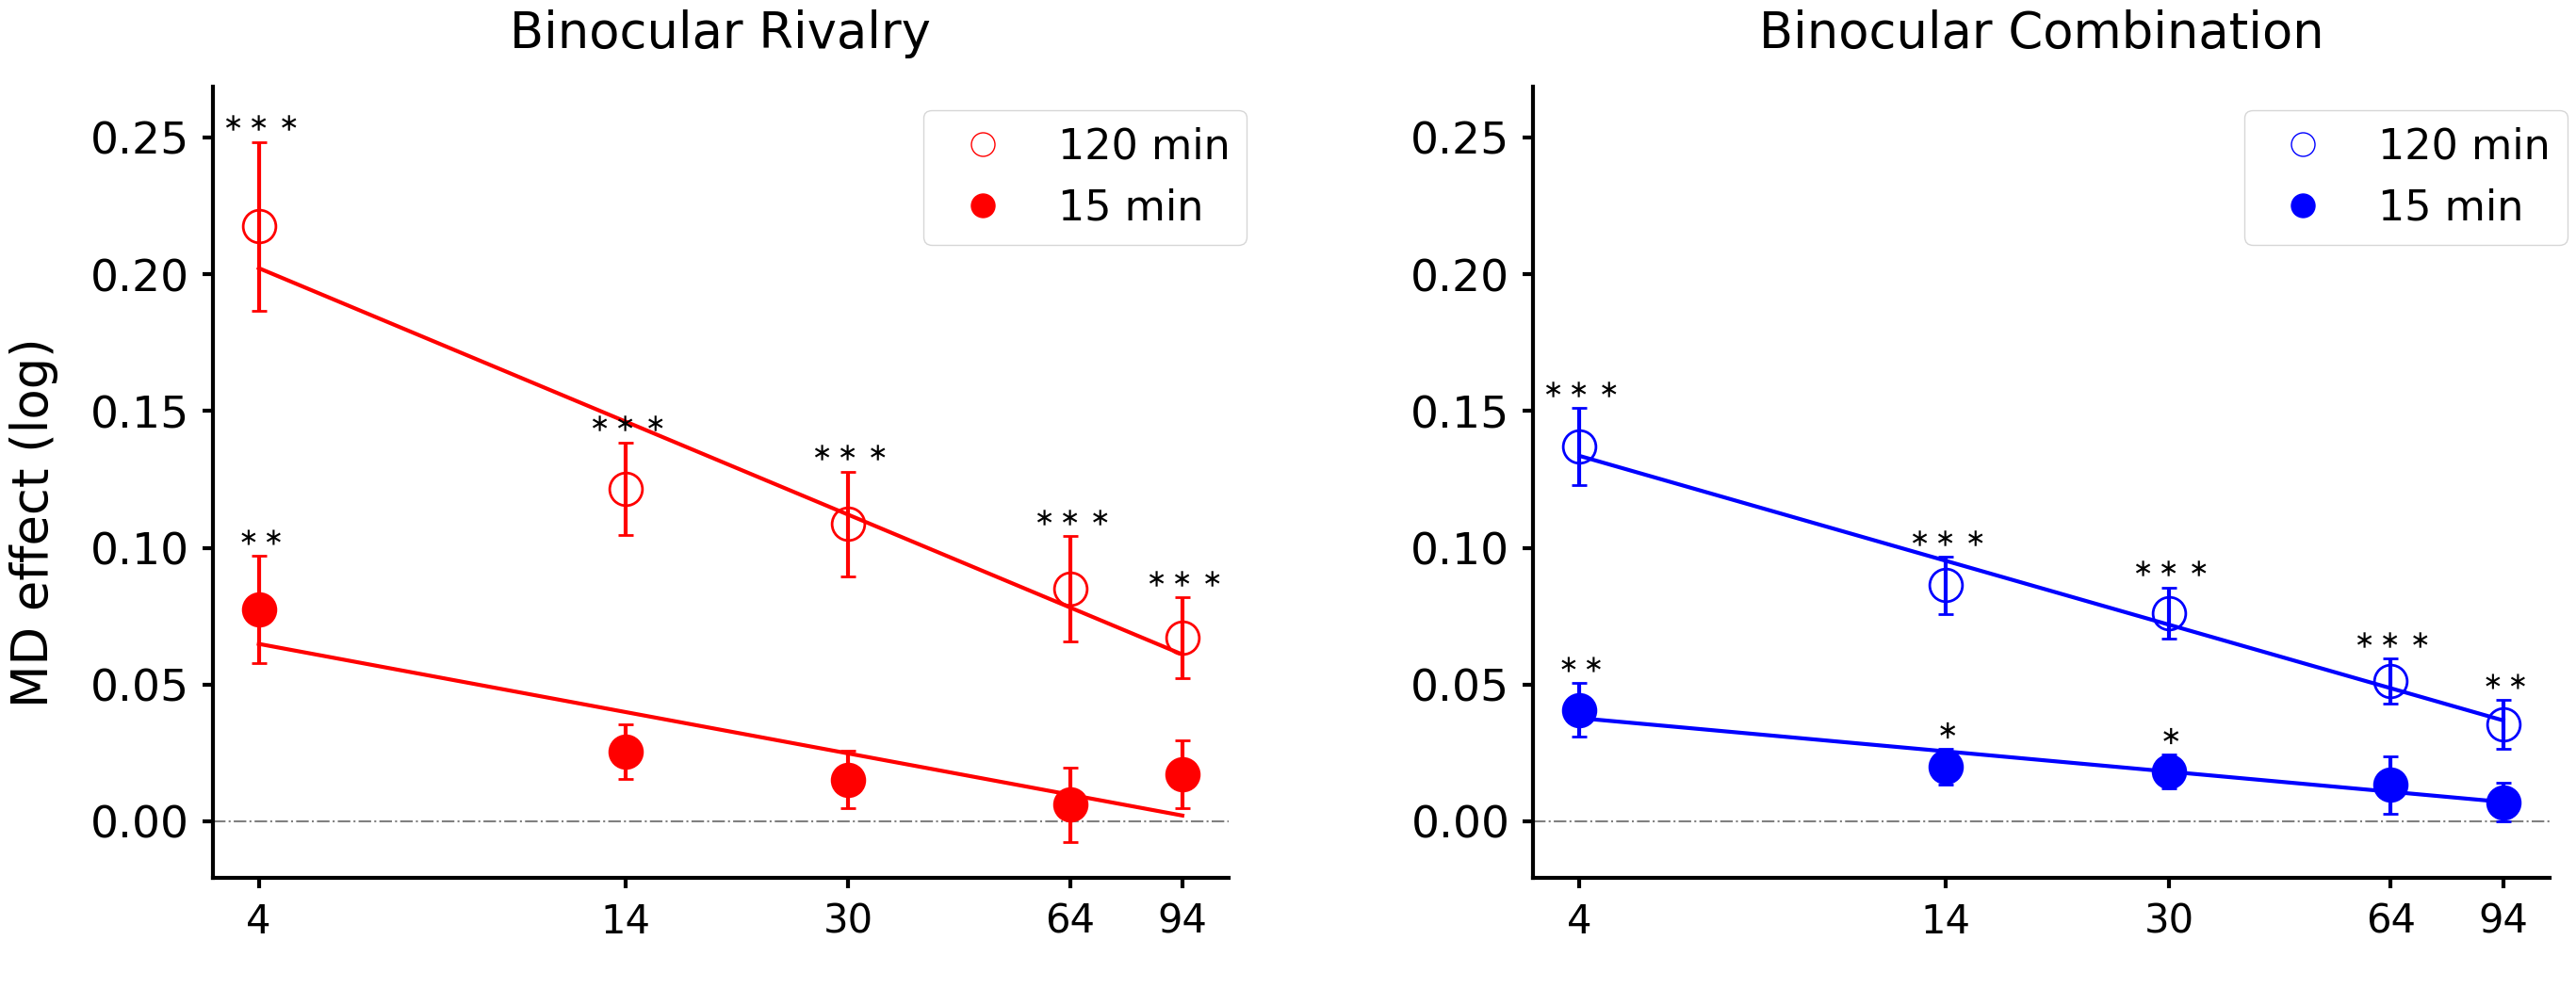

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(32, 12), gridspec_kw=dict(wspace=0.3, bottom=0.18))

# Make one large ax to show joint info
ax_global = fig.add_subplot(111, frameon=False)
ax_global.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
ax_global.set_ylabel("MD effect (log)", fontsize = 38, labelpad=95)

# Now the actual plot axes
ax_rivalry, ax_combination = axes[0], axes[1]

# Set the axes formatting
ax_rivalry.set_title("Binocular Rivalry", fontsize=38, pad=30), ax_combination.set_title("Binocular Combination", fontsize=38, pad=30)
ax_combination.sharex(ax_rivalry), ax_combination.sharey(ax_rivalry)
ax_rivalry.set_xticks(time_discrete), ax_rivalry.set_yticks([0, 0.05, 0.10, 0.15, 0.20, 0.25])
for ax in axes:
    ax.set_xticklabels([str(i) for i in time_discrete_labels], fontsize=30)
    ax.set_yticklabels([str(i) for i in [0.00, 0.05, 0.10, 0.15, 0.20, 0.25]], fontsize=34)
    ax.yaxis.set_major_formatter(StrMethodFormatter("{x:,.2f}"))
    ax.spines[["top", "right"]].set_visible(False)
    ax.spines[["bottom", "left"]].set_linewidth(3)
    ax.tick_params(length=8, width=3, pad=10)
    ax.axhline(0, ls='-.', color="grey")

# Create the legends
legend_handles = {
    "rivalry":[
        mpl.lines.Line2D([0], [0], marker="o", color=colors["rivalry"], fillstyle="none", ms=18, linestyle=''),
        mpl.lines.Line2D([0], [0], marker="o", color=colors["rivalry"], ms=18, linestyle=''),
    ],
    "combination" : [
        mpl.lines.Line2D([0], [0], marker="o", color=colors["combination"], fillstyle="none", ms=18, linestyle=''),
        mpl.lines.Line2D([0], [0], marker="o", color=colors["combination"], ms=18, linestyle=''),
    ]
}
legend_labels = ["120 min", "15 min"]

# plot the results
ax_rivalry.errorbar(time_discrete,
    mean_effect_values["15min"]["rivalry"],
    sem_effect_values["15min"]["rivalry"],
    **kw_dicts_results["15min"]["rivalry"]
)
ax_rivalry.errorbar(time_discrete,
    mean_effect_values["120min"]["rivalry"],
    sem_effect_values["120min"]["rivalry"],
    **kw_dicts_results["120min"]["rivalry"]
)
ax_combination.errorbar(time_discrete,
    mean_effect_values["15min"]["combination"],
    sem_effect_values["15min"]["combination"],
    **kw_dicts_results["15min"]["combination"]
)
ax_combination.errorbar(time_discrete,
    mean_effect_values["120min"]["combination"],
    sem_effect_values["120min"]["combination"],
    **kw_dicts_results["120min"]["combination"]
)

# Fitted lines
ax_combination.plot(
    time_continuous, 
    anf.lin_fit_function(time_continuous, *linear_fit_parameters["120min"]["combination"]),
    color = colors["combination"],
    lw = fit_lines_width
    )

ax_combination.plot(
    time_continuous, 
    anf.lin_fit_function(time_continuous, *linear_fit_parameters["15min"]["combination"]),
    color = colors["combination"],
    lw = fit_lines_width
    )

ax_rivalry.plot(
    time_continuous, 
    anf.lin_fit_function(time_continuous, *linear_fit_parameters["120min"]["rivalry"]),
    color = colors["rivalry"],
    lw = fit_lines_width
    )

ax_rivalry.plot(
    time_continuous, 
    anf.lin_fit_function(time_continuous, *linear_fit_parameters["15min"]["rivalry"]),
    color = colors["rivalry"],
    lw = fit_lines_width
    )

# Significnace markers
for i in range(len(time_discrete)):
    ax_combination.plot(
        time_discrete[i],
        anf.sig_marker_position_results_graph(
            mean_effect_values["15min"]["combination"].iloc[i], 
            sem_effect_values["15min"]["combination"].iloc[i]),
        marker=significance_markers[ttests_bonferroni["15min"]["combination"]["significance level"][i]]["text"],
        **significance_markers[ttests_bonferroni["15min"]["combination"]["significance level"][i]]["style"]
    )
    ax_combination.plot(
        time_discrete[i],
        anf.sig_marker_position_results_graph(
            mean_effect_values["120min"]["combination"].iloc[i], 
            sem_effect_values["120min"]["combination"].iloc[i]),
        marker=significance_markers[ttests_bonferroni["120min"]["combination"]["significance level"][i]]["text"],
        **significance_markers[ttests_bonferroni["120min"]["combination"]["significance level"][i]]["style"]
    )
    ax_rivalry.plot(
        time_discrete[i],
        anf.sig_marker_position_results_graph(
            mean_effect_values["15min"]["rivalry"].iloc[i], 
            sem_effect_values["15min"]["rivalry"].iloc[i]),
        marker=significance_markers[ttests_bonferroni["15min"]["rivalry"]["significance level"][i]]["text"],
        **significance_markers[ttests_bonferroni["15min"]["rivalry"]["significance level"][i]]["style"]
    )
    ax_rivalry.plot(
        time_discrete[i],
        anf.sig_marker_position_results_graph(
            mean_effect_values["120min"]["rivalry"].iloc[i], 
            sem_effect_values["120min"]["rivalry"].iloc[i]),
        marker=significance_markers[ttests_bonferroni["120min"]["rivalry"]["significance level"][i]]["text"],
        **significance_markers[ttests_bonferroni["120min"]["rivalry"]["significance level"][i]]["style"]
    )

ax_combination.legend(legend_handles["combination"], legend_labels, loc=(.7, .8), fontsize=32), ax_rivalry.legend(legend_handles["rivalry"], legend_labels, loc=(.7, .8), fontsize=32)
plt.show()

fig.savefig(os.path.join(images_dir, "effect_vs_time_br_bc_review.png"))

In [20]:
mean_effect_values["15min"]["combination"]

session
postpatch1    0.040765
postpatch2    0.020045
postpatch3    0.018334
postpatch4    0.013288
postpatch5    0.007079
Name: MD_effect, dtype: float64

## Area under the curve

In [21]:
bootstrap_dict = {
        depr:{
            meth:{
                "resample_vect":pd.DataFrame(index=participant_list, columns=postpatch_sessions),
                "AUC_results":{"values":[], "error_bars":None, "mean":None}
            } for meth in ["rivalry", "combination"]
        } for depr in deprivation_durations
    }

for i in participant_list:
    rdm_idx = rng.integers(0,len(participant_list))
    for depr in deprivation_durations:
        for method in ["rivalry", "combination"]:
            bootstrap_dict[depr][method]["resample_vect"].loc[i] = vertical_effects_df[depr][method].iloc[rdm_idx].values

In [22]:
if True:
    bootstrap_dict = {
        depr:{
            meth:{
                "resample_vect":pd.DataFrame(index=participant_list, columns=postpatch_sessions),
                "AUC_results":{"values":[], "error_bars":None, "mean":None}
            } for meth in ["rivalry", "combination"]
        } for depr in deprivation_durations
    }

    for n in progressbar(range(10000)):
        for i in participant_list:
            rdm_idx = rng.integers(0,len(participant_list))
            for depr in deprivation_durations:
                for method in ["rivalry", "combination"]:
                    bootstrap_dict[depr][method]["resample_vect"].loc[i] = vertical_effects_df[depr][method].iloc[rdm_idx].values
        
        for depr in deprivation_durations:
            for method in ["rivalry", "combination"]:
                popt, _ = curve_fit(anf.lin_fit_function, time_discrete, bootstrap_dict[depr][method]["resample_vect"].mean())
                bootstrap_dict[depr][method]["AUC_results"]["values"].append(auc(time_continuous, anf.lin_fit_function(time_continuous, *popt)))
    
    for depr in deprivation_durations:
        for method in ["rivalry", "combination"]:
            bootstrap_dict[depr][method]["AUC_results"]["mean"] = np.mean(bootstrap_dict[depr][method]["AUC_results"]["values"])
            bootstrap_dict[depr][method]["AUC_results"]["error_bars"] = np.std(bootstrap_dict[depr][method]["AUC_results"]["values"])


  0% (0 of 10000) |                      | Elapsed Time: 0:00:00 ETA:  --:--:--
  0% (21 of 10000) |                     | Elapsed Time: 0:00:00 ETA:   0:00:47
  0% (43 of 10000) |                     | Elapsed Time: 0:00:00 ETA:   0:00:46
  0% (65 of 10000) |                     | Elapsed Time: 0:00:00 ETA:   0:00:46
  0% (86 of 10000) |                     | Elapsed Time: 0:00:00 ETA:   0:00:46
  1% (107 of 10000) |                    | Elapsed Time: 0:00:00 ETA:   0:00:46
  1% (127 of 10000) |                    | Elapsed Time: 0:00:00 ETA:   0:00:46
  1% (149 of 10000) |                    | Elapsed Time: 0:00:00 ETA:   0:00:46
  1% (170 of 10000) |                    | Elapsed Time: 0:00:00 ETA:   0:00:46
  1% (192 of 10000) |                    | Elapsed Time: 0:00:00 ETA:   0:00:46
  2% (214 of 10000) |                    | Elapsed Time: 0:00:01 ETA:   0:00:46
  2% (236 of 10000) |                    | Elapsed Time: 0:00:01 ETA:   0:00:45
  2% (254 of 10000) |                   

In [23]:
# Sign test between the distributions : t-test of (120min - 15min) vs 0
riv_bootstrap_diff = pd.Series(bootstrap_dict["120min"]["rivalry"]["AUC_results"]["values"]) - pd.Series(bootstrap_dict["15min"]["rivalry"]["AUC_results"]["values"])
comb_bootstrap_diff = pd.Series(bootstrap_dict["120min"]["combination"]["AUC_results"]["values"]) - pd.Series(bootstrap_dict["15min"]["combination"]["AUC_results"]["values"])
print(f"Rivalry bootstrap sign test : {ttest_1samp(riv_bootstrap_diff, 0)}")
print(f"Combination bootstrap sign test : {ttest_1samp(comb_bootstrap_diff, 0)}")

Rivalry bootstrap sign test : TtestResult(statistic=608.247487436798, pvalue=0.0, df=9999)
Combination bootstrap sign test : TtestResult(statistic=744.7821940123634, pvalue=0.0, df=9999)


Riv 15 : 0.04606013622342391 +- 0.01591313894803439
Riv 120 : 0.180528045102329 +- 0.02490078314737744
Comb 15 : 0.030771290955883972 +- 0.007422528969686982
Comb 120 : 0.11699429430551872 +- 0.01210136561607732


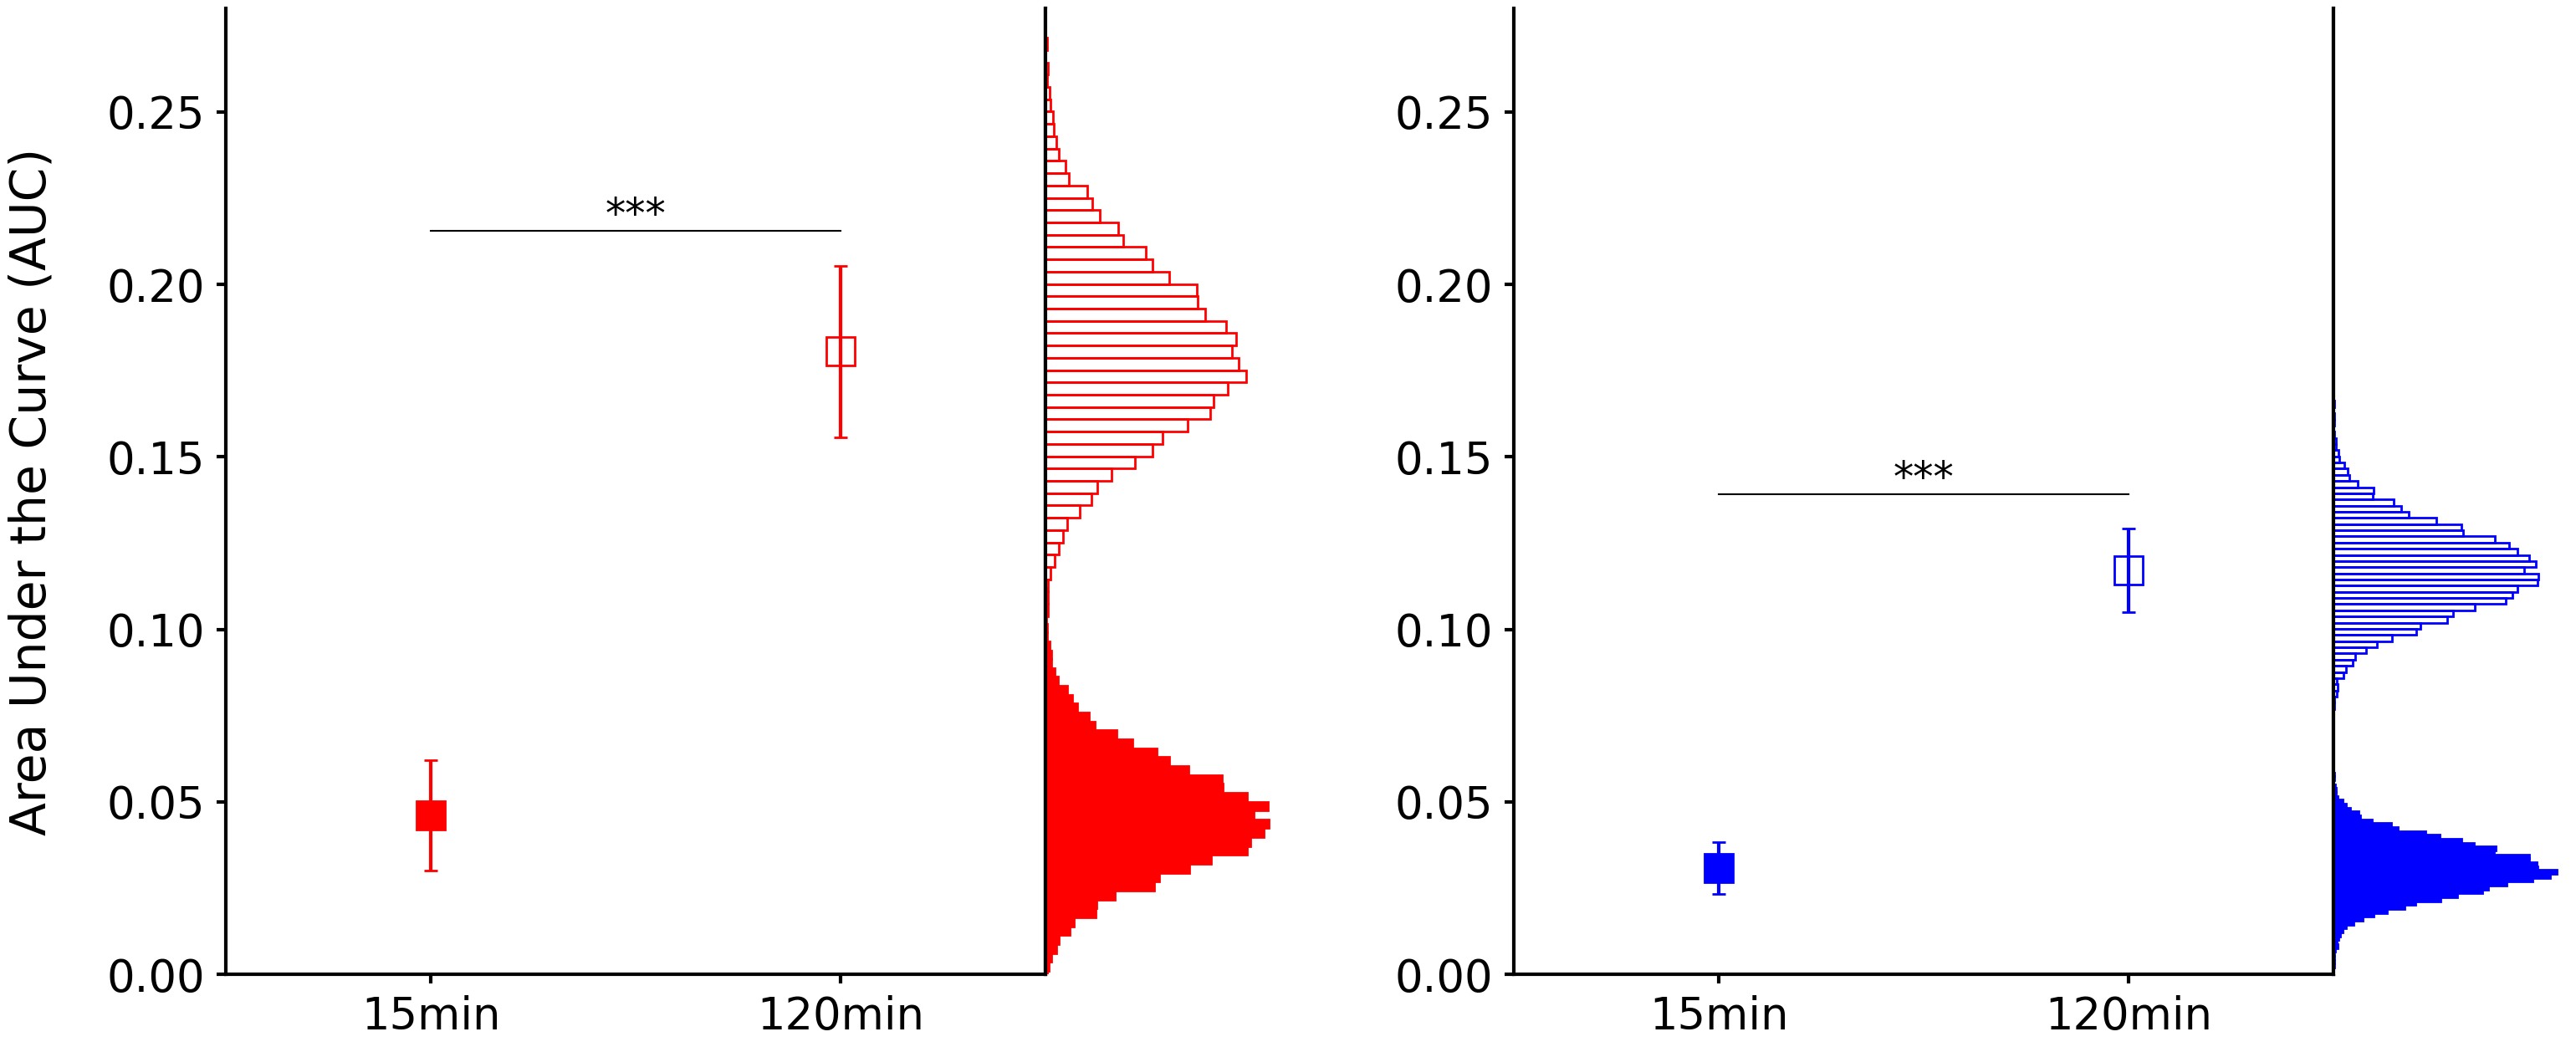

In [24]:
# Plot the results from our bootstrap
fig = plt.figure(figsize=(35, 15))

gspec = fig.add_gridspec(1, 5, width_ratios=(7, 2, 2, 7, 2), left=0.1, right=0.9, bottom=0.1, top=0.87, wspace=0)

# One ax for the labels
label_ax = fig.add_subplot(gspec[2], frameon=False)
label_ax.set_xticks([]), label_ax.set_yticks([])
label_ax.set_ylabel("Area Under the Curve (AUC)", fontsize=42, labelpad=1050)

y_lim = 0.28

# Error bar plots
ax_errorbar_rivalry, ax_errorbar_combination = fig.add_subplot(gspec[0]), fig.add_subplot(gspec[-2])
for ax in [ax_errorbar_rivalry, ax_errorbar_combination]:
    ax.spines["top"].set_visible(False)
    ax.spines[["bottom", "right", "left"]].set_linewidth(spines_linewidth)
    ax.set_ylim([0, y_lim])
    ax.set_yticks([0, 0.05, 0.10, 0.15, 0.20, 0.25])
    ax.set_xlim([0, 1])
    ax.set_xticks([0.25, 0.75]) # These are arbitrary values
    ax.set_xticklabels(["15min", "120min"], fontsize=38)
    ax.tick_params(length=8, width=3, pad=10, labelsize=38)

ax_errorbar_rivalry.errorbar(
    x=[0.25],
    y=bootstrap_dict["15min"]["rivalry"]["AUC_results"]["mean"],
    yerr=bootstrap_dict["15min"]["rivalry"]["AUC_results"]["error_bars"],
    **kw_dicts_auc["15min"]["rivalry"]
)
ax_errorbar_rivalry.errorbar(
    x=[0.75],
    y=bootstrap_dict["120min"]["rivalry"]["AUC_results"]["mean"],
    yerr=bootstrap_dict["120min"]["rivalry"]["AUC_results"]["error_bars"],
    **kw_dicts_auc["120min"]["rivalry"]
)
ax_errorbar_combination.errorbar(
    x=[0.25],
    y=bootstrap_dict["15min"]["combination"]["AUC_results"]["mean"],
    yerr=bootstrap_dict["15min"]["combination"]["AUC_results"]["error_bars"],
    **kw_dicts_auc["15min"]["combination"]
)
ax_errorbar_combination.errorbar(
    x=[0.75],
    y=bootstrap_dict["120min"]["combination"]["AUC_results"]["mean"],
    yerr=bootstrap_dict["120min"]["combination"]["AUC_results"]["error_bars"],
    **kw_dicts_auc["120min"]["combination"]
)

print(f"Riv 15 : {bootstrap_dict['15min']['rivalry']['AUC_results']['mean']} +- {bootstrap_dict['15min']['rivalry']['AUC_results']['error_bars']}")
print(f"Riv 120 : {bootstrap_dict['120min']['rivalry']['AUC_results']['mean']} +- {bootstrap_dict['120min']['rivalry']['AUC_results']['error_bars']}")
print(f"Comb 15 : {bootstrap_dict['15min']['combination']['AUC_results']['mean']} +- {bootstrap_dict['15min']['combination']['AUC_results']['error_bars']}")
print(f"Comb 120 : {bootstrap_dict['120min']['combination']['AUC_results']['mean']} +- {bootstrap_dict['120min']['combination']['AUC_results']['error_bars']}")

# Histogram plots
ax_histogram_rivalry, ax_histogram_combination = fig.add_subplot(gspec[1]), fig.add_subplot(gspec[-1])
n_bins=50
for ax in [ax_histogram_rivalry, ax_histogram_combination]:
    ax.xaxis.set_visible(False)
    ax.spines[["top","bottom","right"]].set_visible(False)
    ax.spines["left"].set_linewidth(spines_linewidth)
    ax.yaxis.set_label_position("right")
    ax.set_ylim(bottom=0, top=y_lim)
    ax.set_yticks([])
    ax.set_yticklabels([])
    ax.tick_params(length=8, width=3, pad=10, labelsize = 38)

ax_histogram_rivalry.hist(
    bootstrap_dict["15min"]["rivalry"]["AUC_results"]["values"], 
    bins=n_bins, color=colors["rivalry"], 
    orientation="horizontal", 
    fill=True, 
    lw=histogram_bars_linewidth, 
    ec=colors["rivalry"]
    )
ax_histogram_rivalry.hist(
    bootstrap_dict["120min"]["rivalry"]["AUC_results"]["values"], 
    bins=n_bins, color=colors["rivalry"], 
    orientation="horizontal", 
    fill=False, 
    lw=histogram_bars_linewidth, 
    ec=colors["rivalry"]
    )
ax_histogram_combination.hist(
    bootstrap_dict["15min"]["combination"]["AUC_results"]["values"], 
    bins=n_bins, color=colors["combination"], 
    orientation="horizontal", 
    fill=True, 
    lw=histogram_bars_linewidth, 
    ec=colors["combination"]
    )
ax_histogram_combination.hist(
    bootstrap_dict["120min"]["combination"]["AUC_results"]["values"], 
    bins=n_bins, color=colors["combination"], 
    orientation="horizontal", 
    fill=False, 
    lw=histogram_bars_linewidth, 
    ec=colors["combination"]
    )

# The significance bars and stars
bar_buffer = 0.01
stars_buffer = 0.001

top_errorbar_riv = bootstrap_dict["120min"]["rivalry"]["AUC_results"]["mean"] + bootstrap_dict["120min"]["rivalry"]["AUC_results"]["error_bars"]
top_errorbar_comb = bootstrap_dict["120min"]["combination"]["AUC_results"]["mean"] + bootstrap_dict["120min"]["combination"]["AUC_results"]["error_bars"]

ax_errorbar_rivalry.axhline(top_errorbar_riv + bar_buffer, xmin=0.25, xmax=0.75, color='k')
ax_errorbar_rivalry.text(0.5, top_errorbar_riv + bar_buffer + stars_buffer, "***", horizontalalignment="center", fontsize=35)

ax_errorbar_combination.axhline(top_errorbar_comb + bar_buffer, xmin=0.25, xmax=0.75,color='k')
ax_errorbar_combination.text(0.5,top_errorbar_comb + bar_buffer + stars_buffer, "***", horizontalalignment='center', fontsize=35)

plt.show()

fig.savefig(os.path.join(images_dir, "auc_comparison_br_bc_review.png"))

## Correaltions between BR and BC

### Test-retest reliability for each technique

Mean +- SEM rivalry:
S1: 1.1511101312320091 +- 0.042543366106636823
S2: 1.1810137230122189 +- 0.041921600971464655
Baseline correlation rivalry : r=0.5761538461538462, p=0.003
Mean +- SEM combination:
S1: 1.045372334336295 +- 0.02285744266913221
S2: 1.0482274143592927 +- 0.01868527786480951
Baseline correlation combination : r=0.4876923076923077, p=0.013


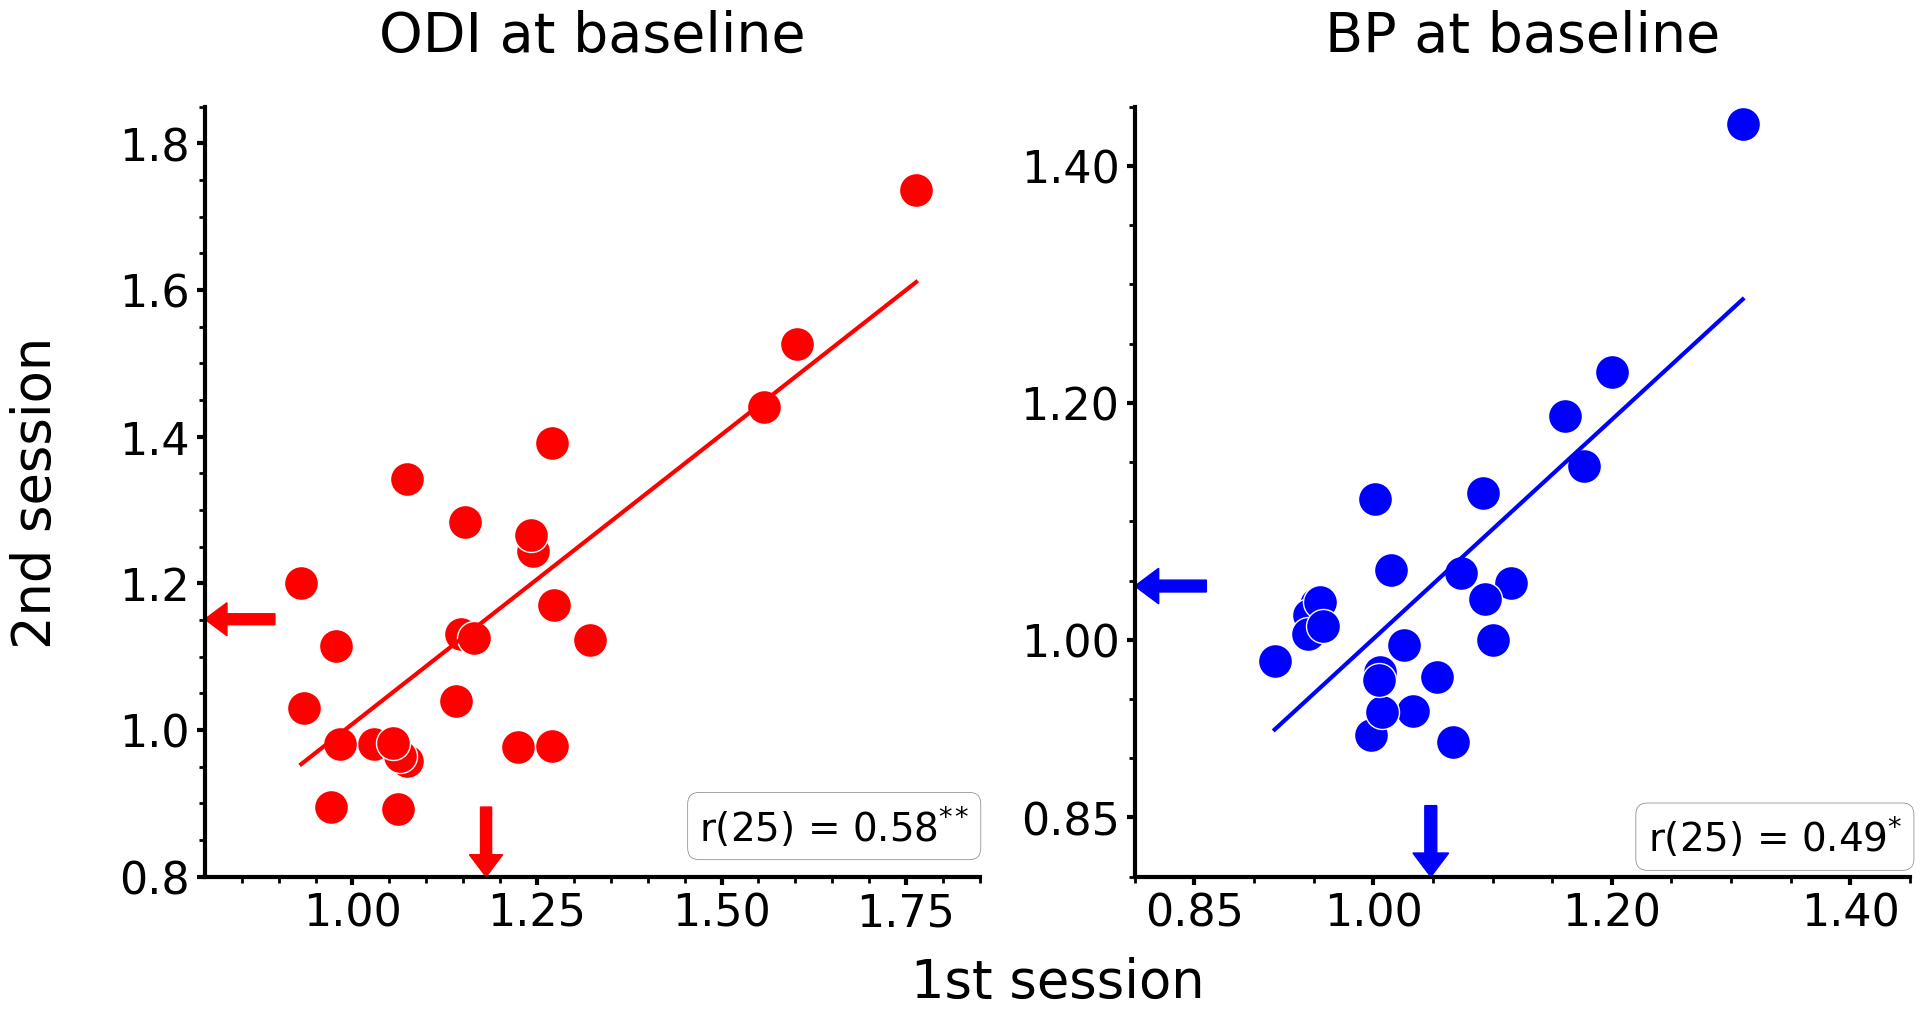

In [25]:
fig, axes = plt.subplots(1,2,figsize=(22,10), gridspec_kw=dict(wspace=0.2))
fontsize_axlabels = 38
fontsize_titles = 40
fontsize_ticklabels = 32
# Ax for the labels
label_ax = fig.add_subplot(111, frameon=False)
label_ax.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
label_ax.set_xlabel("1st session", fontsize = fontsize_axlabels, labelpad=40), label_ax.set_ylabel("2nd session", fontsize = fontsize_axlabels, labelpad=80)

# Actual plots
ax_rivalry, ax_combination = axes[0], axes[1]
ax_rivalry.set_title("ODI at baseline", pad = 40, fontsize = fontsize_titles), ax_combination.set_title("BP at baseline", pad = 40, fontsize = fontsize_titles)

for ax in axes:
    ax.spines[["top", "right"]].set_visible(False)
    ax.spines[["bottom", "left"]].set_linewidth(spines_linewidth)
    ax.tick_params(labelsize=fontsize_ticklabels, pad=5, length=6, width=3)
    ax.minorticks_on(), ax.tick_params(which="minor", length=4, width=2)

ax_rivalry.set_ylim(0.8,1.85), ax_rivalry.set_xlim(0.8,1.85)
# ax_rivalry.set_xticks([0.42, 0.5, 0.6, 0.7]), ax_rivalry.set_yticks([0.42, 0.5, 0.6, 0.7])
# ax_rivalry.xaxis.set_minor_locator(MultipleLocator(0.02)), ax_rivalry.yaxis.set_minor_locator(MultipleLocator(0.02))

ax_combination.set_ylim(0.8,1.45), ax_combination.set_xlim(0.8,1.45)
ax_combination.set_xticks([0.85,1,1.2,1.4]), ax_combination.set_yticks([0.85,1,1.2,1.4])
ax_combination.xaxis.set_minor_locator(MultipleLocator(0.05)), ax_combination.yaxis.set_minor_locator(MultipleLocator(0.05))

# plotting
ax_rivalry.scatter(
    rivalry_df.loc[(participant_list, "15min", "baseline"), "ODI"],
    rivalry_df.loc[(participant_list, "120min", "baseline"), "ODI"],
    marker='o',
    s=600,
    color=colors["rivalry"],
    edgecolors="white"
)
print(f"Mean +- SEM rivalry:")
print(f"S1: {np.mean(rivalry_df.loc[(slice(None), '120min', 'baseline'), 'ODI'])} +- {rivalry_df.loc[(slice(None), '120min', 'baseline'), 'ODI'].sem()}")
print(f"S2: {np.mean(rivalry_df.loc[(slice(None), '15min', 'baseline'), 'ODI'])} +- {rivalry_df.loc[(slice(None), '15min', 'baseline'), 'ODI'].sem()}")


corr, p = spearmanr(rivalry_df.loc[(participant_list, "15min", "baseline"), "ODI"], rivalry_df.loc[(participant_list, "120min", "baseline"), "ODI"])
print(f"Baseline correlation rivalry : r={corr}, p={p:.3f}")
linear_regression = linregress(rivalry_df.loc[(participant_list, "15min", "baseline"), "ODI"], rivalry_df.loc[(participant_list, "120min", "baseline"), "ODI"])
regression_line_span = np.linspace(np.min(rivalry_df.loc[(participant_list, "15min", "baseline"), "ODI"]), np.max(rivalry_df.loc[(participant_list, "15min", "baseline"), "ODI"]))
ax_rivalry.plot(regression_line_span, linear_regression.intercept + linear_regression.slope*regression_line_span, color=colors["rivalry"], lw=3)
# ax_rivalry.text(1.2,0.85,f"r(25) = {corr:.2f}, p = {p:.6f}",fontsize=28, bbox={"boxstyle":"round","facecolor":"white","lw":.5,"edgecolor":"grey"})
sig_level = anf.significance_level(p)
ax_rivalry.text(1.47,0.85,f"r(25) = {corr:.2f}" +r"$^{*}$"*sig_level,fontsize=28, bbox={"boxstyle":"round","facecolor":"white","lw":.5,"edgecolor":"grey"})

ax_combination.scatter(
    combination_df.loc[(participant_list, "15min", "baseline"), "eta"],
    combination_df.loc[(participant_list, "120min", "baseline"), "eta"],
    marker='o',
    s=600,
    color=colors["combination"],
    edgecolors="white"
)
print(f"Mean +- SEM combination:")
print(f"S1: {np.mean(combination_df.loc[(slice(None), '120min', 'baseline'), 'eta'])} +- {combination_df.loc[(slice(None), '120min', 'baseline'), 'eta'].sem()}")
print(f"S2: {np.mean(combination_df.loc[(slice(None), '15min', 'baseline'), 'eta'])} +- {combination_df.loc[(slice(None), '15min', 'baseline'), 'eta'].sem()}")

corr, p = spearmanr(combination_df.loc[(participant_list, "15min", "baseline"), "eta"], combination_df.loc[(participant_list, "120min", "baseline"), "eta"])
print(f"Baseline correlation combination : r={corr}, p={p:.3f}")
linear_regression = linregress(combination_df.loc[(participant_list, "15min", "baseline"), "eta"], combination_df.loc[(participant_list, "120min", "baseline"), "eta"])
regression_line_span = np.linspace(np.min(combination_df.loc[(participant_list, "15min", "baseline"), "eta"]), np.max(combination_df.loc[(participant_list, "15min", "baseline"), "eta"]))
ax_combination.plot(regression_line_span, linear_regression.intercept + linear_regression.slope*regression_line_span, color=colors["combination"], lw=3)
# ax_combination.text(1.19,0.822,f"r(25) = {corr:.2f}, p = {p:.6f}",fontsize=28, bbox={"boxstyle":"round","facecolor":"white","lw":.5,"edgecolor":"grey"})
sig_level = anf.significance_level(p)
ax_combination.text(1.23,0.822,f"r(25) = {corr:.2f}" +r"$^{*}$"*sig_level,fontsize=28, bbox={"boxstyle":"round","facecolor":"white","lw":.5,"edgecolor":"grey"})

# Use arrows to indicate the mean values of each measurement
ax_rivalry.arrow(
    x = np.mean(rivalry_df.loc[(participant_list, "15min", "baseline"), "ODI"]),
    y = 0.895,
    dx = 0,
    dy=-0.095,
    width=0.015,
    length_includes_head=True,
    head_length = 0.03,
    color = colors["rivalry"]
)
ax_rivalry.arrow(
    x = 0.895,
    y = np.mean(rivalry_df.loc[(slice(None), "120min", "baseline"), "ODI"]),
    dx = -0.095,
    dy = 0,
    width = 0.015,
    length_includes_head = True,
    head_length = 0.03,
    color = colors["rivalry"]
)

ax_combination.arrow(
    x = np.mean(combination_df.loc[(slice(None), "15min", "baseline"), "eta"]),
    y = 0.86,
    dx = 0,
    dy=-0.06,
    width=0.01,
    length_includes_head=True,
    head_length = 0.02,
    color = colors["combination"]
)

ax_combination.arrow(
    x = 0.86,
    y = np.mean(combination_df.loc[(slice(None), "120min", "baseline"), "eta"]),
    dx = -0.06,
    dy = 0,
    width = 0.01,
    length_includes_head = True,
    head_length = 0.02,
    color = colors["combination"]
)

plt.show()

fig.savefig(os.path.join(images_dir, "test-retest_realiability_br_bc_review.png"))

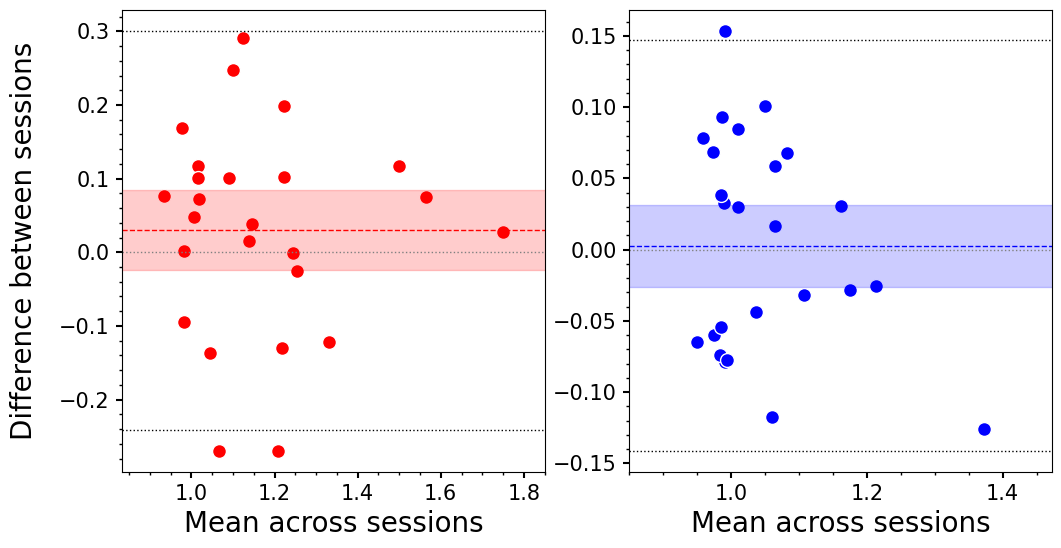

In [26]:
# Bland-Altman plot
fig, axes = plt.subplots(1,2, figsize=(12,6))
ax_riv, ax_comb = axes[0], axes[1]

marker_sz = 100

for ax in axes:
    ax.tick_params(labelsize=15, pad=5, length=4, width=1.5)
    ax.minorticks_on(), ax.tick_params(which="minor", length=2, width=1)
    ax.set_xlabel("Mean across sessions", fontsize=20)

ax_riv.set_ylabel("Difference between sessions", fontsize = 20, labelpad = 15)

# Rivalry
test_retest_diff_riv = rivalry_df.loc[(participant_list, "15min", "baseline"), "ODI"].values - rivalry_df.loc[(participant_list, "120min", "baseline"), "ODI"].values
test_retest_mean_riv = (rivalry_df.loc[(participant_list, "15min", "baseline"), "ODI"].values + rivalry_df.loc[(participant_list, "120min", "baseline"), "ODI"].values)/2

shaded_x_riv = np.linspace(np.min(test_retest_mean_riv) - 0.5, np.max(test_retest_mean_riv) + 0.5, len(test_retest_mean_riv))

std_diff_riv = test_retest_diff_riv.std()
mean_diff_riv = test_retest_diff_riv.mean()
n_diff_riv = len(test_retest_diff_riv)

upper_agreement_limit_riv = mean_diff_riv + (1.96 * std_diff_riv)
lower_agreement_limit_riv = mean_diff_riv - (1.96 * std_diff_riv)


scatter_kw = dict(marker='o', s=marker_sz, color=colors["rivalry"], edgecolors="white")
ax_riv.set_xlim(np.min(test_retest_mean_riv)-0.1, np.max(test_retest_mean_riv)+0.1)

ax_riv.scatter(test_retest_mean_riv, test_retest_diff_riv,marker='o', s=marker_sz, color=colors["rivalry"], edgecolors="white")
ax_riv.axhline(mean_diff_riv, ls='--', color='red', lw=1)
ax_riv.axhline(upper_agreement_limit_riv, ls=':', color='k', lw=1)
ax_riv.axhline(lower_agreement_limit_riv, ls=':', color='k', lw=1)


# 95% CI plotting


t_value_diff_riv, _ = ttest_1samp(test_retest_diff_riv, 0)

ci_mean_riv = 1.96 * (std_diff_riv/np.sqrt(n_diff_riv))
ci_agreement_limits_riv = 1.96 * std_diff_riv * np.sqrt(3/n_diff_riv) * t_value_diff_riv


ax_riv.fill_between(shaded_x_riv, mean_diff_riv - ci_mean_riv,mean_diff_riv + ci_mean_riv, alpha=0.2, color=colors["rivalry"])



ax_riv.axhline(0, ls=':', color='grey', lw=1)

# Combination
test_retest_diff_comb = combination_df.loc[(participant_list, "15min", "baseline"), "eta"].values - combination_df.loc[(participant_list, "120min", "baseline"), "eta"].values
test_retest_mean_comb = (combination_df.loc[(participant_list, "15min", "baseline"), "eta"].values + combination_df.loc[(participant_list, "120min", "baseline"), "eta"].values)/2

shaded_x_comb = np.linspace(np.min(test_retest_mean_comb) - 0.5, np.max(test_retest_mean_comb) + 0.5, len(test_retest_mean_comb))

std_diff_comb = test_retest_diff_comb.std()
mean_diff_comb = test_retest_diff_comb.mean()
n_diff_comb = len(test_retest_diff_comb)

upper_agreement_limit_comb = mean_diff_comb + (1.96 * std_diff_comb)
lower_agreement_limit_comb = mean_diff_comb - (1.96 * std_diff_comb)


scatter_kw = dict(marker='o', s=marker_sz, color=colors["combination"], edgecolors="white")
ax_comb.set_xlim(np.min(test_retest_mean_comb)-0.1, np.max(test_retest_mean_comb)+0.1)

ax_comb.scatter(test_retest_mean_comb, test_retest_diff_comb,marker='o', s=marker_sz, color=colors["combination"], edgecolors="white")
ax_comb.axhline(mean_diff_comb, ls='--', color=colors["combination"], lw=1)
ax_comb.axhline(upper_agreement_limit_comb, ls=':', color='k', lw=1)
ax_comb.axhline(lower_agreement_limit_comb, ls=':', color='k', lw=1)

# 95% CI plotting


t_value_diff_comb, _ = ttest_1samp(test_retest_diff_comb, 0)

ci_mean_comb = 1.96 * (std_diff_comb/np.sqrt(n_diff_comb))
ci_agreement_limits_comb = 1.96 * std_diff_comb * np.sqrt(3/n_diff_comb) * t_value_diff_comb


ax_comb.fill_between(shaded_x_comb, mean_diff_comb - ci_mean_comb,mean_diff_comb + ci_mean_comb, alpha=0.2, color=colors["combination"])


ax_comb.axhline(0, ls=':', color='grey', lw=1)
plt.show()

In [27]:
print(mean_diff_comb - ci_mean_comb,mean_diff_comb + ci_mean_comb)
print(mean_diff_riv - ci_mean_riv,mean_diff_riv + ci_mean_riv)

-0.02598292045434203 0.03169308050033713
-0.024215772869792016 0.0840229564302116


In [28]:
# Normality test of the differences in test-retest
test_retest_diff_riv = rivalry_df.loc[(participant_list, "15min", "baseline"), "ODI"].values - rivalry_df.loc[(participant_list, "120min", "baseline"), "ODI"].values
test_retest_diff_comb = combination_df.loc[(participant_list, "15min", "baseline"), "eta"].values - combination_df.loc[(participant_list, "120min", "baseline"), "eta"].values
print(f"Rivalry diff shapiro test : {shapiro(test_retest_diff_riv)}")
print(f"Combination diff shapiro test : {shapiro(test_retest_diff_comb)}")

Rivalry diff shapiro test : ShapiroResult(statistic=0.9586807489395142, pvalue=0.38882535696029663)
Combination diff shapiro test : ShapiroResult(statistic=0.9615719318389893, pvalue=0.4466651380062103)


In [29]:
# t-test of mean(diff) vs 0
print(f"Rivalry diff t-test vs 0 : {ttest_1samp(test_retest_diff_riv, 0)}")
print(f"Combination diff t-test vs 0 : {ttest_1samp(test_retest_diff_comb, 0)}")

Rivalry diff t-test vs 0 : TtestResult(statistic=1.0611147558804441, pvalue=0.29919979411012415, df=24)
Combination diff t-test vs 0 : TtestResult(statistic=0.1901274521975258, pvalue=0.850808246721776, df=24)


### Baselines vs baselines

Correlation : r=0.5384615384615384, p=0.0055


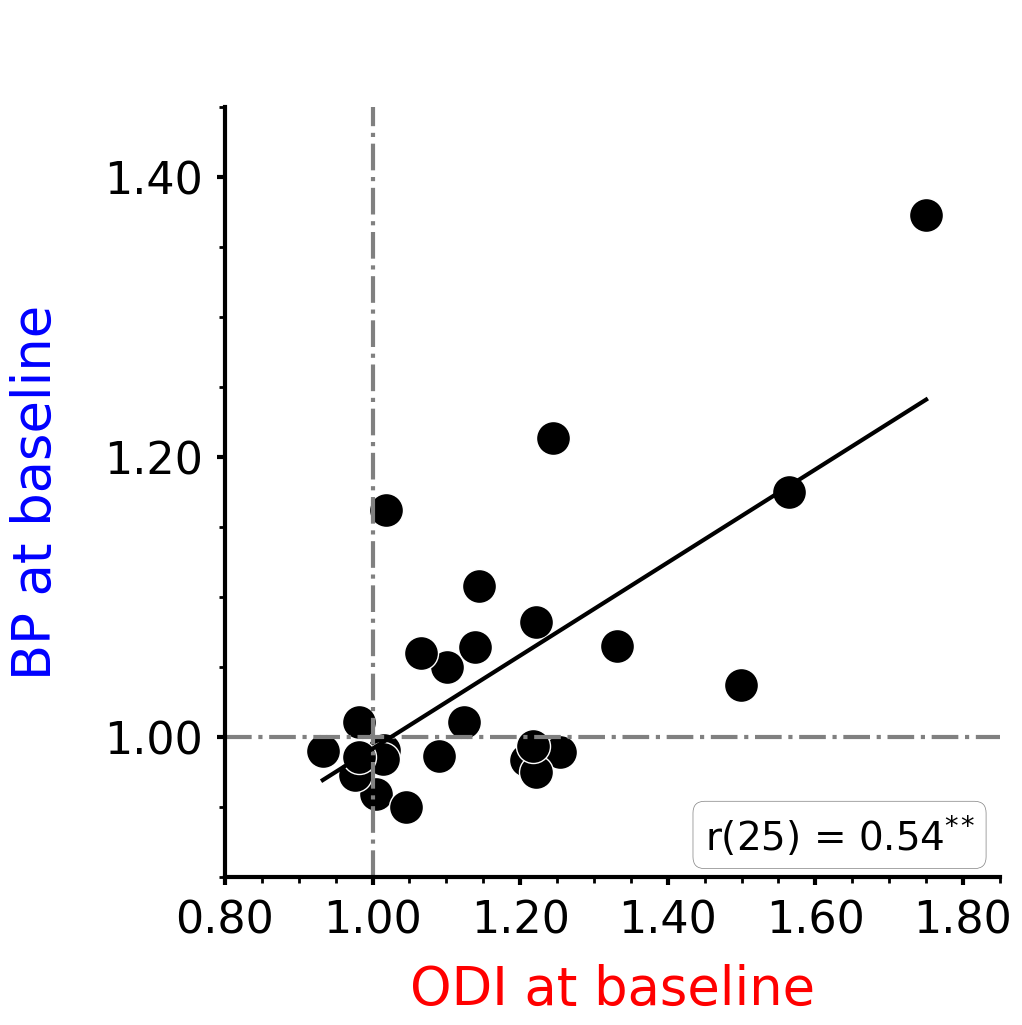

In [30]:
baseline_columns = ["baseline_15min", "baseline_120min"]
fig, ax = plt.subplots(1,1, figsize= (10,10))
ax.set_title(" ", pad=40, fontsize=fontsize_titles)
ax.spines[["right", "top"]].set_visible(False)
ax.spines[["left", "bottom"]].set_linewidth(spines_linewidth)
ax.set_xlabel("ODI at baseline", fontsize=fontsize_axlabels, color='r', labelpad=15)
ax.set_ylabel("BP at baseline", fontsize=fontsize_axlabels, color='b', labelpad=30)
ax.set_yticks([0.85,1,1.2,1.4])
ax.yaxis.set_major_formatter(StrMethodFormatter("{x:,.2f}"))
ax.xaxis.set_major_formatter(StrMethodFormatter("{x:,.2f}"))

ax.set_ylim(0.9,1.45)
ax.set_xlim(0.8,1.85)
ax.xaxis.set_major_locator(MultipleLocator(base=0.2))
ax.xaxis.set_minor_locator(MultipleLocator(base=0.05))
ax.yaxis.set_major_locator(MultipleLocator(base=0.2))
ax.yaxis.set_minor_locator(MultipleLocator(base=0.05))
ax.tick_params(axis="both", labelsize=fontsize_ticklabels, length=6, width=3, pad=10)
ax.tick_params(which="minor", length=4, width=2)

ax.scatter(
    rivalry_raw_rearranged[baseline_columns].mean(axis=1),
    combination_raw_rearranged[baseline_columns].mean(axis=1),
    marker='o',
    s=600,
    color='k',
    edgecolors="white"
)

ax.axhline(1.0, ls="-.", color="grey", lw=3)
ax.axvline(1.0, ls="-.", color="grey", lw=3)

corr, p = spearmanr(rivalry_raw_rearranged[baseline_columns].mean(axis=1), combination_raw_rearranged[baseline_columns].mean(axis=1))
print(f"Correlation : r={corr}, p={p:.4f}")
linear_regression = linregress(rivalry_raw_rearranged[baseline_columns].mean(axis=1), combination_raw_rearranged[baseline_columns].mean(axis=1))
regression_line_span = np.linspace(np.min(rivalry_raw_rearranged[baseline_columns].mean(axis=1)), np.max(rivalry_raw_rearranged[baseline_columns].mean(axis=1)))

ax.plot(regression_line_span, linear_regression.intercept+linear_regression.slope*regression_line_span, color="k", lw=3)

# ax.text(1.3, 0.92, f"r(25) = {corr:.2f}, p = {p:.6f}", fontsize=28, bbox={"boxstyle":"round", "edgecolor":"k","facecolor":"white","lw":.5,"edgecolor":"grey"})
sig_level = anf.significance_level(p)
ax.text(1.45, 0.92, f"r(25) = {corr:.2f}"+r"$^{*}$"*sig_level, fontsize=28, bbox={"boxstyle":"round", "edgecolor":"k","facecolor":"white","lw":.5,"edgecolor":"grey"})

plt.show()

fig.savefig(os.path.join(images_dir, "correlation_baselines_br_bc_review.png"))

### Raw data after deprivation

Correlation 120min: r=0.6723076923076923, p=0.000232101742663929
Correlation 15min: r=0.5115384615384615, p=0.008957622350113654


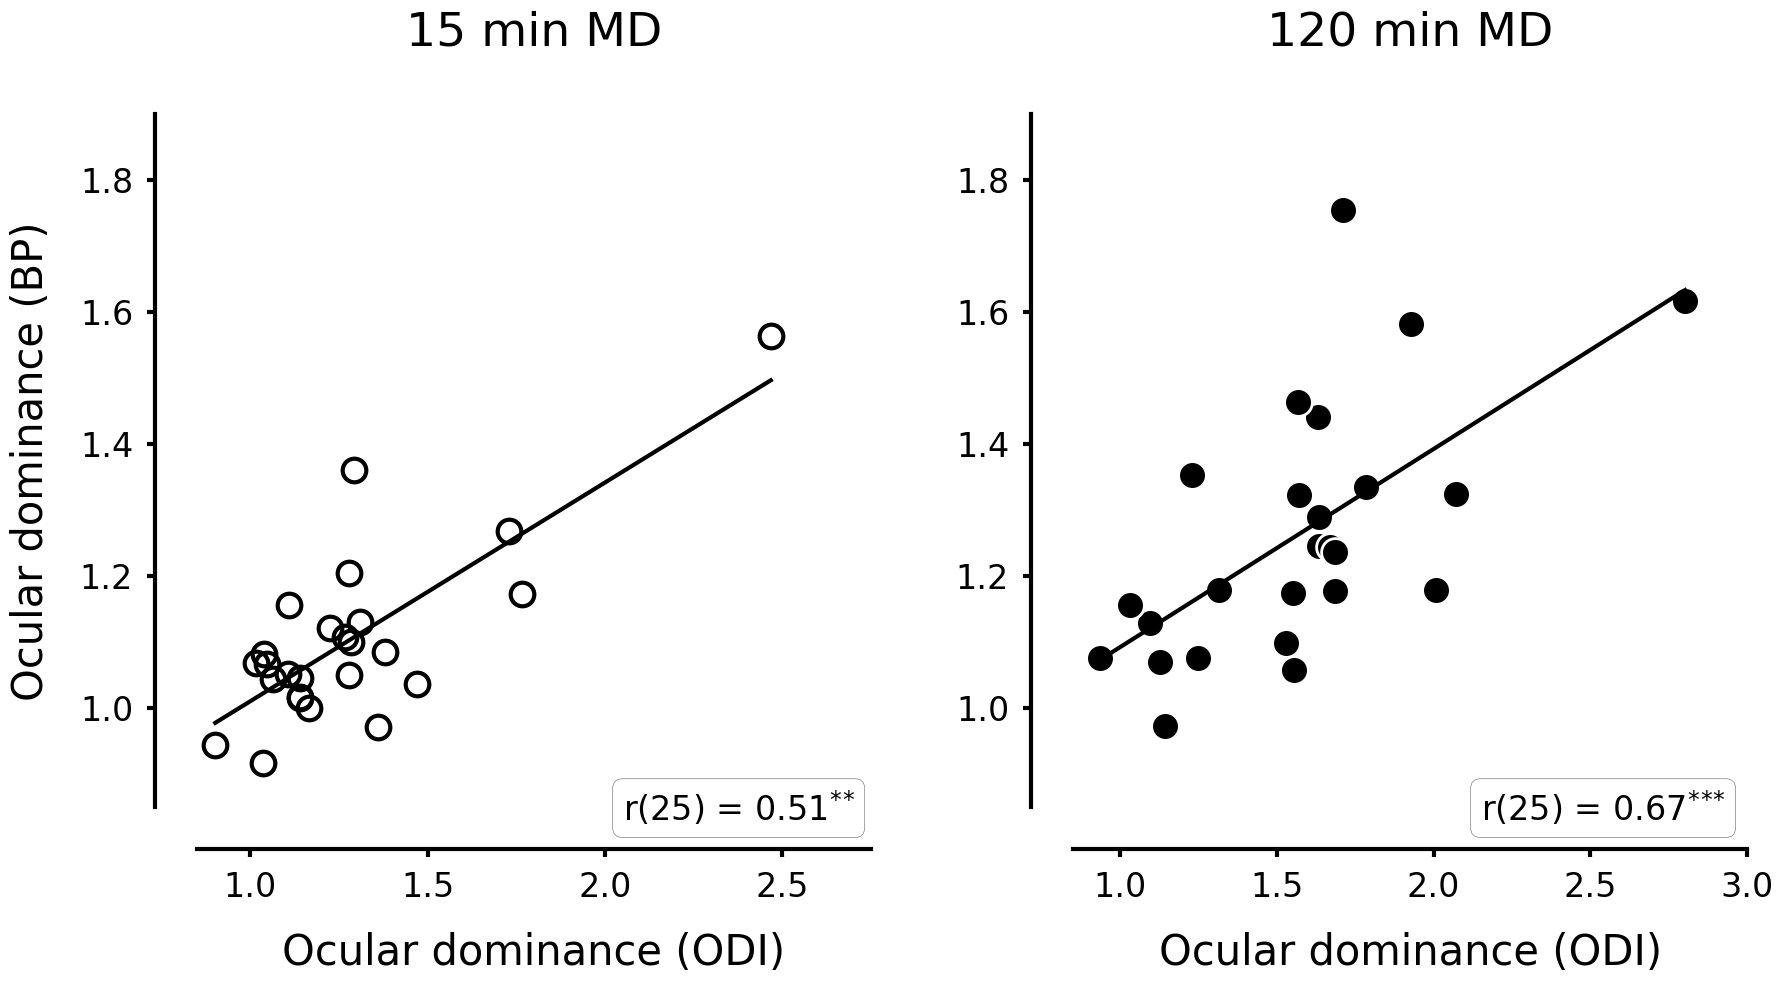

In [31]:
fig, axes = plt.subplots(1, 2, figsize=(20, 9), gridspec_kw=dict(wspace=0.3, hspace=0.4))
ax_15, ax_120 = axes[0], axes[1]
ax_15.set_title("15 min MD", fontsize=34, pad=50), ax_120.set_title("120 min MD", fontsize=34, pad=50)
ax_120.set_xlabel("Ocular dominance (ODI)", fontsize=30, labelpad=20), ax_15.set_ylabel("Ocular dominance (BP)", fontsize=30, labelpad=20), ax_15.set_xlabel("Ocular dominance (ODI)", fontsize=30, labelpad=20)


for ax in axes:
    ax.spines[["top","right"]].set_visible(False)
    ax.spines[["left","bottom"]].set_linewidth(3)
    ax.spines[["left", "bottom"]].set_position(("outward", 30))
    ax.tick_params(length=6, width=3, pad=10, labelsize=24)
    ax.tick_params(which="minor", length = 4, width = 2)
    ax.set_ylim(0.85, 1.9)
    # ax.xaxis.set_major_locator(MultipleLocator(base=0.1))
    # ax.xaxis.set_minor_locator(MultipleLocator(base=0.05))
    # ax.yaxis.set_minor_locator(MultipleLocator(base=0.1))

ax_15.set_xlim(0.85, 2.75)
ax_120.set_xlim(0.85, 3)

ax_15.plot(
    vertical_raw_df["15min"]["rivalry"].drop("baseline_15min", axis=1).mean(axis=1),
    vertical_raw_df["15min"]["combination"].drop("baseline_15min", axis=1).mean(axis=1),
    ls="",
    color="k",
    marker="o",
    mew=3,
    ms=17,
    fillstyle="none"
)
ax_120.plot(
    vertical_raw_df["120min"]["rivalry"].drop("baseline_120min", axis=1).mean(axis=1),
    vertical_raw_df["120min"]["combination"].drop("baseline_120min", axis=1).mean(axis=1),
    ls="",
    color="k",
    marker="o",
    mew=2,
    ms=20,
    fillstyle="full",
    mec="white"
)

corr, p = spearmanr(vertical_raw_df["120min"]["rivalry"].drop("baseline_120min", axis=1).mean(axis=1), vertical_raw_df["120min"]["combination"].drop("baseline_120min", axis=1).mean(axis=1))
# ax_120.text(1.6, 0.95, f"r(25) = {corr:.2f}, p={p:.6f}", fontsize=24, bbox={"boxstyle":"round","facecolor":"white","lw":.5,"edgecolor":"grey"})
print(f"Correlation 120min: r={corr}, p={p}")
sig_level = anf.significance_level(p)
ax_120.text(2.15, 0.83, f"r(25) = {corr:.2f}"+r"$^{*}$"*sig_level, fontsize=24, bbox={"boxstyle":"round","facecolor":"white","lw":.5,"edgecolor":"grey"})

linear_regression = linregress(vertical_raw_df["120min"]["rivalry"].drop("baseline_120min", axis=1).mean(axis=1), vertical_raw_df["120min"]["combination"].drop("baseline_120min", axis=1).mean(axis=1))
regression_line_span = np.linspace( #This line will go from the min to the max of the ODI represented on the plot
    np.min(vertical_raw_df["120min"]["rivalry"].drop("baseline_120min", axis=1).mean(axis=1)), 
    np.max(vertical_raw_df["120min"]["rivalry"].drop("baseline_120min", axis=1).mean(axis=1))
    )
ax_120.plot(
    regression_line_span,
    linear_regression.intercept + linear_regression.slope * regression_line_span,
    color = "k",
    lw=3
)

corr, p = spearmanr(vertical_raw_df["15min"]["rivalry"].drop("baseline_15min", axis=1).mean(axis=1), vertical_raw_df["15min"]["combination"].drop("baseline_15min", axis=1).mean(axis=1))
# ax_15.text(1.6, 0.9, f"r(25) = {corr:.2f}, p={p:.6f}", fontsize=24, bbox={"boxstyle":"round","facecolor":"white","lw":.5,"edgecolor":"grey"})
print(f"Correlation 15min: r={corr}, p={p}")
sig_level = anf.significance_level(p)
ax_15.text(2.05, 0.83, f"r(25) = {corr:.2f}"+r"$^{*}$"*sig_level, fontsize=24, bbox={"boxstyle":"round","facecolor":"white","lw":.5,"edgecolor":"grey"})
linear_regression = linregress(vertical_raw_df["15min"]["rivalry"].drop("baseline_15min", axis=1).mean(axis=1), vertical_raw_df["15min"]["combination"].drop("baseline_15min", axis=1).mean(axis=1))
regression_line_span = np.linspace( #This line will go from the min to the max of the ODI represented on the plot
    np.min(vertical_raw_df["15min"]["rivalry"].drop("baseline_15min", axis=1).mean(axis=1)), 
    np.max(vertical_raw_df["15min"]["rivalry"].drop("baseline_15min", axis=1).mean(axis=1))
    )
ax_15.plot(
    regression_line_span,
    linear_regression.intercept + linear_regression.slope * regression_line_span,
    color = "k",
    lw=3
)

plt.show()

fig.savefig(os.path.join(images_dir, "correlation_OD_postpatch_br_bc_review.png"))

### Effect vs effect

Correlation 120min: r=0.27692307692307694, p=0.1802089385790167
Correlation 15min: r=0.31153846153846154, p=0.12952924585337894


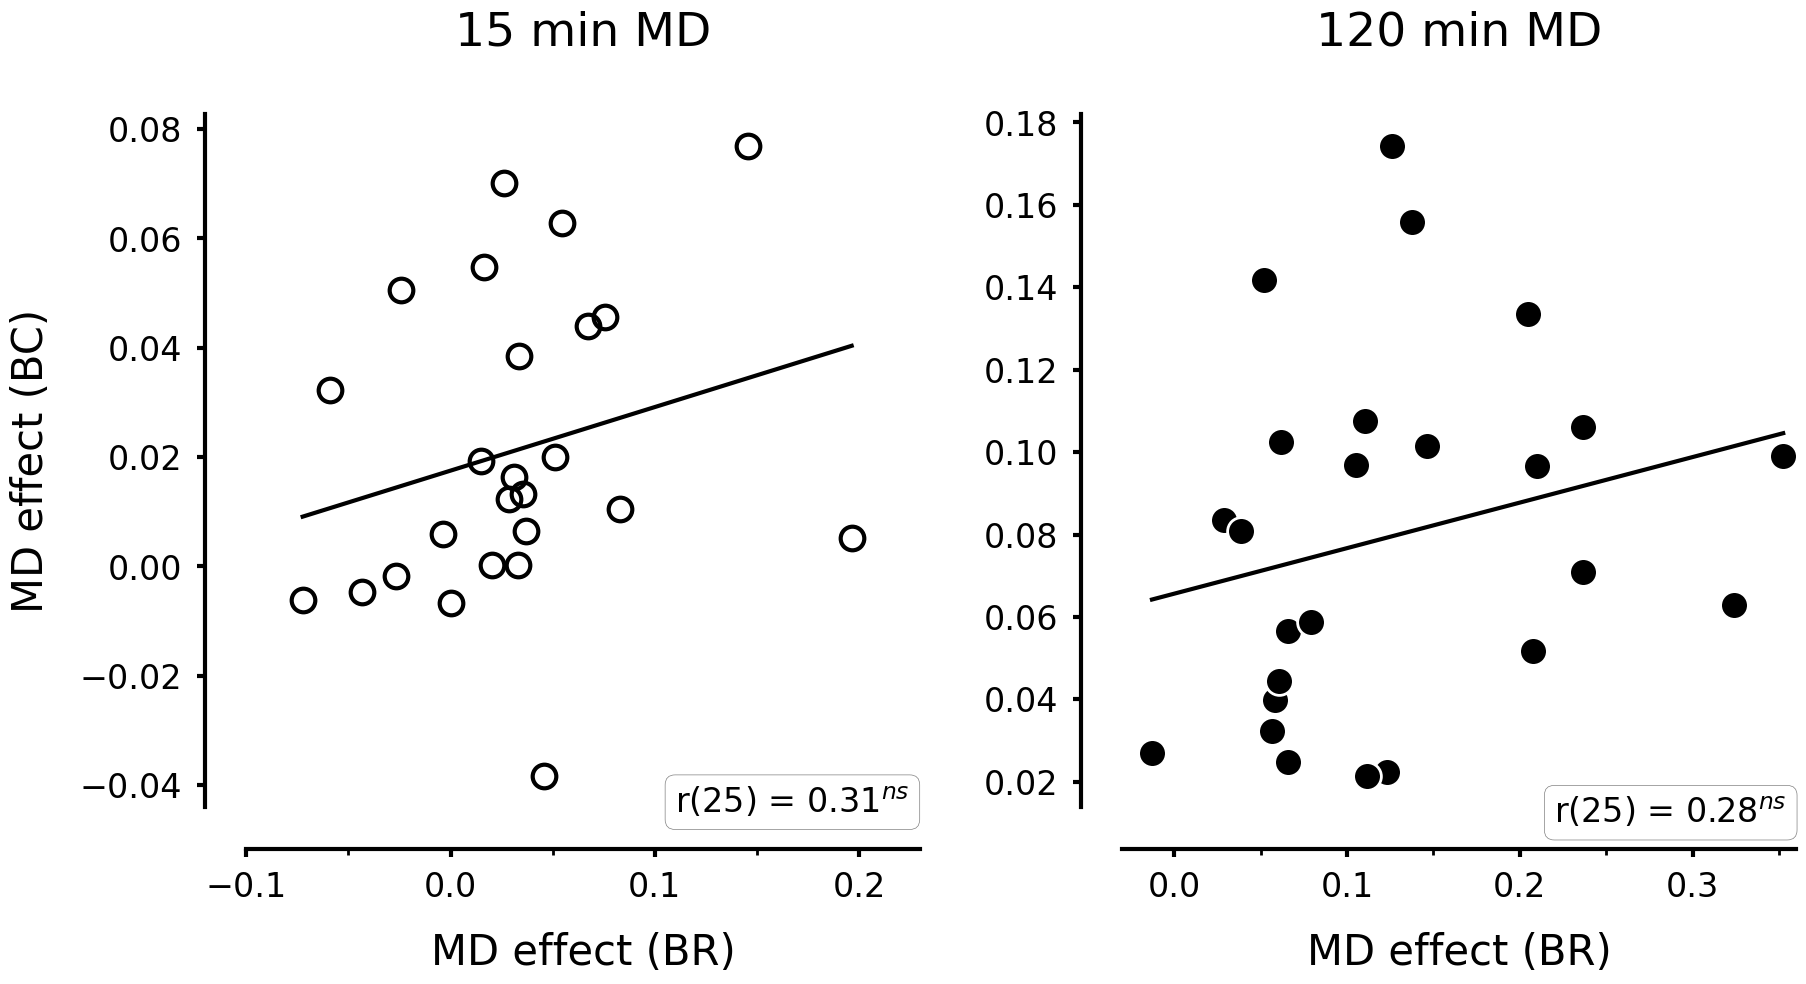

In [32]:
fig, axes = plt.subplots(1, 2, figsize=(20, 9), gridspec_kw=dict(wspace=0.3, hspace=0.4))
ax_15, ax_120 = axes[0], axes[1]
ax_15.set_title("15 min MD", fontsize=34, pad=50), ax_120.set_title("120 min MD", fontsize=34, pad=50)
ax_120.set_xlabel("MD effect (BR)", fontsize=30, labelpad=20), ax_15.set_ylabel("MD effect (BC)", fontsize=30, labelpad=20), ax_15.set_xlabel("MD effect (BR)", fontsize=30, labelpad=20)


for ax in axes:
    ax.spines[["top","right"]].set_visible(False)
    ax.spines[["left","bottom"]].set_linewidth(3)
    ax.spines[["left", "bottom"]].set_position(("outward", 30))
    ax.tick_params(length=6, width=3, pad=10, labelsize=24)
    ax.tick_params(which="minor", length = 4, width = 2)

ax_120.xaxis.set_major_locator(MultipleLocator(base=0.1))
ax_120.xaxis.set_minor_locator(MultipleLocator(base=0.05))
ax_120.yaxis.set_minor_locator(MultipleLocator(base=0.1))

ax_15.xaxis.set_major_locator(MultipleLocator(base=0.1))
ax_15.xaxis.set_minor_locator(MultipleLocator(base=0.05))

ax_15.set_xlim(-0.1, 0.23)
# ax_15.set_ylim(-0.045, 0.095)

ax_120.set_xlim(-0.03, 0.36)
# ax_120.set_ylim(-0.02, 0.15)

# Effect computation


ax_15.plot(
    arithmetic_mean_effect["15min"]["rivalry"],
    arithmetic_mean_effect["15min"]["combination"],
    ls="",
    color="k",
    marker="o",
    mew=3,
    ms=17,
    fillstyle="none"
)
ax_120.plot(
    arithmetic_mean_effect["120min"]["rivalry"],
    arithmetic_mean_effect["120min"]["combination"],
    ls="",
    color="k",
    marker="o",
    mew=2,
    ms=20,
    fillstyle="full",
    mec="white"
)

corr, p = spearmanr(arithmetic_mean_effect["120min"]["rivalry"], arithmetic_mean_effect["120min"]["combination"])
# ax_120.text(0.045, -0.02, f"r(25) = {corr:.2f}, p={p:.6f}", fontsize=24, bbox={"boxstyle":"round","facecolor":"white","lw":.5,"edgecolor":"grey"})
print(f"Correlation 120min: r={corr}, p={p}")
sig_level = anf.significance_level(p)
ax_120.text(0.22, 0.01, f"r(25) = {corr:.2f}"+r"$^{ns}$", fontsize=24, bbox={"boxstyle":"round","facecolor":"white","lw":.5,"edgecolor":"grey"})
linear_regression = linregress(arithmetic_mean_effect["120min"]["rivalry"], arithmetic_mean_effect["120min"]["combination"])
regression_line_span = np.linspace( #This line will go from the min to the max of the ODI represented on the plot
    np.min(arithmetic_mean_effect["120min"]["rivalry"]), 
    np.max(arithmetic_mean_effect["120min"]["rivalry"])
    )
ax_120.plot(
    regression_line_span,
    linear_regression.intercept + linear_regression.slope * regression_line_span,
    color = "k",
    lw=3
)

corr, p = spearmanr(arithmetic_mean_effect["15min"]["rivalry"], arithmetic_mean_effect["15min"]["combination"])
# ax_15.text(0.005, -0.045, f"r(25) = {corr:.2f}, p={p:.6f}", fontsize=24, bbox={"boxstyle":"round","facecolor":"white","lw":.5,"edgecolor":"grey"})
print(f"Correlation 15min: r={corr}, p={p}")
sig_level = anf.significance_level(p)
ax_15.text(0.11, -0.045, f"r(25) = {corr:.2f}"+r"$^{ns}$", fontsize=24, bbox={"boxstyle":"round","facecolor":"white","lw":.5,"edgecolor":"grey"})
linear_regression = linregress(arithmetic_mean_effect["15min"]["rivalry"], arithmetic_mean_effect["15min"]["combination"])
regression_line_span = np.linspace( #This line will go from the min to the max of the ODI represented on the plot
    np.min(arithmetic_mean_effect["15min"]["rivalry"]), 
    np.max(arithmetic_mean_effect["15min"]["rivalry"])
    )
ax_15.plot(
    regression_line_span,
    linear_regression.intercept + linear_regression.slope * regression_line_span,
    color = "k",
    lw=3
)

plt.show()

fig.savefig(os.path.join(images_dir, "correlation_md_effect_br_bc_review_suggestion.png"))

## Comparison between baseline and post-deprivation

### Baseline vs OD post-patch

#### Rivalry

Correlation 15min: r=0.5961538461538461, p=0.0016611241919869063
Correlation 120min: r=0.3715384615384616, p=0.06744805844100726
Correlation 120min (pearson): r=0.6061846447157484, p=0.001318454475468708


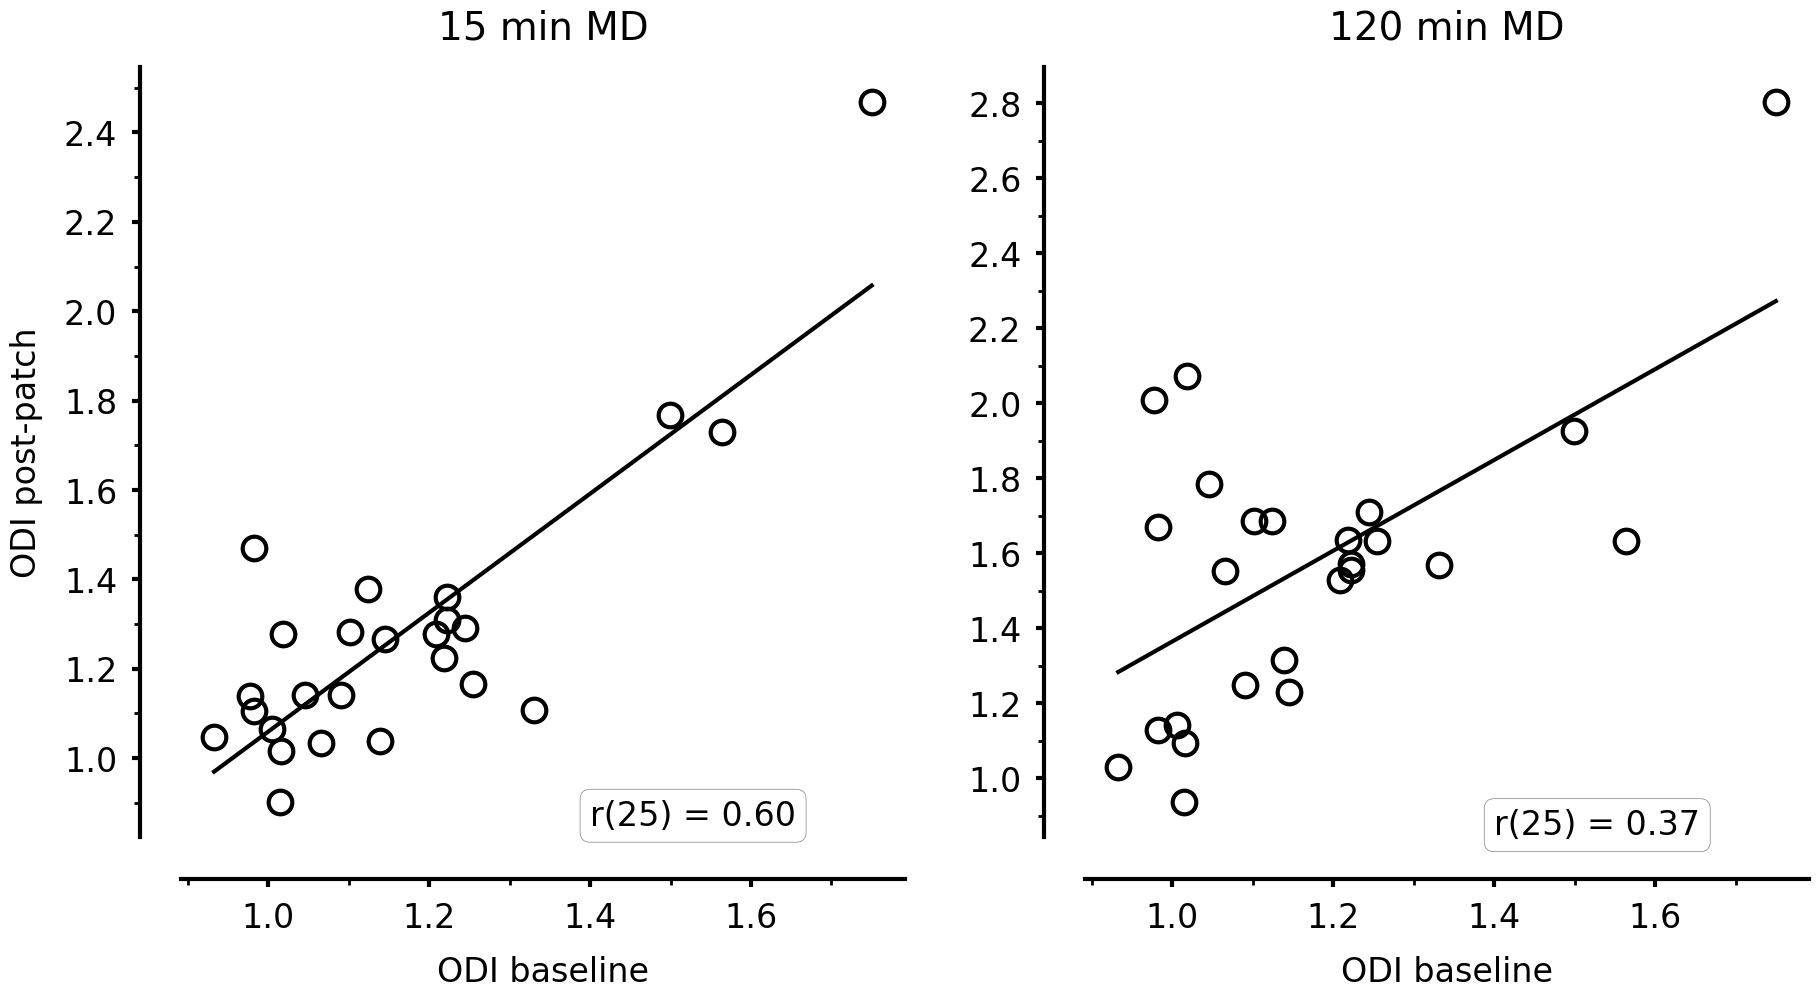

In [33]:
fig, axes = plt.subplots(1, 2, figsize=(21, 10), gridspec_kw=dict(wspace=0.25))
# fig.suptitle("Binocular rivalry", fontsize=28)
ax_15, ax_120 = axes[0], axes[1]

ax_15.set_title("15 min MD", fontsize=28, pad=20), ax_120.set_title("120 min MD", fontsize=28, pad=20)
ax_15.set_ylabel("ODI post-patch", fontsize=24, labelpad=15), ax_15.set_xlabel("ODI baseline", fontsize=24, labelpad=15), ax_120.set_xlabel("ODI baseline", fontsize=24, labelpad=15)

for ax in axes:
    ax.spines[["top","right"]].set_visible(False)
    ax.spines[["bottom", "left"]].set_linewidth(3)
    ax.tick_params(length=6, width=3, pad=10, labelsize=24)
    ax.tick_params(which="minor", length = 4, width = 2)
    ax.spines[["left", "bottom"]].set_position(("outward", 30))

ax_15.xaxis.set_major_locator(MultipleLocator(base=0.2)), ax_15.xaxis.set_minor_locator(MultipleLocator(base=0.1))
ax_15.yaxis.set_major_locator(MultipleLocator(base=0.2)), ax_15.yaxis.set_minor_locator(MultipleLocator(base=0.1))

# ax_15.set_xlim(0.45, 0.675)
# ax_15.set_ylim(0.45, 0.75)

ax_120.xaxis.set_major_locator(MultipleLocator(base=0.2)), ax_120.xaxis.set_minor_locator(MultipleLocator(base=0.1))
ax_120.yaxis.set_major_locator(MultipleLocator(base=0.2)), ax_120.yaxis.set_minor_locator(MultipleLocator(base=0.1))

# ax_120.set_xlim(0.45, 0.675)
# ax_120.set_ylim(0.45, 0.75)

ax_15.plot(
    rivalry_raw_rearranged[baseline_columns].mean(axis=1),
    vertical_raw_df["15min"]["rivalry"].drop("baseline_15min", axis=1).mean(axis=1),
    color = "k",
    marker="o",
    ms = 17,
    fillstyle="none",
    ls="",
    mew = 3
)

ax_120.plot(
    rivalry_raw_rearranged[baseline_columns].mean(axis=1),
    vertical_raw_df["120min"]["rivalry"].drop("baseline_120min", axis=1).mean(axis=1),
    color = "k",
    marker="o",
    ms = 17,
    fillstyle="none",
    ls="",
    mew = 3
)

corr, p = spearmanr(rivalry_raw_rearranged[baseline_columns].mean(axis=1), vertical_raw_df["15min"]["rivalry"].drop("baseline_15min", axis=1).mean(axis=1))
print(f"Correlation 15min: r={corr}, p={p}")
sig_level = anf.significance_level(p)
ax_15.text(1.4, 0.85, f"r(25) = {corr:.2f}", fontsize=24, bbox={"boxstyle":"round","facecolor":"white","lw":.5,"edgecolor":"grey"})
# ax_15.text(0.59, 0.45, f"r(25) = {corr:.2f}, p = {p:.6f}", fontsize=24, bbox={"boxstyle":"round","facecolor":"white","lw":.5,"edgecolor":"grey"})


# Linear fit
linear_regression = linregress(rivalry_raw_rearranged[baseline_columns].mean(axis=1), vertical_raw_df["15min"]["rivalry"].drop("baseline_15min", axis=1).mean(axis=1))
regression_line_span = np.linspace(min(rivalry_raw_rearranged[baseline_columns].mean(axis=1)), max(rivalry_raw_rearranged[baseline_columns].mean(axis=1)))
ax_15.plot(
    regression_line_span,
    linear_regression.intercept + linear_regression.slope * regression_line_span,
    color = "k",
    lw=3
)

corr, p = spearmanr(rivalry_raw_rearranged[baseline_columns].mean(axis=1), vertical_raw_df["120min"]["rivalry"].drop("baseline_120min", axis=1).mean(axis=1))
print(f"Correlation 120min: r={corr}, p={p}")
sig_level = anf.significance_level(p)
ax_120.text(1.4, 0.85, f"r(25) = {corr:.2f}", fontsize=24, bbox={"boxstyle":"round","facecolor":"white","lw":.5,"edgecolor":"grey"})
# ax_120.text(0.59, 0.45, f"r(25) = {corr:.2f}, p = {p:.6f}", fontsize=24, bbox={"boxstyle":"round","facecolor":"white","lw":.5,"edgecolor":"grey"})


linear_regression = linregress(rivalry_raw_rearranged[baseline_columns].mean(axis=1), vertical_raw_df["120min"]["rivalry"].drop("baseline_120min", axis=1).mean(axis=1))
regression_line_span = np.linspace(min(rivalry_raw_rearranged[baseline_columns].mean(axis=1)), max(rivalry_raw_rearranged[baseline_columns].mean(axis=1)))
ax_120.plot(
    regression_line_span,
    linear_regression.intercept + linear_regression.slope * regression_line_span,
    color = "k",
    lw=3
)

corr, p = pearsonr(rivalry_raw_rearranged[baseline_columns].mean(axis=1), vertical_raw_df["120min"]["rivalry"].drop("baseline_120min", axis=1).mean(axis=1))
print(f"Correlation 120min (pearson): r={corr}, p={p}")

fig.savefig(os.path.join(images_dir, "correlation_baseline_postpatch_br_review.png"))

#### Combination

Correlation 15min: r=0.7761538461538461, p=5.1169902282568975e-06
Correlation 120min: r=0.703076923076923, p=8.863539245670383e-05


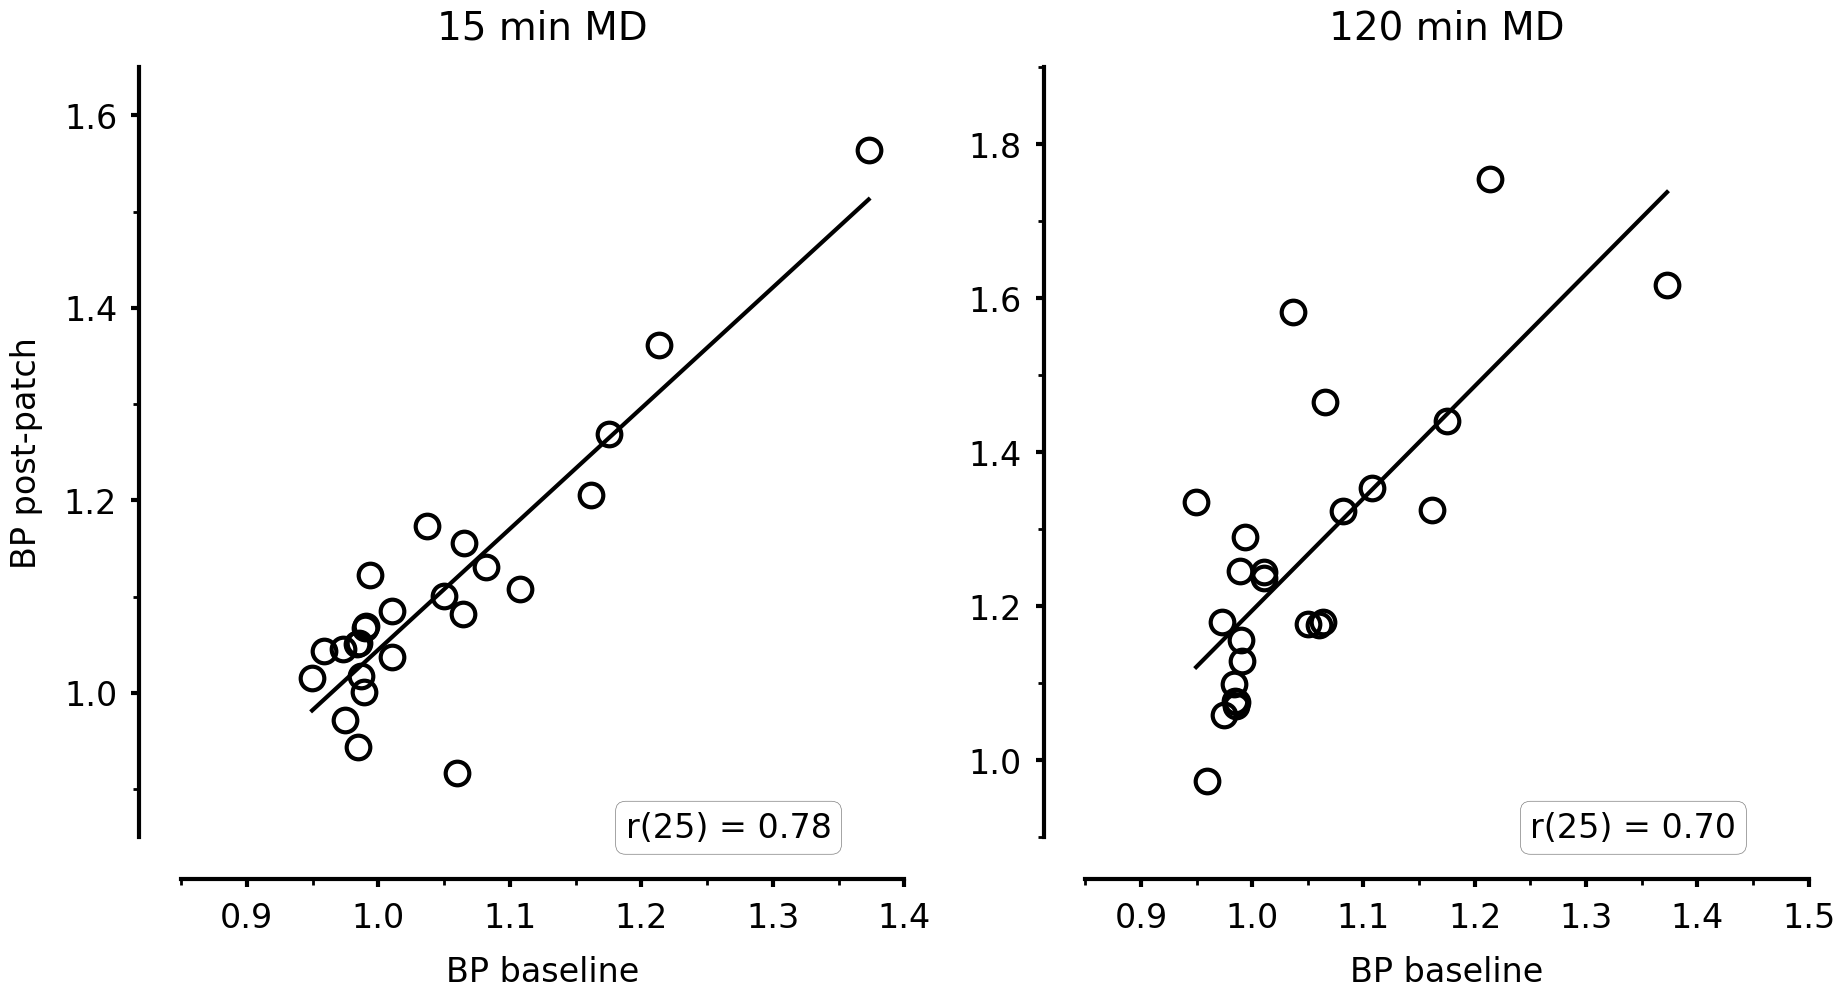

In [34]:
fig, axes = plt.subplots(1, 2, figsize=(21, 10), gridspec_kw=dict(wspace=0.25))
# fig.suptitle("Binocular combination", fontsize=28)
ax_15, ax_120 = axes[0], axes[1]

ax_15.set_title("15 min MD", fontsize=28, pad=20), ax_120.set_title("120 min MD", fontsize=28, pad=20)
ax_15.set_ylabel("BP post-patch", fontsize=24, labelpad=15), ax_15.set_xlabel("BP baseline", fontsize=24, labelpad=15), ax_120.set_xlabel("BP baseline", fontsize=24, labelpad=15)

for ax in axes:
    ax.spines[["top","right"]].set_visible(False)
    ax.spines[["bottom", "left"]].set_linewidth(3)
    ax.tick_params(length=6, width=3, pad=10, labelsize=24)
    ax.tick_params(which="minor", length = 4, width = 2)
    ax.spines[["left", "bottom"]].set_position(("outward", 30))

ax_15.xaxis.set_major_locator(MultipleLocator(base=0.1)), ax_15.xaxis.set_minor_locator(MultipleLocator(base=0.05))
ax_15.yaxis.set_major_locator(MultipleLocator(base=0.2)), ax_15.yaxis.set_minor_locator(MultipleLocator(base=0.1))

ax_15.set_xlim(0.85, 1.4)
ax_15.set_ylim(0.85, 1.65)

ax_120.xaxis.set_major_locator(MultipleLocator(base=0.1)), ax_120.xaxis.set_minor_locator(MultipleLocator(base=0.05))
ax_120.yaxis.set_major_locator(MultipleLocator(base=0.2)), ax_120.yaxis.set_minor_locator(MultipleLocator(base=0.1))

ax_120.set_xlim(0.85, 1.5)
ax_120.set_ylim(0.9, 1.9)

ax_15.plot(
    combination_raw_rearranged[baseline_columns].mean(axis=1),
    vertical_raw_df["15min"]["combination"].drop("baseline_15min", axis=1).mean(axis=1),
    color = "k",
    marker="o",
    ms = 17,
    fillstyle="none",
    ls="",
    mew = 3
)

ax_120.plot(
    combination_raw_rearranged[baseline_columns].mean(axis=1),
    vertical_raw_df["120min"]["combination"].drop("baseline_120min", axis=1).mean(axis=1),
    color = "k",
    marker="o",
    ms = 17,
    fillstyle="none",
    ls="",
    mew = 3
)

corr, p = spearmanr(combination_raw_rearranged[baseline_columns].mean(axis=1), vertical_raw_df["15min"]["combination"].drop("baseline_15min", axis=1).mean(axis=1))
print(f"Correlation 15min: r={corr}, p={p}")
sig_level = anf.significance_level(p)
# ax_15.text(1.188, 0.85, f"r(25) = {corr:.2f}, p = {p:.6f}", fontsize=24, bbox={"boxstyle":"round","facecolor":"white","lw":.5,"edgecolor":"grey"})
ax_15.text(1.188, 0.85, f"r(25) = {corr:.2f}", fontsize=24, bbox={"boxstyle":"round","facecolor":"white","lw":.5,"edgecolor":"grey"})


# Linear fit
linear_regression = linregress(combination_raw_rearranged[baseline_columns].mean(axis=1), vertical_raw_df["15min"]["combination"].drop("baseline_15min", axis=1).mean(axis=1))
regression_line_span = np.linspace(min(combination_raw_rearranged[baseline_columns].mean(axis=1)), max(combination_raw_rearranged[baseline_columns].mean(axis=1)))
ax_15.plot(
    regression_line_span,
    linear_regression.intercept + linear_regression.slope * regression_line_span,
    color = "k",
    lw=3
)

corr, p = spearmanr(combination_raw_rearranged[baseline_columns].mean(axis=1), vertical_raw_df["120min"]["combination"].drop("baseline_120min", axis=1).mean(axis=1))
print(f"Correlation 120min: r={corr}, p={p}")
sig_level = anf.significance_level(p)
# ax_120.text(1.25, 0.9, f"r(25) = {corr:.2f}, p = {p:.6f}", fontsize=24, bbox={"boxstyle":"round","facecolor":"white","lw":.5,"edgecolor":"grey"})
ax_120.text(1.25, 0.9, f"r(25) = {corr:.2f}", fontsize=24, bbox={"boxstyle":"round","facecolor":"white","lw":.5,"edgecolor":"grey"})

linear_regression = linregress(combination_raw_rearranged[baseline_columns].mean(axis=1), vertical_raw_df["120min"]["combination"].drop("baseline_120min", axis=1).mean(axis=1))
regression_line_span = np.linspace(min(combination_raw_rearranged[baseline_columns].mean(axis=1)), max(combination_raw_rearranged[baseline_columns].mean(axis=1)))
ax_120.plot(
    regression_line_span,
    linear_regression.intercept + linear_regression.slope * regression_line_span,
    color = "k",
    lw=3
)

fig.savefig(os.path.join(images_dir, "correlation_baseline_postpatch_bc_review.png"))

### Baseline vs MD effect

#### Rivalry

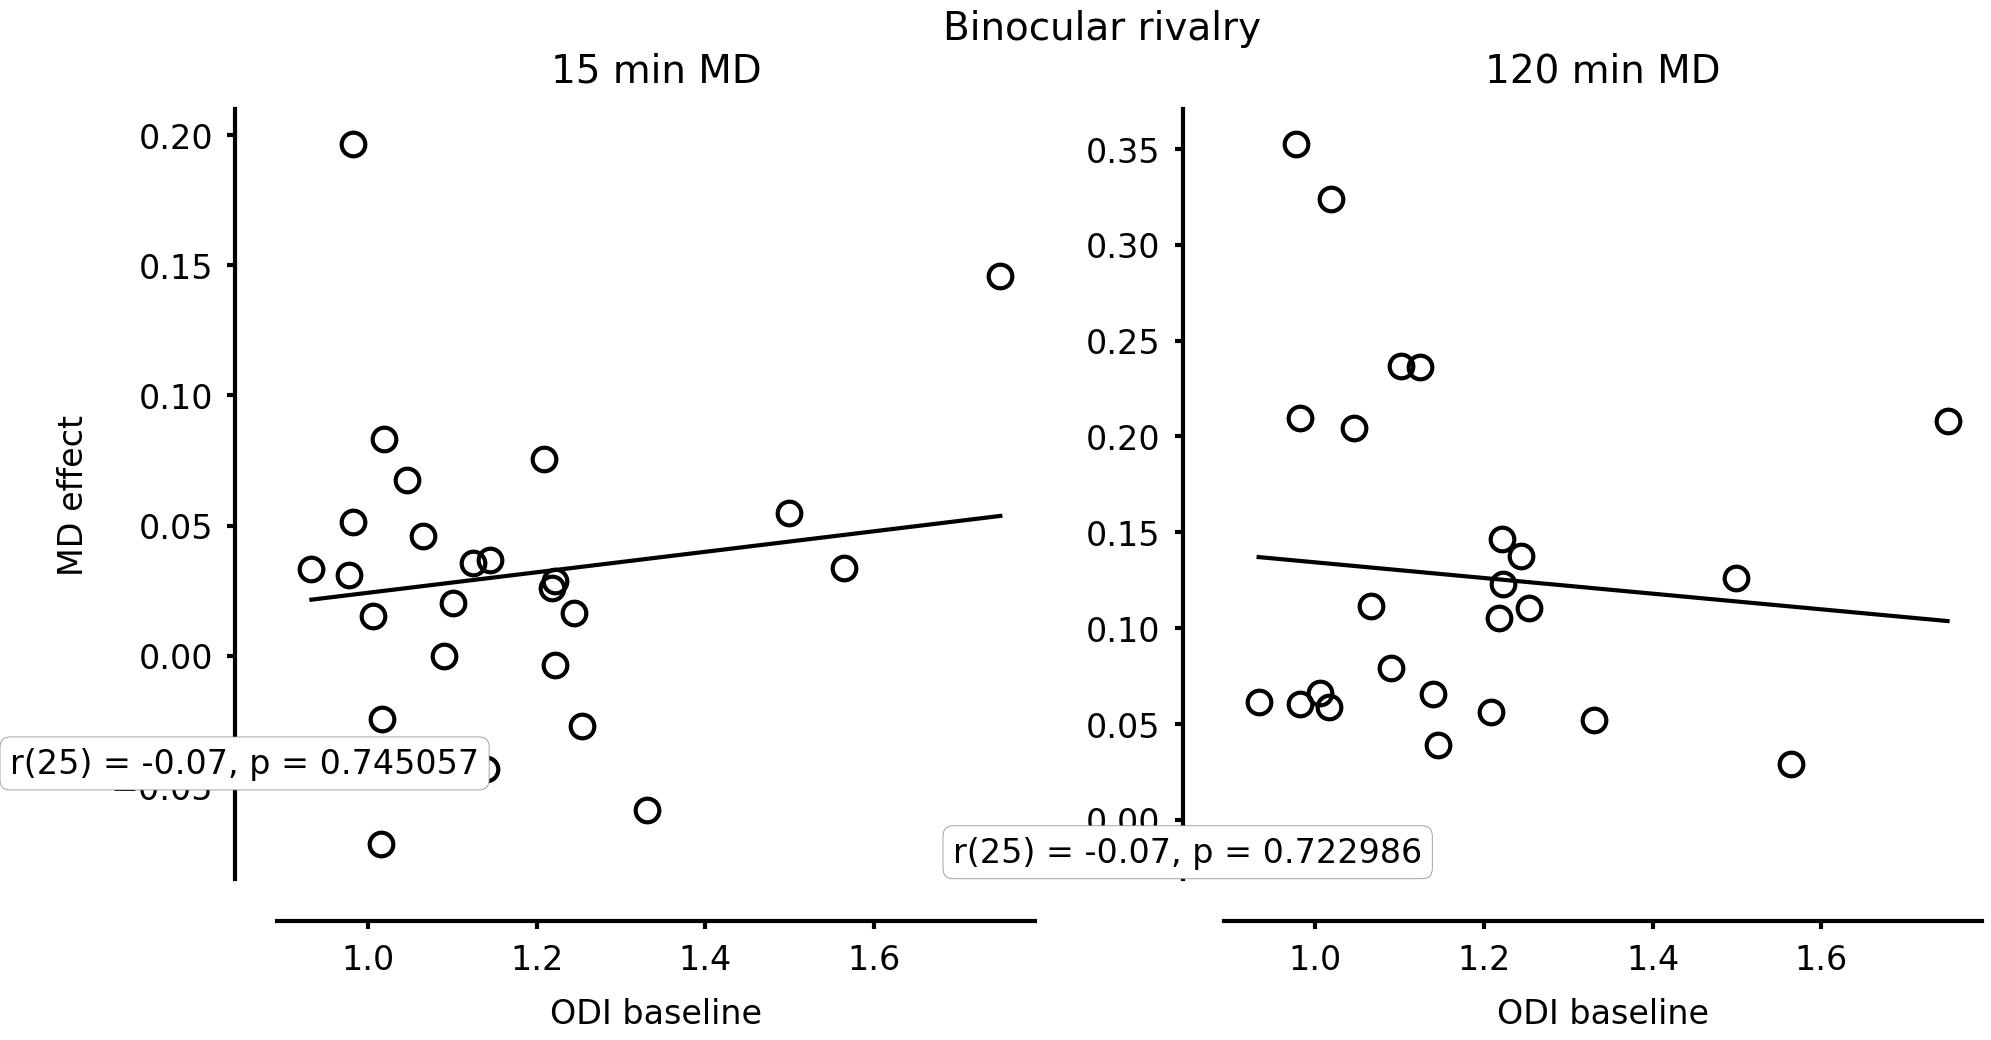

In [35]:
fig, axes = plt.subplots(1, 2, figsize=(22, 10), gridspec_kw=dict(wspace=0.25))
fig.suptitle("Binocular rivalry", fontsize=28)
ax_15, ax_120 = axes[0], axes[1]

ax_15.set_title("15 min MD", fontsize=28, pad=20), ax_120.set_title("120 min MD", fontsize=28, pad=20)
ax_15.set_ylabel("MD effect", fontsize=24, labelpad=15), ax_15.set_xlabel("ODI baseline", fontsize=24, labelpad=15), ax_120.set_xlabel("ODI baseline", fontsize=24, labelpad=15)

for ax in axes:
    ax.spines[["top","right"]].set_visible(False)
    ax.spines[["bottom", "left"]].set_linewidth(3)
    ax.tick_params(length=6, width=3, pad=10, labelsize=24)
    ax.tick_params(which="minor", length = 4, width = 2)
    ax.spines[["left", "bottom"]].set_position(("outward", 30))

# ax_15.xaxis.set_major_locator(MultipleLocator(base=0.05)), ax_15.xaxis.set_minor_locator(MultipleLocator(base=0.025))
# ax_15.yaxis.set_major_locator(MultipleLocator(base=0.02)), ax_15.yaxis.set_minor_locator(MultipleLocator(base=0.01))

# ax_120.xaxis.set_major_locator(MultipleLocator(base=0.05)), ax_120.xaxis.set_minor_locator(MultipleLocator(base=0.025))
# ax_120.yaxis.set_major_locator(MultipleLocator(base=0.04)), ax_120.yaxis.set_minor_locator(MultipleLocator(base=0.02))

# ax_120.set_xlim(0.45, 0.65)
# ax_120.set_ylim(-0.02, 0.14)

ax_15.plot(
    rivalry_raw_rearranged[baseline_columns].mean(axis=1),
    arithmetic_mean_effect["15min"]["rivalry"],
    color = "k",
    marker="o",
    ms = 17,
    fillstyle="none",
    ls="",
    mew = 3
)

ax_120.plot(
    rivalry_raw_rearranged[baseline_columns].mean(axis=1),
    arithmetic_mean_effect["120min"]["rivalry"],
    color = "k",
    marker="o",
    ms = 17,
    fillstyle="none",
    ls="",
    mew = 3
)

corr, p = spearmanr(rivalry_raw_rearranged[baseline_columns].mean(axis=1), arithmetic_mean_effect["15min"]["rivalry"])
ax_15.text(0.575, -0.045, f"r(25) = {corr:.2f}, p = {p:.6f}", fontsize=24, bbox={"boxstyle":"round","facecolor":"white","lw":.5,"edgecolor":"grey"})
# ax_15.text(0.575, -0.045, f"r(25) = {corr:.2f}" + r"$^{ns}$", fontsize=24, bbox={"boxstyle":"round","facecolor":"white","lw":.5,"edgecolor":"grey"})


# Linear fit
linear_regression = linregress(rivalry_raw_rearranged[baseline_columns].mean(axis=1), arithmetic_mean_effect["15min"]["rivalry"])
regression_line_span = np.linspace(min(rivalry_raw_rearranged[baseline_columns].mean(axis=1)), max(rivalry_raw_rearranged[baseline_columns].mean(axis=1)))
ax_15.plot(
    regression_line_span,
    linear_regression.intercept + linear_regression.slope * regression_line_span,
    color = "k",
    lw=3
)

corr, p = spearmanr(rivalry_raw_rearranged[baseline_columns].mean(axis=1), arithmetic_mean_effect["120min"]["rivalry"])
ax_120.text(0.57, -0.022, f"r(25) = {corr:.2f}, p = {p:.6f}", fontsize=24, bbox={"boxstyle":"round","facecolor":"white","lw":.5,"edgecolor":"grey"})
# ax_120.text(0.57, -0.022, f"r(25) = {corr:.2f}" + r"$^{ns}$", fontsize=24, bbox={"boxstyle":"round","facecolor":"white","lw":.5,"edgecolor":"grey"})
linear_regression = linregress(rivalry_raw_rearranged[baseline_columns].mean(axis=1), arithmetic_mean_effect["120min"]["rivalry"])
regression_line_span = np.linspace(min(rivalry_raw_rearranged[baseline_columns].mean(axis=1)), max(rivalry_raw_rearranged[baseline_columns].mean(axis=1)))
ax_120.plot(
    regression_line_span,
    linear_regression.intercept + linear_regression.slope * regression_line_span,
    color = "k",
    lw=3
)

fig.savefig(os.path.join(images_dir, "correlation_baseline_postpatch_effect_br_review.png"))

#### Combination

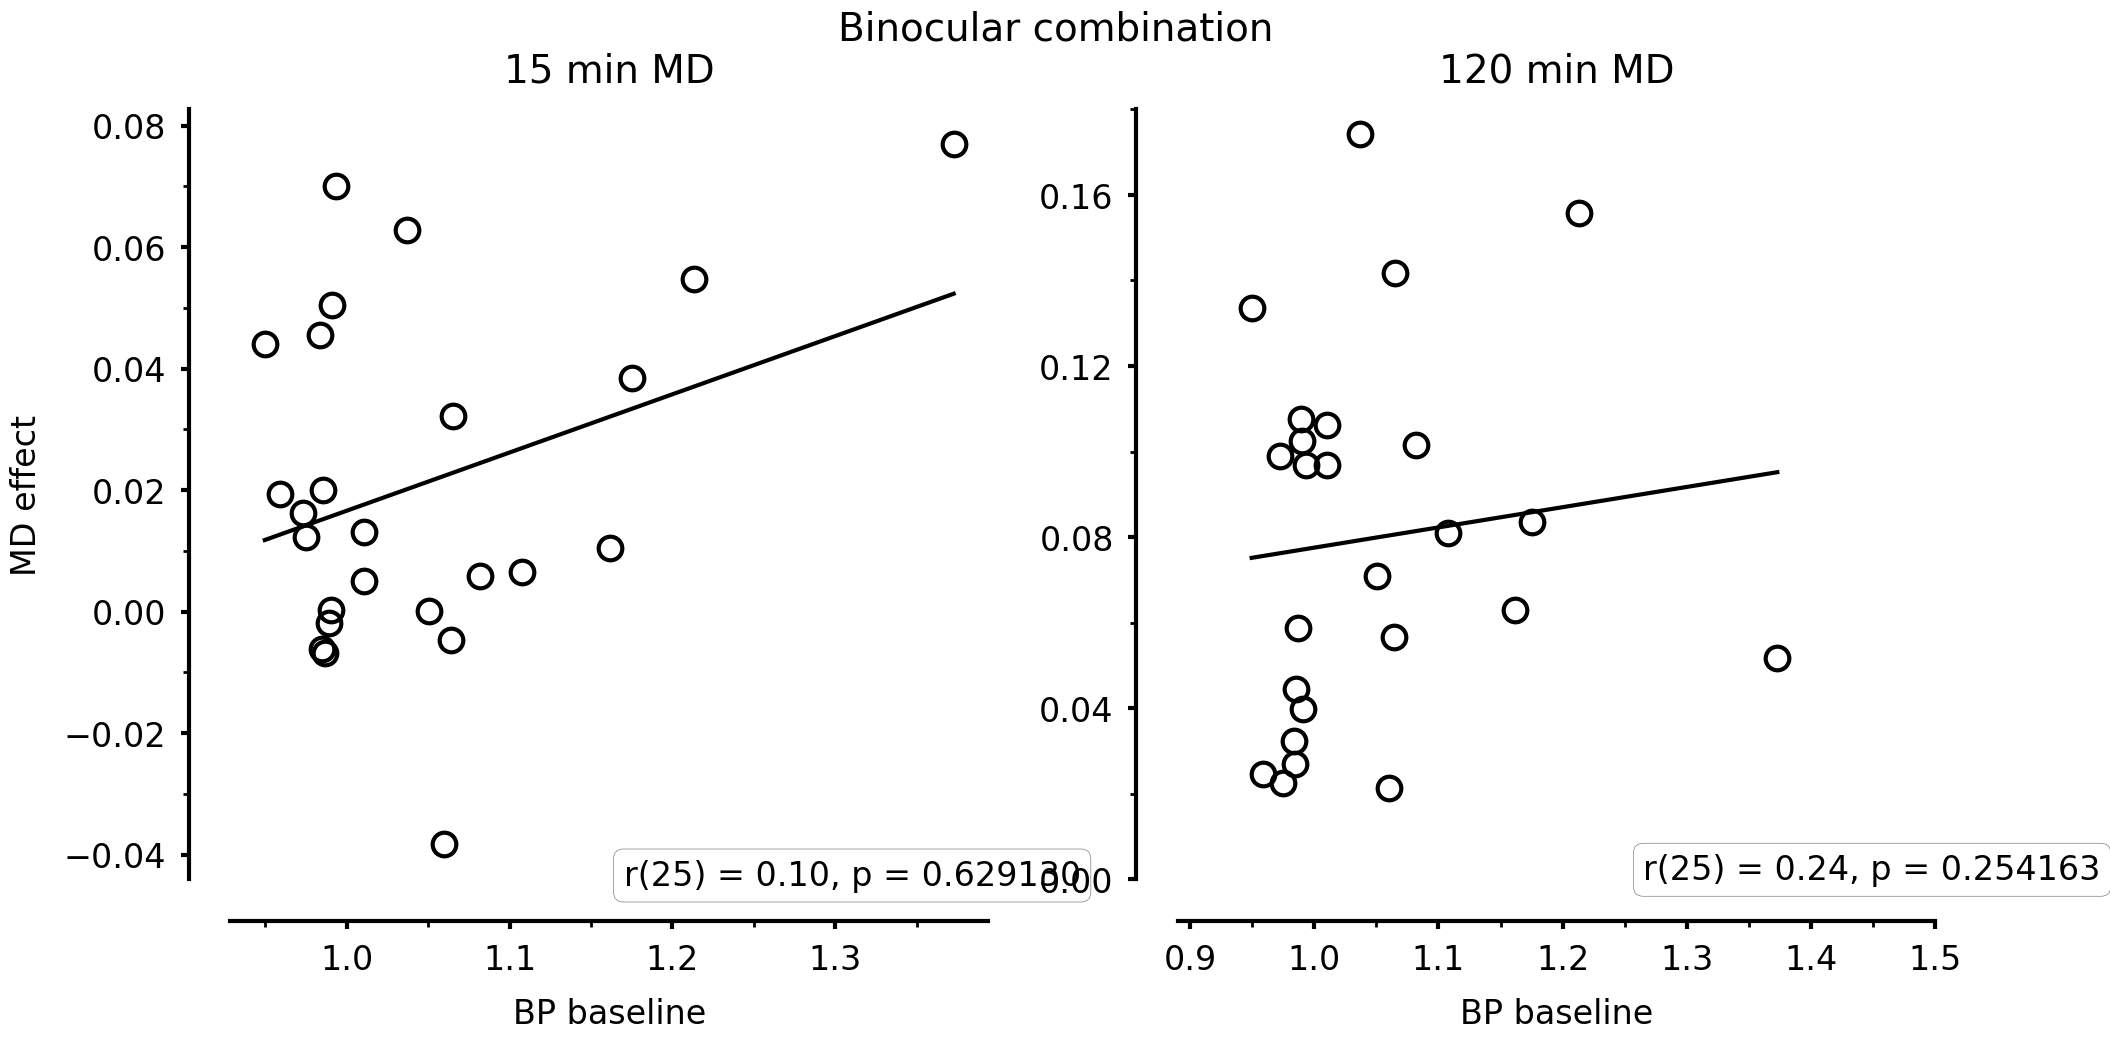

In [36]:
fig, axes = plt.subplots(1, 2, figsize=(22, 10), gridspec_kw=dict(wspace=0.25))
fig.suptitle("Binocular combination", fontsize=28)
ax_15, ax_120 = axes[0], axes[1]

ax_15.set_title("15 min MD", fontsize=28, pad=20), ax_120.set_title("120 min MD", fontsize=28, pad=20)
ax_15.set_ylabel("MD effect", fontsize=24, labelpad=15), ax_15.set_xlabel("BP baseline", fontsize=24, labelpad=15), ax_120.set_xlabel("BP baseline", fontsize=24, labelpad=15)

for ax in axes:
    ax.spines[["top","right"]].set_visible(False)
    ax.spines[["bottom", "left"]].set_linewidth(3)
    ax.tick_params(length=6, width=3, pad=10, labelsize=24)
    ax.tick_params(which="minor", length = 4, width = 2)
    ax.spines[["left", "bottom"]].set_position(("outward", 30))

ax_15.xaxis.set_major_locator(MultipleLocator(base=0.1)), ax_15.xaxis.set_minor_locator(MultipleLocator(base=0.05))
ax_15.yaxis.set_major_locator(MultipleLocator(base=0.02)), ax_15.yaxis.set_minor_locator(MultipleLocator(base=0.01))

ax_120.set_xlim(0.89, 1.42)
ax_120.set_ylim(-0.05, 0.1)

ax_120.xaxis.set_major_locator(MultipleLocator(base=0.1)), ax_120.xaxis.set_minor_locator(MultipleLocator(base=0.05))
ax_120.yaxis.set_major_locator(MultipleLocator(base=0.04)), ax_120.yaxis.set_minor_locator(MultipleLocator(base=0.02))

ax_120.set_xlim(0.89, 1.5)
ax_120.set_ylim(0, 0.18)

ax_15.plot(
    combination_raw_rearranged[baseline_columns].mean(axis=1),
    arithmetic_mean_effect["15min"]["combination"],
    color = "k",
    marker="o",
    ms = 17,
    fillstyle="none",
    ls="",
    mew = 3
)

ax_120.plot(
    combination_raw_rearranged[baseline_columns].mean(axis=1),
    arithmetic_mean_effect["120min"]["combination"],
    color = "k",
    marker="o",
    ms = 17,
    fillstyle="none",
    ls="",
    mew = 3
)

corr, p = spearmanr(combination_raw_rearranged[baseline_columns].mean(axis=1), arithmetic_mean_effect["15min"]["combination"])
ax_15.text(1.17, -0.045, f"r(25) = {corr:.2f}, p = {p:.6f}", fontsize=24, bbox={"boxstyle":"round","facecolor":"white","lw":.5,"edgecolor":"grey"})
# ax_15.text(1.17, -0.045, f"r(25) = {corr:.2f}" + r"$^{ns}$", fontsize=24, bbox={"boxstyle":"round","facecolor":"white","lw":.5,"edgecolor":"grey"})

# Linear fit
linear_regression = linregress(combination_raw_rearranged[baseline_columns].mean(axis=1), arithmetic_mean_effect["15min"]["combination"])
regression_line_span = np.linspace(min(combination_raw_rearranged[baseline_columns].mean(axis=1)), max(combination_raw_rearranged[baseline_columns].mean(axis=1)))
ax_15.plot(
    regression_line_span,
    linear_regression.intercept + linear_regression.slope * regression_line_span,
    color = "k",
    lw=3
)

corr, p = spearmanr(combination_raw_rearranged[baseline_columns].mean(axis=1), arithmetic_mean_effect["120min"]["combination"])
ax_120.text(1.265, 0, f"r(25) = {corr:.2f}, p = {p:.6f}", fontsize=24, bbox={"boxstyle":"round","facecolor":"white","lw":.5,"edgecolor":"grey"})
# ax_120.text(1.265, 0, f"r(25) = {corr:.2f}" + r"$^{ns}$", fontsize=24, bbox={"boxstyle":"round","facecolor":"white","lw":.5,"edgecolor":"grey"})
linear_regression = linregress(combination_raw_rearranged[baseline_columns].mean(axis=1), arithmetic_mean_effect["120min"]["combination"])
regression_line_span = np.linspace(min(combination_raw_rearranged[baseline_columns].mean(axis=1)), max(combination_raw_rearranged[baseline_columns].mean(axis=1)))
ax_120.plot(
    regression_line_span,
    linear_regression.intercept + linear_regression.slope * regression_line_span,
    color = "k",
    lw=3
)

fig.savefig(os.path.join(images_dir, "correlation_baseline_postpatch_effects_bc_review.png"))

## Variance in our measurements and effects

In [37]:
postpatch_sessions_15, postpatch_sessions_120 = [s+"_15min" for s in postpatch_sessions], [s+"_120min" for s in postpatch_sessions]

In [38]:
print("var of log(ODI)")
var_df = pd.DataFrame(index = pd.MultiIndex.from_product([["rivalry", "combination"],deprivation_durations]), columns= ["baseline", "postpatch1", "sum_of_var", "effect", "var_of_logsum", "var_of_logdiff"])

var_df.loc[("rivalry", "15min"),"baseline"], var_df.loc[("rivalry", "120min"),"baseline"] = np.divide(rivalry_raw_rearranged.loc[participant_list, baseline_columns].apply(np.log10).var().values, np.abs(rivalry_raw_rearranged.loc[participant_list, baseline_columns].apply(np.log10).mean().values))
var_df.loc[("rivalry", "15min"),"postpatch1"], var_df.loc[("rivalry", "120min"),"postpatch1"] = np.divide(rivalry_raw_rearranged.loc[participant_list, ["postpatch1_15min", "postpatch1_120min"]].apply(np.log10).var().values,np.abs(rivalry_raw_rearranged.loc[participant_list, ["postpatch1_15min", "postpatch1_120min"]].apply(np.log10).mean().values))

var_df.loc[("rivalry", "15min"),"sum_of_var"] = var_df.loc[("rivalry", "15min"),"baseline"] + var_df.loc[("rivalry", "15min"),"postpatch1"]
var_df.loc[("rivalry", "120min"),"sum_of_var"] = var_df.loc[("rivalry", "120min"),"baseline"] + var_df.loc[("rivalry", "120min"),"postpatch1"]

var_df.loc[("rivalry", "15min"),"effect"], var_df.loc[("rivalry", "120min"),"effect"] = np.divide(rivalry_effects_rearranged.loc[participant_list, ["postpatch1_15min", "postpatch1_120min"]].var().values, rivalry_effects_rearranged.loc[participant_list, ["postpatch1_15min", "postpatch1_120min"]].mean().values)

var_df.loc[("rivalry", "15min"),"var_of_logsum"] = (rivalry_raw_rearranged.loc[participant_list,"postpatch1_15min"].apply(np.log10) + rivalry_raw_rearranged.loc[participant_list,"baseline_15min"].apply(np.log10)).var()
var_df.loc[("rivalry", "120min"),"var_of_logsum"] = (rivalry_raw_rearranged.loc[participant_list,"postpatch1_120min"].apply(np.log10) + rivalry_raw_rearranged.loc[participant_list,"baseline_120min"].apply(np.log10)).var()
var_df.loc[("rivalry", "15min"),"var_of_logdiff"] = (rivalry_raw_rearranged.loc[participant_list,"postpatch1_15min"].apply(np.log10) - rivalry_raw_rearranged.loc[participant_list,"baseline_15min"].apply(np.log10)).var()
var_df.loc[("rivalry", "120min"),"var_of_logdiff"] = (rivalry_raw_rearranged.loc[participant_list,"postpatch1_120min"].apply(np.log10) - rivalry_raw_rearranged.loc[participant_list,"baseline_120min"].apply(np.log10)).var()

var_df.loc[("combination", "15min"),"baseline"], var_df.loc[("combination", "120min"),"baseline"] = np.divide(combination_raw_rearranged.loc[participant_list, baseline_columns].apply(np.log10).var().values, np.abs(combination_raw_rearranged.loc[participant_list, baseline_columns].apply(np.log10).mean().values))
var_df.loc[("combination", "15min"),"postpatch1"], var_df.loc[("combination", "120min"),"postpatch1"] = np.divide(combination_raw_rearranged.loc[participant_list, ["postpatch1_15min", "postpatch1_120min"]].apply(np.log10).var().values,np.abs(combination_raw_rearranged.loc[participant_list, ["postpatch1_15min", "postpatch1_120min"]].apply(np.log10).mean().values))

var_df.loc[("combination", "15min"),"sum_of_var"] = var_df.loc[("combination", "15min"),"baseline"] + var_df.loc[("combination", "15min"),"postpatch1"]
var_df.loc[("combination", "120min"),"sum_of_var"] = var_df.loc[("combination", "120min"),"baseline"] + var_df.loc[("combination", "120min"),"postpatch1"]

var_df.loc[("combination", "15min"),"effect"], var_df.loc[("combination", "120min"),"effect"] = np.divide(combination_effects_rearranged.loc[participant_list, ["postpatch1_15min", "postpatch1_120min"]].var().values, combination_effects_rearranged.loc[participant_list, ["postpatch1_15min", "postpatch1_120min"]].mean().values)

var_df.loc[("combination", "15min"),"var_of_logsum"] = (combination_raw_rearranged.loc[participant_list,"postpatch1_15min"].apply(np.log10) + combination_raw_rearranged.loc[participant_list,"baseline_15min"].apply(np.log10)).var()
var_df.loc[("combination", "120min"),"var_of_logsum"] = (combination_raw_rearranged.loc[participant_list,"postpatch1_120min"].apply(np.log10) + combination_raw_rearranged.loc[participant_list,"baseline_120min"].apply(np.log10)).var()
var_df.loc[("combination", "15min"),"var_of_logdiff"] = (combination_raw_rearranged.loc[participant_list,"postpatch1_15min"].apply(np.log10) - combination_raw_rearranged.loc[participant_list,"baseline_15min"].apply(np.log10)).var()
var_df.loc[("combination", "120min"),"var_of_logdiff"] = (combination_raw_rearranged.loc[participant_list,"postpatch1_120min"].apply(np.log10) - combination_raw_rearranged.loc[participant_list,"baseline_120min"].apply(np.log10)).var()

var_df

var of log(ODI)


baseline postpatch1 sum_of_var    effect var_of_logsum  \
rivalry     15min   0.077711   0.112169    0.18988  0.122504      0.033073   
            120min  0.105216   0.096855   0.202072  0.109687      0.040317   
combination 15min   0.074415   0.066865    0.14128  0.059453       0.00836   
            120min  0.114266   0.043612   0.157878  0.036077      0.012389   

                   var_of_logdiff  
rivalry     15min        0.009497  
            120min       0.023855  
combination 15min        0.002424  
            120min       0.004948

In [39]:
print("std of log(ODI)")
std_df = pd.DataFrame(index = pd.MultiIndex.from_product([["rivalry", "combination"],deprivation_durations]), columns= ["baseline", "postpatch1", "sum_of_std", "effect", "std_of_logsum", "std_of_logdiff"])

std_df.loc[("rivalry", "15min"),"baseline"], std_df.loc[("rivalry", "120min"),"baseline"] = np.divide(rivalry_raw_rearranged.loc[participant_list, baseline_columns].apply(np.log10).std().values, np.abs(rivalry_raw_rearranged.loc[participant_list, baseline_columns].apply(np.log10).mean().values))
std_df.loc[("rivalry", "15min"),"postpatch1"], std_df.loc[("rivalry", "120min"),"postpatch1"] = np.divide(rivalry_raw_rearranged.loc[participant_list, ["postpatch1_15min", "postpatch1_120min"]].apply(np.log10).std().values,np.abs(rivalry_raw_rearranged.loc[participant_list, ["postpatch1_15min", "postpatch1_120min"]].apply(np.log10).mean().values))

std_df.loc[("rivalry", "15min"),"sum_of_std"] = std_df.loc[("rivalry", "15min"),"baseline"] + std_df.loc[("rivalry", "15min"),"postpatch1"]
std_df.loc[("rivalry", "120min"),"sum_of_std"] = std_df.loc[("rivalry", "120min"),"baseline"] + std_df.loc[("rivalry", "120min"),"postpatch1"]

std_df.loc[("rivalry", "15min"),"effect"], std_df.loc[("rivalry", "120min"),"effect"] = np.divide(rivalry_effects_rearranged.loc[participant_list, ["postpatch1_15min", "postpatch1_120min"]].std().values, rivalry_effects_rearranged.loc[participant_list, ["postpatch1_15min", "postpatch1_120min"]].mean().values)

std_df.loc[("rivalry", "15min"),"std_of_logsum"] = (rivalry_raw_rearranged.loc[participant_list,"postpatch1_15min"].apply(np.log10) + rivalry_raw_rearranged.loc[participant_list,"baseline_15min"].apply(np.log10)).std()
std_df.loc[("rivalry", "120min"),"std_of_logsum"] = (rivalry_raw_rearranged.loc[participant_list,"postpatch1_120min"].apply(np.log10) + rivalry_raw_rearranged.loc[participant_list,"baseline_120min"].apply(np.log10)).std()
std_df.loc[("rivalry", "15min"),"std_of_logdiff"] = (rivalry_raw_rearranged.loc[participant_list,"postpatch1_15min"].apply(np.log10) - rivalry_raw_rearranged.loc[participant_list,"baseline_15min"].apply(np.log10)).std()
std_df.loc[("rivalry", "120min"),"std_of_logdiff"] = (rivalry_raw_rearranged.loc[participant_list,"postpatch1_120min"].apply(np.log10) - rivalry_raw_rearranged.loc[participant_list,"baseline_120min"].apply(np.log10)).std()

std_df.loc[("combination", "15min"),"baseline"], std_df.loc[("combination", "120min"),"baseline"] = np.divide(combination_raw_rearranged.loc[participant_list, baseline_columns].apply(np.log10).std().values, combination_raw_rearranged.loc[participant_list, baseline_columns].apply(np.log10).mean().values)
std_df.loc[("combination", "15min"),"postpatch1"], std_df.loc[("combination", "120min"),"postpatch1"] = np.divide(combination_raw_rearranged.loc[participant_list, ["postpatch1_15min", "postpatch1_120min"]].apply(np.log10).std().values, combination_raw_rearranged.loc[participant_list, ["postpatch1_15min", "postpatch1_120min"]].apply(np.log10).mean().values)

std_df.loc[("combination", "15min"),"sum_of_std"] = std_df.loc[("combination", "15min"),"baseline"] + std_df.loc[("combination", "15min"),"postpatch1"]
std_df.loc[("combination", "120min"),"sum_of_std"] = std_df.loc[("combination", "120min"),"baseline"] + std_df.loc[("combination", "120min"),"postpatch1"]

std_df.loc[("combination", "15min"),"effect"], std_df.loc[("combination", "120min"),"effect"] = np.divide(combination_effects_rearranged.loc[participant_list, ["postpatch1_15min", "postpatch1_120min"]].std().values, combination_effects_rearranged.loc[participant_list, ["postpatch1_15min", "postpatch1_120min"]].mean().values)

std_df.loc[("combination", "15min"),"std_of_logsum"] = (combination_raw_rearranged.loc[participant_list,"postpatch1_15min"].apply(np.log10) + combination_raw_rearranged.loc[participant_list,"baseline_15min"].apply(np.log10)).std()
std_df.loc[("combination", "120min"),"std_of_logsum"] = (combination_raw_rearranged.loc[participant_list,"postpatch1_120min"].apply(np.log10) + combination_raw_rearranged.loc[participant_list,"baseline_120min"].apply(np.log10)).std()
std_df.loc[("combination", "15min"),"std_of_logdiff"] = np.divide((combination_raw_rearranged.loc[participant_list,"postpatch1_15min"].apply(np.log10) - combination_raw_rearranged.loc[participant_list,"baseline_15min"].apply(np.log10)).std(),(combination_raw_rearranged.loc[participant_list,"postpatch1_15min"].apply(np.log10) - combination_raw_rearranged.loc[participant_list,"baseline_15min"].apply(np.log10)).mean())
std_df.loc[("combination", "120min"),"std_of_logdiff"] = np.divide((combination_raw_rearranged.loc[participant_list,"postpatch1_120min"].apply(np.log10) - combination_raw_rearranged.loc[participant_list,"baseline_120min"].apply(np.log10)).std(),(combination_raw_rearranged.loc[participant_list,"postpatch1_120min"].apply(np.log10) - combination_raw_rearranged.loc[participant_list,"baseline_120min"].apply(np.log10)).mean())

std of log(ODI)


In [40]:
print("baseline: ", combination_raw_rearranged.loc[participant_list, baseline_columns].apply(np.log10, raw=True).var().values)
print("pp1 raw: ", combination_raw_rearranged.loc[participant_list, ["postpatch1_15min", "postpatch1_120min"]].apply(np.log10, raw=True).var().values)
print("pp1 effect: ", combination_effects_rearranged.loc[participant_list, ["postpatch1_15min", "postpatch1_120min"]].var().values)

baseline:  [0.00140429 0.00194454]
pp1 raw:  [0.00398752 0.00672385]
pp1 effect:  [0.0024236 0.0049482]


## Slopes of psychometric curves (Combination)

In [41]:
x_model = np.linspace(min(definitions.icr), max(definitions.icr)+1, 100)
x_discrete = [0.2, 0.5, 0.7, 1.0, 1.2]

In [42]:
temp_df = pd.DataFrame(index = participant_list)
temp_df["baseline"] = model_parameters_bc.loc[(participant_list,"15min", ["baseline"]), "gamma"].values
temp_df["postpatch1"] = model_parameters_bc.loc[(participant_list,"15min", ["postpatch1"]), "gamma"].values
temp_df["diff"] = temp_df["baseline"] - temp_df["postpatch1"]
temp_df["diff"].mean()
ttest_1samp(temp_df["diff"],popmean=0)

TtestResult(statistic=0.5282332631269013, pvalue=0.6021882000632823, df=24)

In [43]:
# grab the perceived phase values to show average on graph
raw_data_dir = "/Users/antoineprosper/ownCloud/Scientific papers/Paper OD plasticity BR-BC/data_included"

lst = []

for p in participant_list:
    info_participant_path = os.path.join(raw_data_dir, f"part_{p}", "info.csv")
    deprived_eye = pd.read_csv(info_participant_path, usecols=["dominant_eye"]).iloc[0]["dominant_eye"]
    data_raw = anf.load_data_combination(p, "120min", "baseline")
    data_cleaned = anf.drop_useless_pieces(data_raw)
    data_perceived_phase = anf.extract_perceived_phase(data_cleaned)
    data_pp_remapped = anf.remap_base_contrast(data_perceived_phase, deprived_eye)
    lst.append(data_pp_remapped)

lst_bc_depr = pd.DataFrame([e['bc_depr']['d+n-'].mean() for e in lst])
lst_bc_depr2 = pd.DataFrame([e['bc_depr']['d-n+'].mean() for e in lst])

pp_df = pd.concat([lst_bc_depr, -lst_bc_depr2])

mean_pp_plot_baseline = pp_df.mean()
sem_pp_plot_baseline = pp_df.sem()

In [44]:
# grab the perceived phase values to show average on graph
raw_data_dir = "/Users/antoineprosper/ownCloud/Scientific papers/Paper OD plasticity BR-BC/data_included"

lst = []

for p in participant_list:
    info_participant_path = os.path.join(raw_data_dir, f"part_{p}", "info.csv")
    deprived_eye = pd.read_csv(info_participant_path, usecols=["dominant_eye"]).iloc[0]["dominant_eye"]
    data_raw = anf.load_data_combination(p, "120min", "postpatch1")
    data_cleaned = anf.drop_useless_pieces(data_raw)
    data_perceived_phase = anf.extract_perceived_phase(data_cleaned)
    data_pp_remapped = anf.remap_base_contrast(data_perceived_phase, deprived_eye)
    lst.append(data_pp_remapped)

lst_bc_depr = pd.DataFrame([e['bc_depr']['d+n-'].mean() for e in lst])
lst_bc_depr2 = pd.DataFrame([e['bc_depr']['d-n+'].mean() for e in lst])
lst_bc_non_depr = pd.DataFrame([e['bc_non_depr']['d-n+'].mean() for e in lst])
lst_bc_non_depr2 = pd.DataFrame([e['bc_non_depr']['d+n-'].mean() for e in lst])

pp_df = pd.concat([lst_bc_depr, -lst_bc_depr2])

mean_pp_plot_pp1 = pp_df.mean()
sem_pp_plot_pp1 = pp_df.sem()

1.045372334336295
1.450830198528785


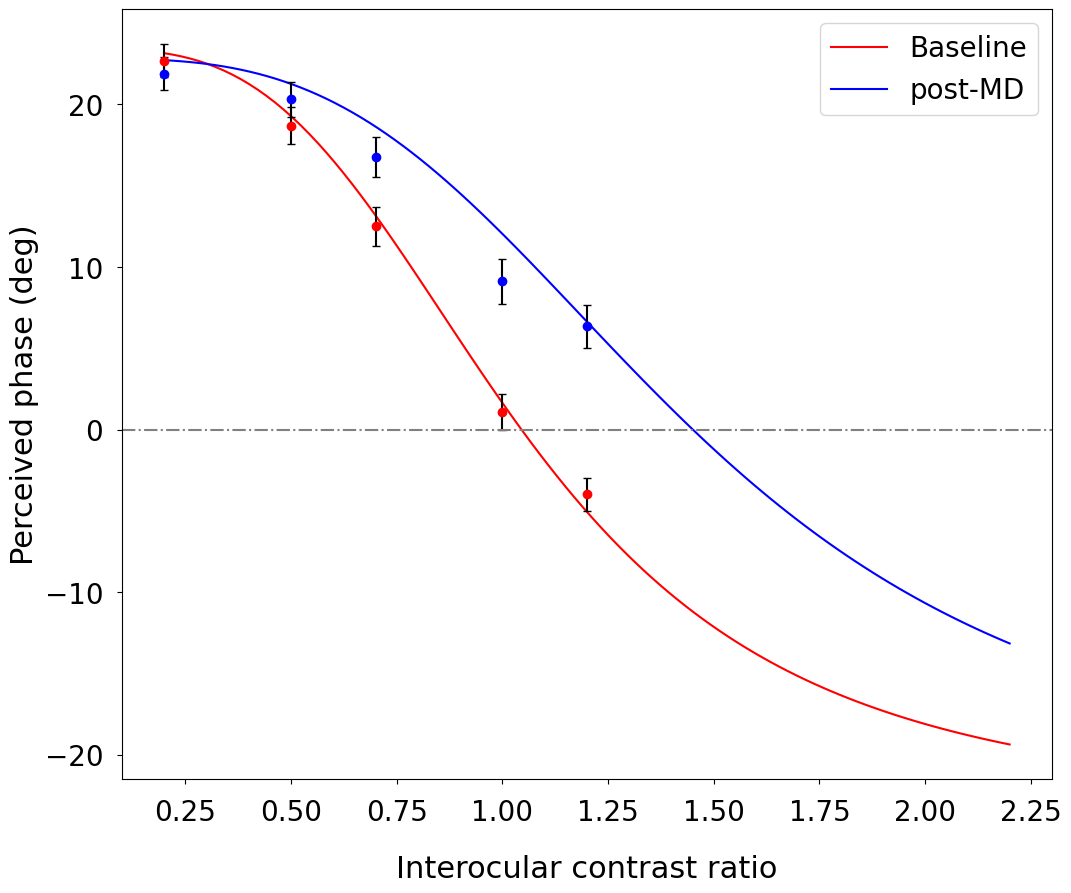

In [45]:
fig,ax=plt.subplots(figsize=(12,10))
ax.plot(
    x_model, 
    anf.phi_bc_depr(
        x_model,
        eta=model_parameters_bc.loc[(participant_list,"120min","baseline"),"eta"].mean(),
        gamma=model_parameters_bc.loc[(participant_list,"120min","baseline"),"gamma"].mean(),
        beta=model_parameters_bc.loc[(participant_list,"120min","baseline"),"beta"].mean(),
    ),
    color="r"
)
ax.plot(
    x_model, 
    anf.phi_bc_depr(
        x_model,
        eta=model_parameters_bc.loc[(participant_list,"120min","postpatch1"),"eta"].mean(),
        gamma=model_parameters_bc.loc[(participant_list,"120min","postpatch1"),"gamma"].mean(),
        beta=model_parameters_bc.loc[(participant_list,"120min","postpatch1"),"beta"].mean(),
    ),
    color="b"
)
ax.errorbar(x_discrete, mean_pp_plot_baseline, yerr=sem_pp_plot_baseline, color='r', marker='o', ls='', ecolor='k',capsize=3)
ax.errorbar(x_discrete, mean_pp_plot_pp1, yerr=sem_pp_plot_pp1, color='b', marker='o', ls='', ecolor='k',capsize=3)
ax.axhline(0, color="grey", ls='-.')
ax.set_ylabel("Perceived phase (deg)", fontsize=22), ax.set_xlabel("Interocular contrast ratio", fontsize=22, labelpad=20)
ax.tick_params(labelsize=20, pad=10)
legend_handles = [
    mpl.lines.Line2D([],[],marker="none", color="r"),
    mpl.lines.Line2D([],[],marker="none", color="b")
]
legend_labels = ["Baseline", "post-MD"]
ax.legend(legend_handles, legend_labels, loc="upper right", fontsize=20)

fig.savefig(os.path.join(images_dir, "perceived_phase_vs_contrast_avg_params_review.png"))

print(model_parameters_bc.loc[(participant_list,"120min","baseline"),"eta"].mean())
print(model_parameters_bc.loc[(participant_list,"120min","postpatch1"),"eta"].mean())

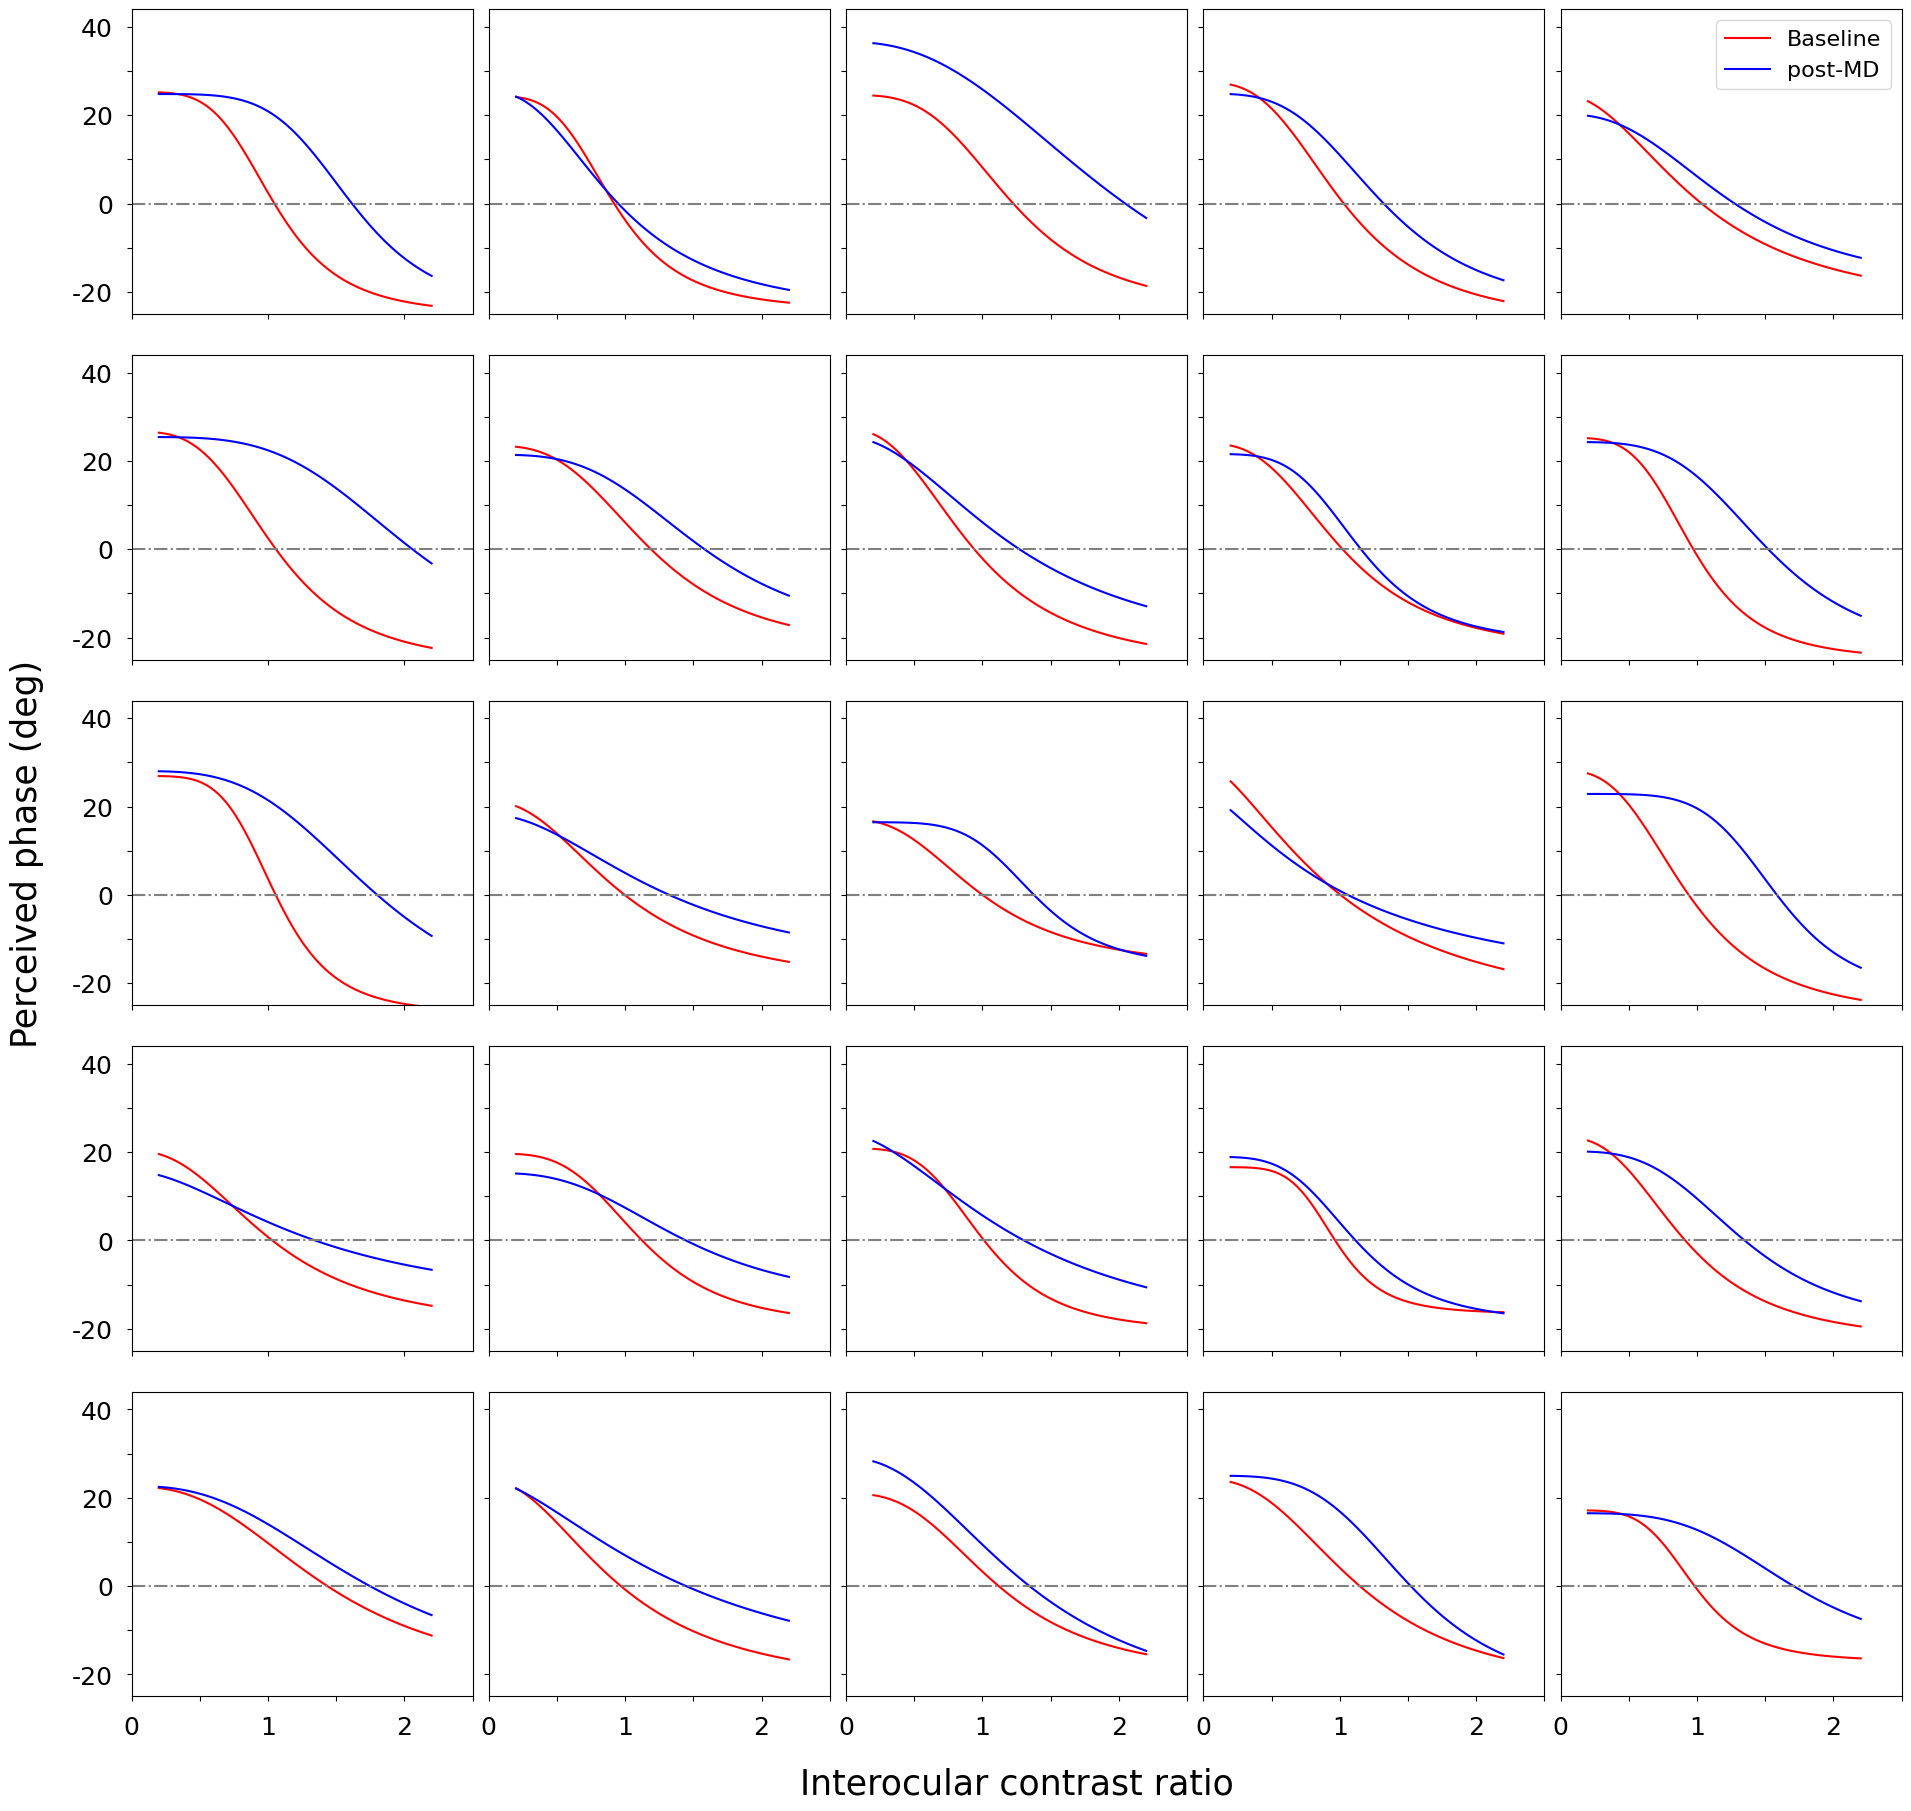

In [46]:
fig, axes = plt.subplots(5, 5, figsize = (19, 18), gridspec_kw=dict(hspace=0.1), layout="constrained")
# fig.suptitle("Baseline and postpatch1 Perceived phase vs contrast models", fontsize=24)


legend_handles = [
    mpl.lines.Line2D([],[],marker="none", color="r"),
    mpl.lines.Line2D([],[],marker="none", color="b")
]
legend_labels = ["Baseline", "post-MD"]
for i, ax in enumerate(axes.flatten()):
    ax.tick_params(labelbottom=False, labelleft=False)
    # ax.text(0.05, 40, f"S_{participant_list[i]}")
    ax.plot(
        x_model,
        anf.phi_bc_depr(
            x_model,
            eta=model_parameters_bc.loc[(participant_list[i],"120min","baseline"),"eta"],
            gamma=model_parameters_bc.loc[(participant_list[i],"120min","baseline"),"gamma"],
            beta=model_parameters_bc.loc[(participant_list[i],"120min","baseline"),"beta"],
        ),
        color="r"
    )
    ax.plot(
        x_model,
        anf.phi_bc_depr(
            x_model,
            eta=model_parameters_bc.loc[(participant_list[i], "120min", "postpatch1"), "eta"],
            gamma=model_parameters_bc.loc[(participant_list[i], "120min", "postpatch1"), "gamma"],
            beta=model_parameters_bc.loc[(participant_list[i], "120min", "postpatch1"), "beta"],
        ),
        color="b"
    )
    ax.axhline(0, ls="-.", color="gray")
    ax.set_ylim(-25,44)
    ax.set_xlim(0,2.5)

axes[0,-1].legend(legend_handles, legend_labels, loc="upper right", fontsize=16)

axes[2,0].set_ylabel("Perceived phase (deg)", fontsize=25, labelpad=20)
axes[-1,2].set_xlabel("Interocular contrast ratio", fontsize=25, labelpad=20)

for ax in axes[:,0]:
    ax.tick_params(labelleft=True, labelsize=18, pad=10)
    ax.set_yticks([-20, -10, 0, 10, 20, 30, 40])
    ax.set_yticklabels(["-20", "", "0", "", "20", "", "40"])

for ax in axes[-1,:]:
    ax.tick_params(labelbottom=True, labelsize=18, pad=10)
    ax.set_xticks([0, 0.5, 1, 1.5, 2, 2.5])
    ax.set_xticklabels(["0", "", "1", "", "2", ""])

fig.savefig(os.path.join(images_dir, "perceived_phase_vs_contrast_all_participants_review.png"))

## Mixed percept proportion (Rivalry)

In [47]:
mixed_proportion = {
    "15min":{
        "baseline":rivalry_df["mixed_proportion"].loc[(participant_list, "15min","baseline")].values,
        "postpatch1":rivalry_df["mixed_proportion"].loc[(participant_list, "15min","postpatch1")].values
    },
    "120min":{
        "baseline":rivalry_df["mixed_proportion"].loc[(participant_list, "120min","baseline")].values,
        "postpatch1":rivalry_df["mixed_proportion"].loc[(participant_list, "120min","postpatch1")].values
    }
}

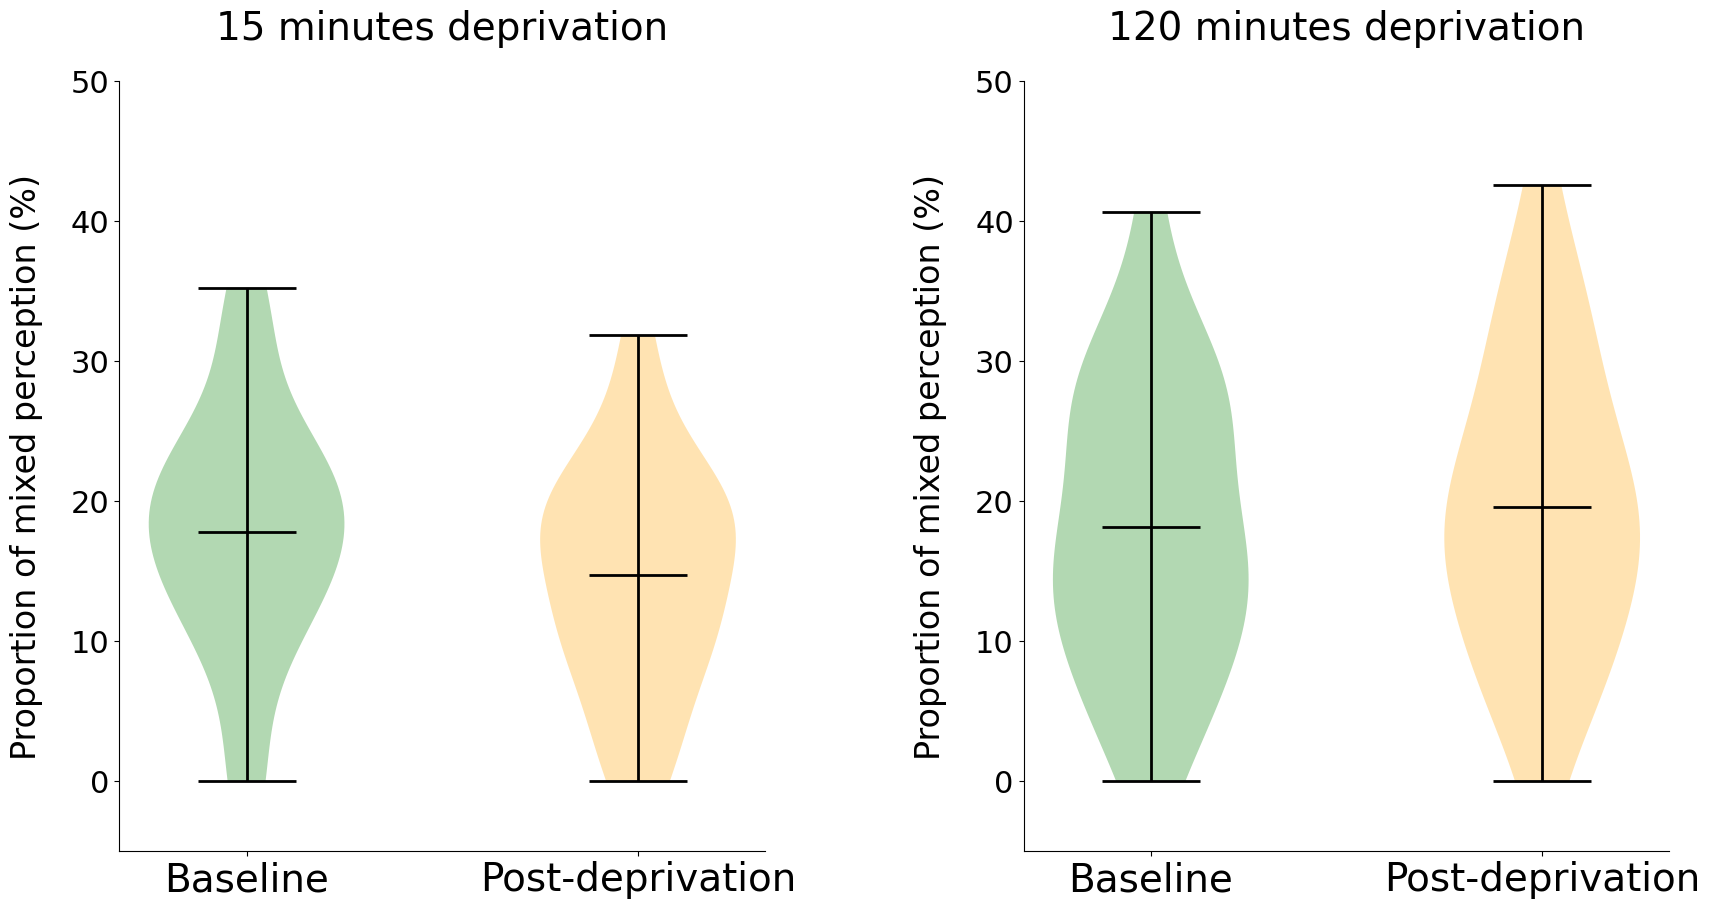

In [48]:
fig, axes = plt.subplots(1, 2, figsize=(20,10), gridspec_kw=dict(wspace=0.4))
ax_15, ax_120 = axes[0], axes[1]

ax_15.set_title("15 minutes deprivation", fontsize=28, pad=30)
ax_120.set_title("120 minutes deprivation", fontsize=28, pad=30)

for ax in axes:
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.set_xticks([0, 1])
    ax.set_xticklabels(["Baseline", "Post-deprivation"], fontsize=28)
    ax.set_yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5])
    ax.set_yticklabels(["0", "10", "20", "30", "40", "50"])
    ax.yaxis.set_tick_params(labelsize=22)
    ax.set_ylabel("Proportion of mixed perception (%)", fontsize=24, labelpad=20)
    ax.set_ylim(-0.05, 0.5)

violins_15 = ax_15.violinplot([mixed_proportion["15min"]["baseline"], mixed_proportion["15min"]["postpatch1"]], [0,1], showmeans=True)
violins_120 = ax_120.violinplot([mixed_proportion["120min"]["baseline"], mixed_proportion["120min"]["postpatch1"]], [0,1], showmeans=True)

violins_15["bodies"][0].set_facecolor("green"), violins_15["bodies"][1].set_facecolor("orange")
violins_120["bodies"][0].set_facecolor("green"), violins_120["bodies"][1].set_facecolor("orange")

violins_15["cmeans"].set(color="k", lw=2), violins_15["cbars"].set(color="k", lw=2)
violins_15["cmaxes"].set(color="k", lw=2), violins_15["cmins"].set(color="k", lw=2)

violins_120["cmeans"].set(color="k", lw=2), violins_120["cbars"].set(color="k", lw=2)
violins_120["cmaxes"].set(color="k", lw=2), violins_120["cmins"].set(color="k", lw=2)

plt.show()

### MD effect vs mixed proportion

Correlation 15min: r=-0.6038461538461538, p=0.0013923599470476561
Correlation 120min: r=-0.27692307692307694, p=0.1802089385790167


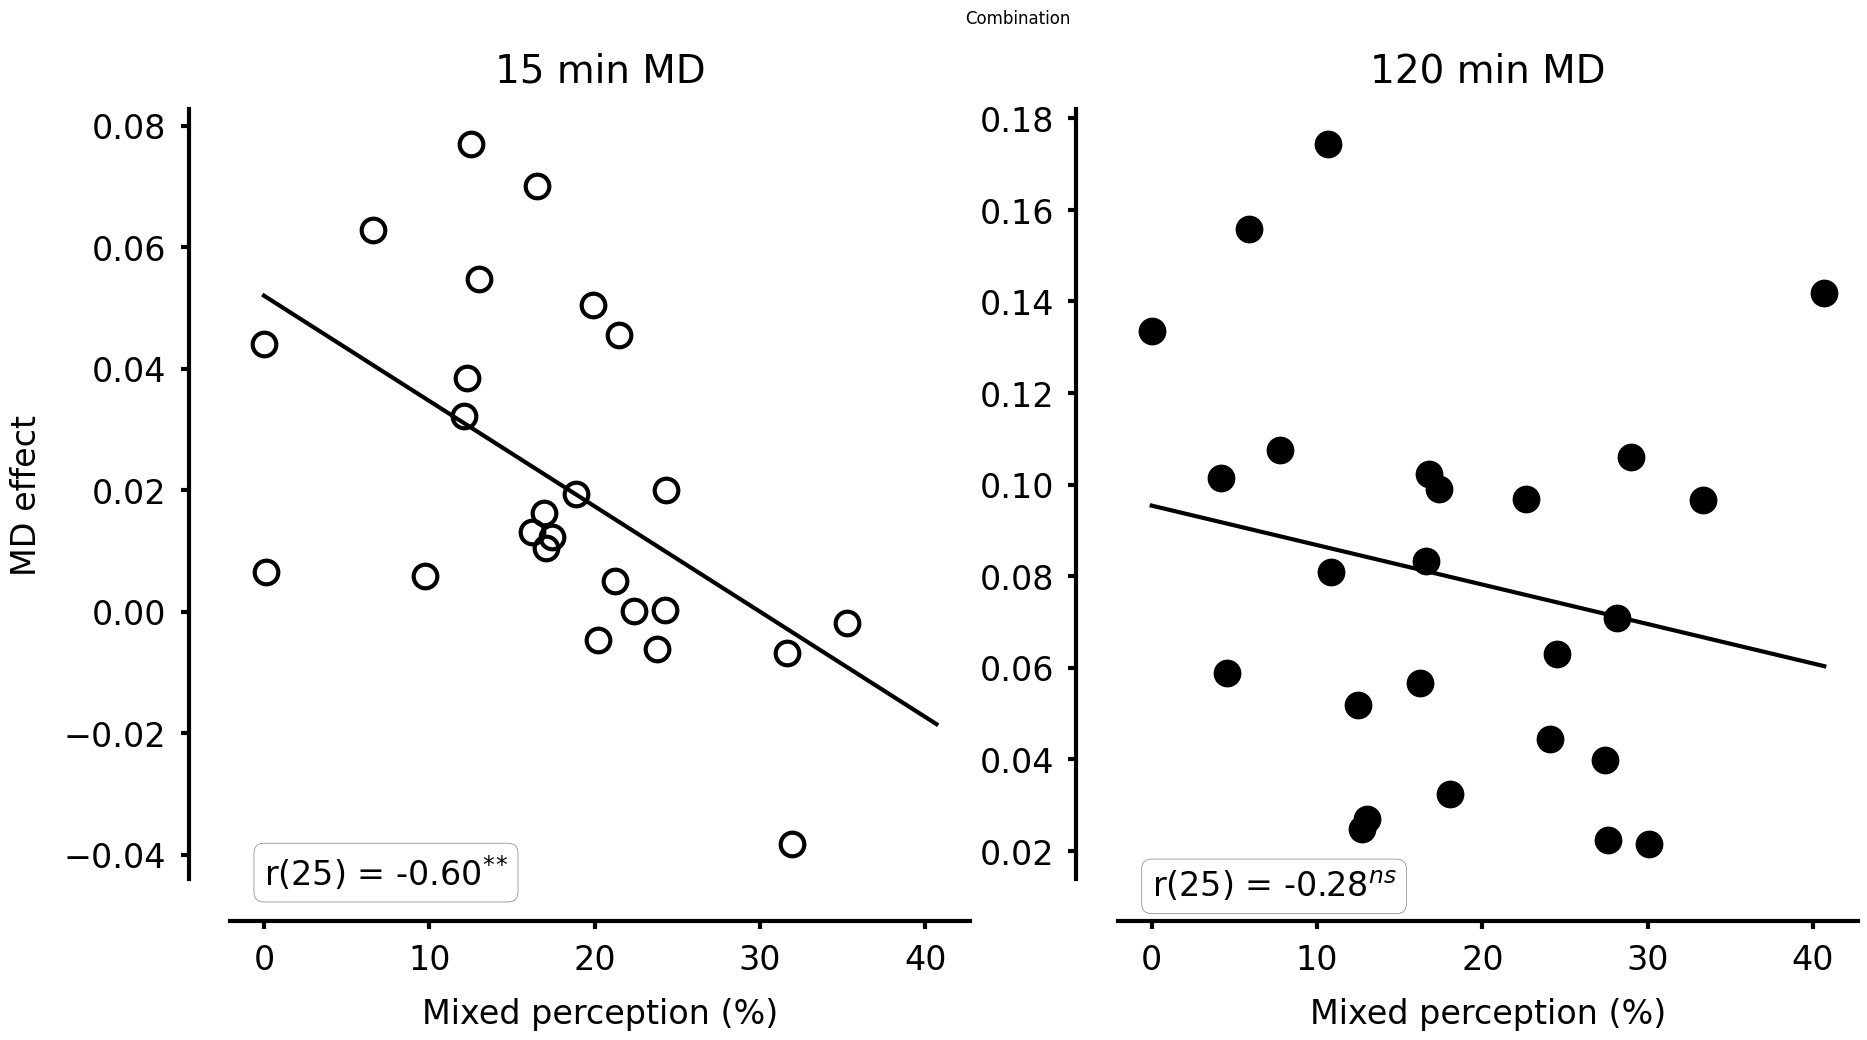

In [53]:
# Combination
fig, axes = plt.subplots(1,2,figsize=(21,10))
fig.suptitle('Combination')
ax_15, ax_120 = axes[0], axes[1]

ax_15.set_title("15 min MD", fontsize=28, pad=20), ax_120.set_title("120 min MD", fontsize=28, pad=20)
ax_15.set_ylabel("MD effect", fontsize=24, labelpad=15), 
ax_15.set_xlabel("Mixed perception (%)", fontsize=24, labelpad=15)
ax_120.set_xlabel("Mixed perception (%)", fontsize=24, labelpad=15)

for ax in axes:
    ax.spines[["top","right"]].set_visible(False)
    ax.spines[["bottom", "left"]].set_linewidth(3)
    ax.tick_params(length=6, width=3, pad=10, labelsize=24)
    ax.tick_params(which="minor", length = 4, width = 2)
    ax.spines[["left", "bottom"]].set_position(("outward", 30))

ax_15.plot(
    mixed_proportion["15min"]["baseline"]*100,
    arithmetic_mean_effect["15min"]["combination"],
    color = "k",
    marker="o",
    ms = 17,
    fillstyle="none",
    ls="",
    mew = 3
)

ax_120.plot(
    mixed_proportion["120min"]["baseline"]*100,
    arithmetic_mean_effect["120min"]["combination"],
    color = "k",
    marker="o",
    ms = 17,
    fillstyle="full",
    ls="",
    mew = 3
)

corr, p = spearmanr(mixed_proportion["15min"]["baseline"]*100, arithmetic_mean_effect["15min"]["combination"])
print(f"Correlation 15min: r={corr}, p={p}")
sig_level = anf.significance_level(p)
# ax_15.text(1.17, -0.045, f"r(25) = {corr:.2f}, p = {p:.6f}", fontsize=24, bbox={"boxstyle":"round","facecolor":"white","lw":.5,"edgecolor":"grey"})
ax_15.text(0, -0.045, f"r(25) = {corr:.2f}" + r"$^{*}$"*sig_level, fontsize=24, bbox={"boxstyle":"round","facecolor":"white","lw":.5,"edgecolor":"grey"})

# Linear fit
linear_regression = linregress(mixed_proportion["15min"]["baseline"]*100, arithmetic_mean_effect["15min"]["combination"])
regression_line_span = np.linspace(min(mixed_proportion["120min"]["baseline"]*100), max(mixed_proportion["120min"]["baseline"]*100))
ax_15.plot(
    regression_line_span,
    linear_regression.intercept + linear_regression.slope * regression_line_span,
    color = "k",
    lw=3
)

corr, p = spearmanr(mixed_proportion["120min"]["baseline"]*100, arithmetic_mean_effect["120min"]["combination"])
# ax_120.text(0, 0, f"r(25) = {corr:.2f}, p = {p:.6f}", fontsize=24, bbox={"boxstyle":"round","facecolor":"white","lw":.5,"edgecolor":"grey"})
ax_120.text(0, 0.01, f"r(25) = {corr:.2f}" + r"$^{ns}$", fontsize=24, bbox={"boxstyle":"round","facecolor":"white","lw":.5,"edgecolor":"grey"})
print(f"Correlation 120min: r={corr}, p={p}")
sig_level = anf.significance_level(p)
linear_regression = linregress(mixed_proportion["120min"]["baseline"]*100, arithmetic_mean_effect["120min"]["combination"])
regression_line_span = np.linspace(min(mixed_proportion["120min"]["baseline"]*100), max(mixed_proportion["120min"]["baseline"]*100))
ax_120.plot(
    regression_line_span,
    linear_regression.intercept + linear_regression.slope * regression_line_span,
    color = "k",
    lw=3
)

fig.savefig(os.path.join(images_dir, "correlation_mixed_percept_effects_bc_review.png"))

Correlation 15min: r=-0.18923076923076923, p=0.3649688316115858
Correlation 120min: r=0.057692307692307696, p=0.7841450370675709


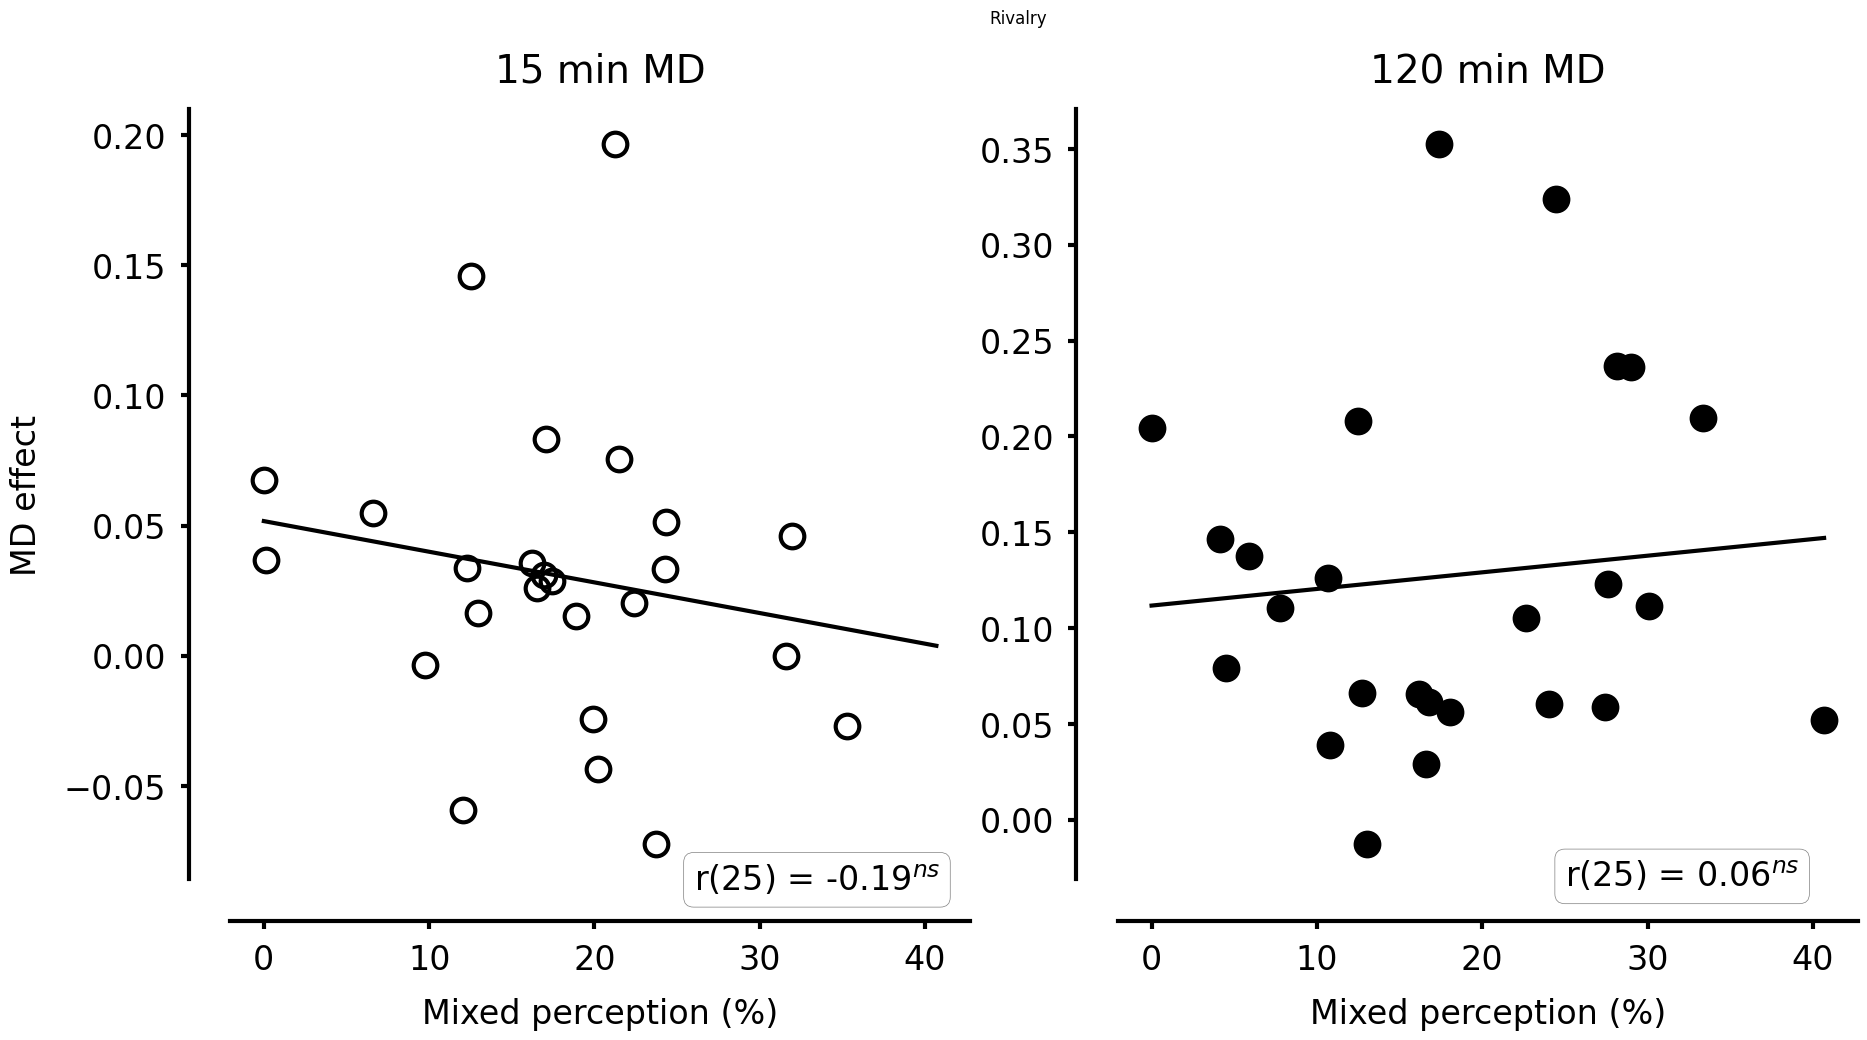

In [54]:
# Rivalry
fig, axes = plt.subplots(1,2,figsize=(21,10))
fig.suptitle("Rivalry")
ax_15, ax_120 = axes[0], axes[1]

ax_15.set_title("15 min MD", fontsize=28, pad=20), ax_120.set_title("120 min MD", fontsize=28, pad=20)
ax_15.set_ylabel("MD effect", fontsize=24, labelpad=15), 
ax_15.set_xlabel("Mixed perception (%)", fontsize=24, labelpad=15)
ax_120.set_xlabel("Mixed perception (%)", fontsize=24, labelpad=15)

for ax in axes:
    ax.spines[["top","right"]].set_visible(False)
    ax.spines[["bottom", "left"]].set_linewidth(3)
    ax.tick_params(length=6, width=3, pad=10, labelsize=24)
    ax.tick_params(which="minor", length = 4, width = 2)
    ax.spines[["left", "bottom"]].set_position(("outward", 30))

ax_15.plot(
    mixed_proportion["15min"]["baseline"]*100,
    arithmetic_mean_effect["15min"]["rivalry"],
    color = "k",
    marker="o",
    ms = 17,
    fillstyle="none",
    ls="",
    mew = 3
)

ax_120.plot(
    mixed_proportion["120min"]["baseline"]*100,
    arithmetic_mean_effect["120min"]["rivalry"],
    color = "k",
    marker="o",
    ms = 17,
    fillstyle="full",
    ls="",
    mew = 3
)

corr, p = spearmanr(mixed_proportion["15min"]["baseline"]*100, arithmetic_mean_effect["15min"]["rivalry"])
print(f"Correlation 15min: r={corr}, p={p}")
sig_level = anf.significance_level(p)
# ax_15.text(1.17, -0.045, f"r(25) = {corr:.2f}, p = {p:.6f}", fontsize=24, bbox={"boxstyle":"round","facecolor":"white","lw":.5,"edgecolor":"grey"})
ax_15.text(26, -0.09, f"r(25) = {corr:.2f}" + r"$^{ns}$", fontsize=24, bbox={"boxstyle":"round","facecolor":"white","lw":.5,"edgecolor":"grey"})

# Linear fit
linear_regression = linregress(mixed_proportion["15min"]["baseline"]*100, arithmetic_mean_effect["15min"]["rivalry"])
regression_line_span = np.linspace(min(mixed_proportion["120min"]["baseline"]*100), max(mixed_proportion["120min"]["baseline"]*100))
ax_15.plot(
    regression_line_span,
    linear_regression.intercept + linear_regression.slope * regression_line_span,
    color = "k",
    lw=3
)

corr, p = spearmanr(mixed_proportion["120min"]["baseline"]*100, arithmetic_mean_effect["120min"]["rivalry"])
print(f"Correlation 120min: r={corr}, p={p}")
sig_level = anf.significance_level(p)
# ax_120.text(20, 0, f"r(25) = {corr:.2f}, p = {p:.6f}", fontsize=24, bbox={"boxstyle":"round","facecolor":"white","lw":.5,"edgecolor":"grey"})
ax_120.text(25, -0.035, f"r(25) = {corr:.2f}" + r"$^{ns}$", fontsize=24, bbox={"boxstyle":"round","facecolor":"white","lw":.5,"edgecolor":"grey"})
linear_regression = linregress(mixed_proportion["120min"]["baseline"]*100, arithmetic_mean_effect["120min"]["rivalry"])
regression_line_span = np.linspace(min(mixed_proportion["120min"]["baseline"]*100), max(mixed_proportion["120min"]["baseline"]*100))
ax_120.plot(
    regression_line_span,
    linear_regression.intercept + linear_regression.slope * regression_line_span,
    color = "k",
    lw=3
)

fig.savefig(os.path.join(images_dir, "correlation_mixed_percept_effects_br_review.png"))

Correlation 15min: r=-0.4915384615384616, p=0.012579821788806884
Correlation 120min: r=-0.05153846153846154, p=0.8067183623480412


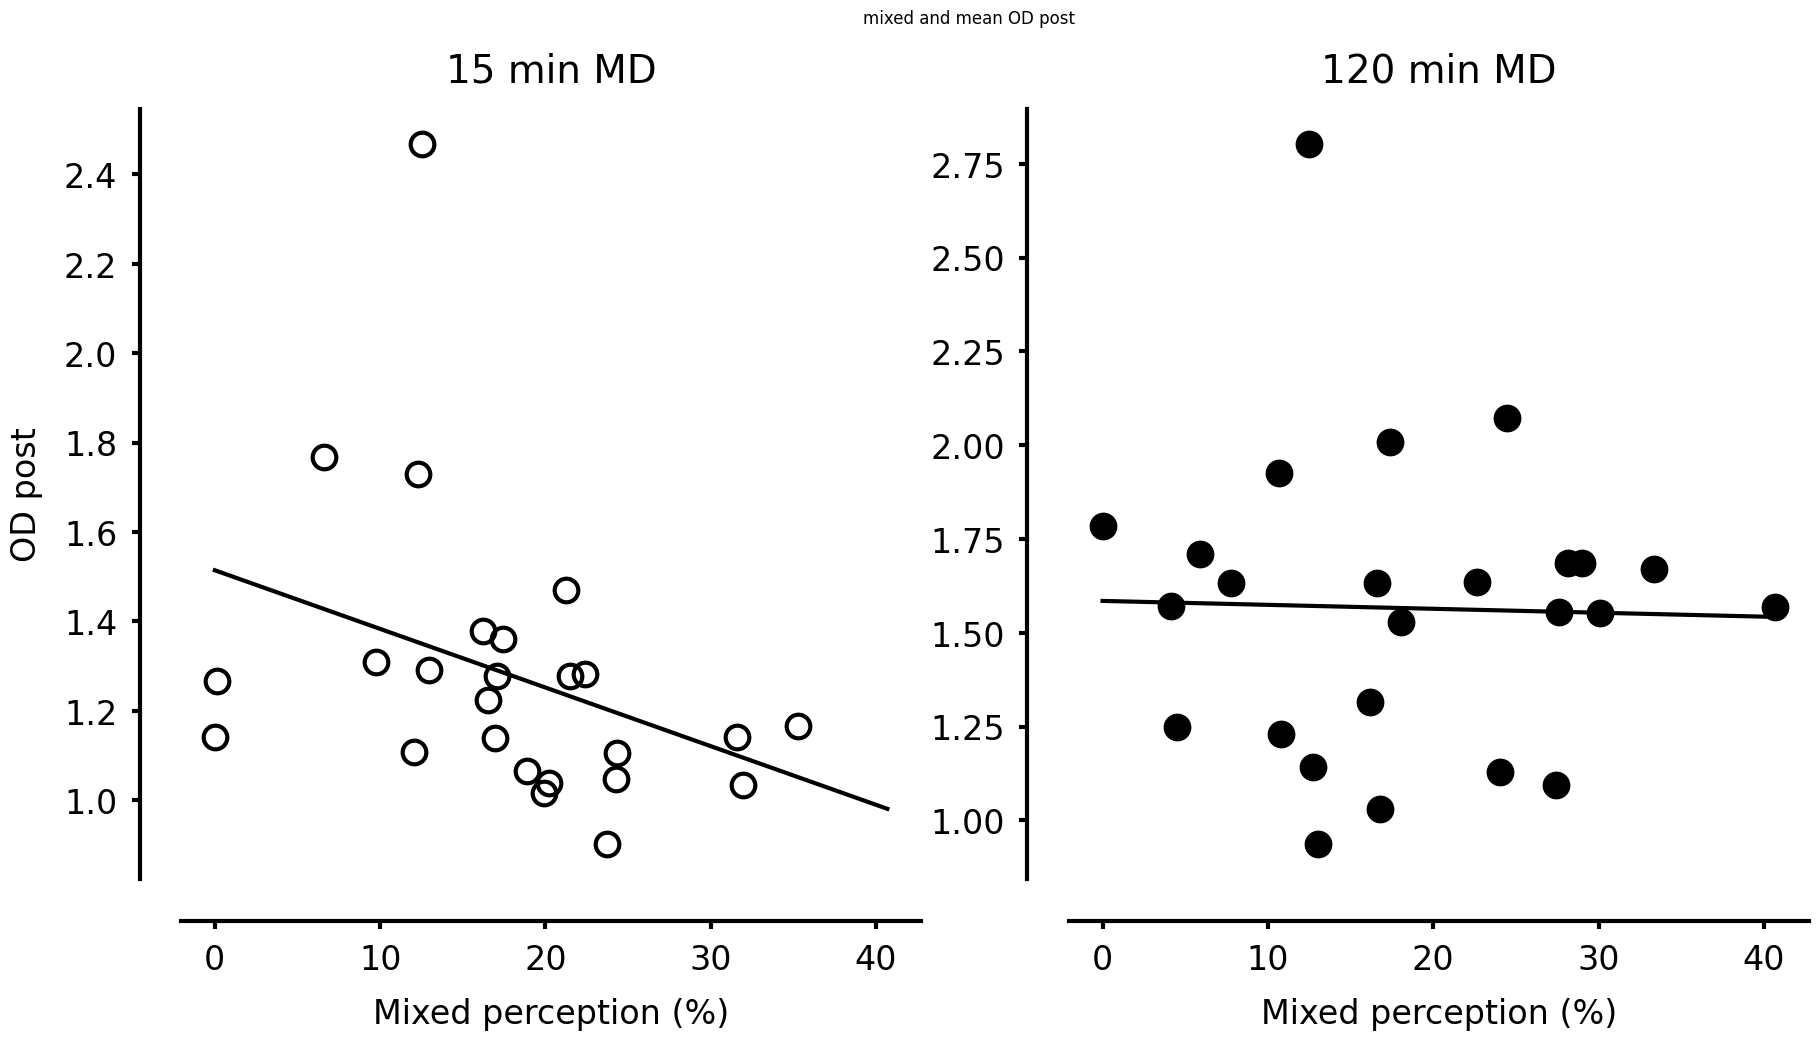

In [63]:
# Rivalry
fig, axes = plt.subplots(1,2,figsize=(21,10))
fig.suptitle('mixed and mean OD post')
ax_15, ax_120 = axes[0], axes[1]

ax_15.set_title("15 min MD", fontsize=28, pad=20), ax_120.set_title("120 min MD", fontsize=28, pad=20)
ax_15.set_ylabel("OD post", fontsize=24, labelpad=15), 
ax_15.set_xlabel("Mixed perception (%)", fontsize=24, labelpad=15)
ax_120.set_xlabel("Mixed perception (%)", fontsize=24, labelpad=15)

for ax in axes:
    ax.spines[["top","right"]].set_visible(False)
    ax.spines[["bottom", "left"]].set_linewidth(3)
    ax.tick_params(length=6, width=3, pad=10, labelsize=24)
    ax.tick_params(which="minor", length = 4, width = 2)
    ax.spines[["left", "bottom"]].set_position(("outward", 30))

ax_15.plot(
    mixed_proportion["15min"]["baseline"]*100,
    vertical_raw_df["15min"]["rivalry"].drop("baseline_15min", axis=1).mean(axis=1),
    color = "k",
    marker="o",
    ms = 17,
    fillstyle="none",
    ls="",
    mew = 3
)

ax_120.plot(
    mixed_proportion["120min"]["baseline"]*100,
    vertical_raw_df["120min"]["rivalry"].drop("baseline_120min", axis=1).mean(axis=1),
    color = "k",
    marker="o",
    ms = 17,
    fillstyle="full",
    ls="",
    mew = 3
)

corr, p = spearmanr(mixed_proportion["15min"]["baseline"]*100, vertical_raw_df["15min"]["rivalry"].drop("baseline_15min", axis=1).mean(axis=1))
print(f"Correlation 15min: r={corr}, p={p}")
sig_level = anf.significance_level(p)
# ax_15.text(, -0.045, f"r(25) = {corr:.2f}, p = {p:.6f}", fontsize=24, bbox={"boxstyle":"round","facecolor":"white","lw":.5,"edgecolor":"grey"})
# ax_15.text(26, -0.09, f"r(25) = {corr:.2f}" + r"$^{ns}$", fontsize=24, bbox={"boxstyle":"round","facecolor":"white","lw":.5,"edgecolor":"grey"})

# Linear fit
linear_regression = linregress(mixed_proportion["15min"]["baseline"]*100, vertical_raw_df["15min"]["rivalry"].drop("baseline_15min", axis=1).mean(axis=1))
regression_line_span = np.linspace(min(mixed_proportion["120min"]["baseline"]*100), max(mixed_proportion["120min"]["baseline"]*100))
ax_15.plot(
    regression_line_span,
    linear_regression.intercept + linear_regression.slope * regression_line_span,
    color = "k",
    lw=3
)

corr, p = spearmanr(mixed_proportion["120min"]["baseline"]*100, vertical_raw_df["120min"]["rivalry"].drop("baseline_120min", axis=1).mean(axis=1))
print(f"Correlation 120min: r={corr}, p={p}")
sig_level = anf.significance_level(p)
# ax_120.text(20, 0, f"r(25) = {corr:.2f}, p = {p:.6f}", fontsize=24, bbox={"boxstyle":"round","facecolor":"white","lw":.5,"edgecolor":"grey"})
# ax_120.text(25, -0.035, f"r(25) = {corr:.2f}" + r"$^{ns}$", fontsize=24, bbox={"boxstyle":"round","facecolor":"white","lw":.5,"edgecolor":"grey"})
linear_regression = linregress(mixed_proportion["120min"]["baseline"]*100, vertical_raw_df["120min"]["rivalry"].drop("baseline_120min", axis=1).mean(axis=1))
regression_line_span = np.linspace(min(mixed_proportion["120min"]["baseline"]*100), max(mixed_proportion["120min"]["baseline"]*100))
ax_120.plot(
    regression_line_span,
    linear_regression.intercept + linear_regression.slope * regression_line_span,
    color = "k",
    lw=3
)

fig.savefig(os.path.join(images_dir, "correlation_mixed_percept_od_post_br_review.png"))

Correlation 15min: r=-0.6115384615384616, p=0.0011618366565919222
Correlation 120min: r=-0.25230769230769234, p=0.2236964419557054


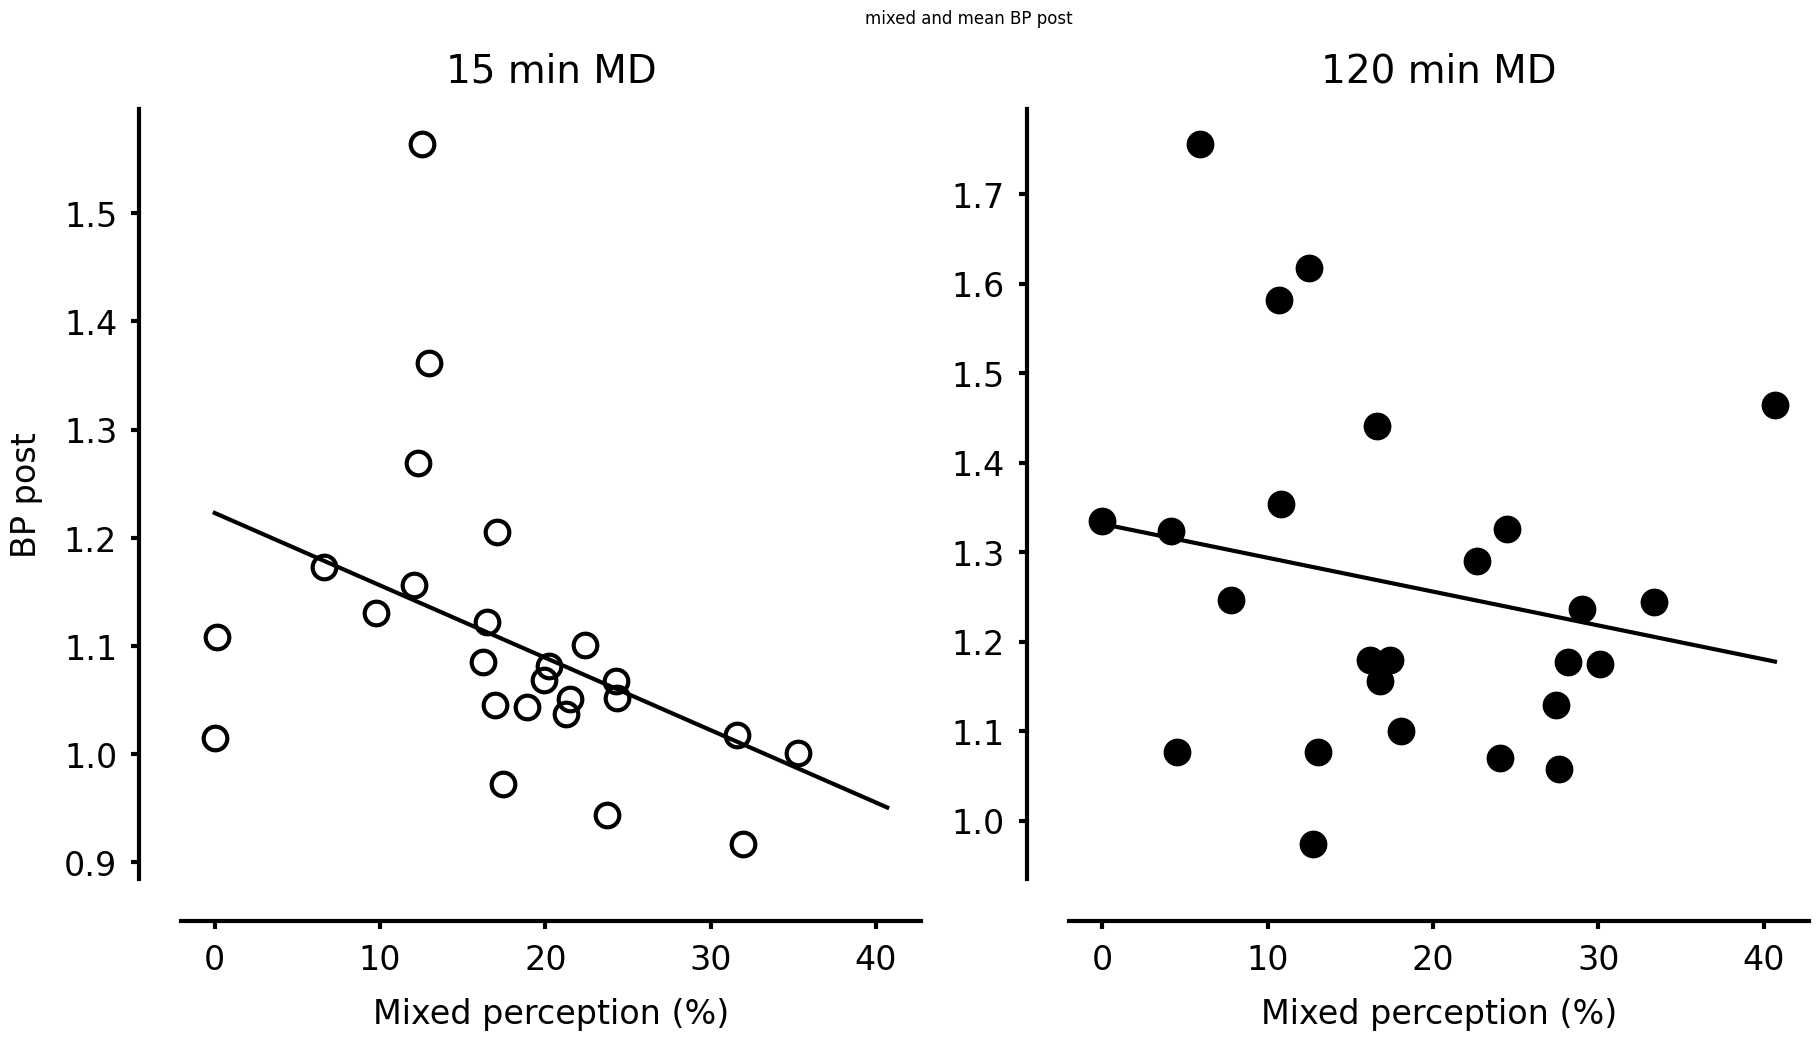

In [65]:
# combination
fig, axes = plt.subplots(1,2,figsize=(21,10))
fig.suptitle('mixed and mean BP post')
ax_15, ax_120 = axes[0], axes[1]

ax_15.set_title("15 min MD", fontsize=28, pad=20), ax_120.set_title("120 min MD", fontsize=28, pad=20)
ax_15.set_ylabel("BP post", fontsize=24, labelpad=15), 
ax_15.set_xlabel("Mixed perception (%)", fontsize=24, labelpad=15)
ax_120.set_xlabel("Mixed perception (%)", fontsize=24, labelpad=15)

for ax in axes:
    ax.spines[["top","right"]].set_visible(False)
    ax.spines[["bottom", "left"]].set_linewidth(3)
    ax.tick_params(length=6, width=3, pad=10, labelsize=24)
    ax.tick_params(which="minor", length = 4, width = 2)
    ax.spines[["left", "bottom"]].set_position(("outward", 30))

ax_15.plot(
    mixed_proportion["15min"]["baseline"]*100,
    vertical_raw_df["15min"]["combination"].drop("baseline_15min", axis=1).mean(axis=1),
    color = "k",
    marker="o",
    ms = 17,
    fillstyle="none",
    ls="",
    mew = 3
)

ax_120.plot(
    mixed_proportion["120min"]["baseline"]*100,
    vertical_raw_df["120min"]["combination"].drop("baseline_120min", axis=1).mean(axis=1),
    color = "k",
    marker="o",
    ms = 17,
    fillstyle="full",
    ls="",
    mew = 3
)

corr, p = spearmanr(mixed_proportion["15min"]["baseline"]*100, vertical_raw_df["15min"]["combination"].drop("baseline_15min", axis=1).mean(axis=1))
print(f"Correlation 15min: r={corr}, p={p}")
sig_level = anf.significance_level(p)
# ax_15.text(, -0.045, f"r(25) = {corr:.2f}, p = {p:.6f}", fontsize=24, bbox={"boxstyle":"round","facecolor":"white","lw":.5,"edgecolor":"grey"})
# ax_15.text(26, -0.09, f"r(25) = {corr:.2f}" + r"$^{ns}$", fontsize=24, bbox={"boxstyle":"round","facecolor":"white","lw":.5,"edgecolor":"grey"})

# Linear fit
linear_regression = linregress(mixed_proportion["15min"]["baseline"]*100, vertical_raw_df["15min"]["combination"].drop("baseline_15min", axis=1).mean(axis=1))
regression_line_span = np.linspace(min(mixed_proportion["120min"]["baseline"]*100), max(mixed_proportion["120min"]["baseline"]*100))
ax_15.plot(
    regression_line_span,
    linear_regression.intercept + linear_regression.slope * regression_line_span,
    color = "k",
    lw=3
)

corr, p = spearmanr(mixed_proportion["120min"]["baseline"]*100, vertical_raw_df["120min"]["combination"].drop("baseline_120min", axis=1).mean(axis=1))
print(f"Correlation 120min: r={corr}, p={p}")
sig_level = anf.significance_level(p)
# ax_120.text(20, 0, f"r(25) = {corr:.2f}, p = {p:.6f}", fontsize=24, bbox={"boxstyle":"round","facecolor":"white","lw":.5,"edgecolor":"grey"})
# ax_120.text(25, -0.035, f"r(25) = {corr:.2f}" + r"$^{ns}$", fontsize=24, bbox={"boxstyle":"round","facecolor":"white","lw":.5,"edgecolor":"grey"})
linear_regression = linregress(mixed_proportion["120min"]["baseline"]*100, vertical_raw_df["120min"]["combination"].drop("baseline_120min", axis=1).mean(axis=1))
regression_line_span = np.linspace(min(mixed_proportion["120min"]["baseline"]*100), max(mixed_proportion["120min"]["baseline"]*100))
ax_120.plot(
    regression_line_span,
    linear_regression.intercept + linear_regression.slope * regression_line_span,
    color = "k",
    lw=3
)

fig.savefig(os.path.join(images_dir, "correlation_mixed_percept_od_post_bc_review.png"))

Correlation 15min: r=-0.36923076923076925, p=0.06930331713211782
Correlation 120min: r=0.2346153846153846, p=0.25895460076089083


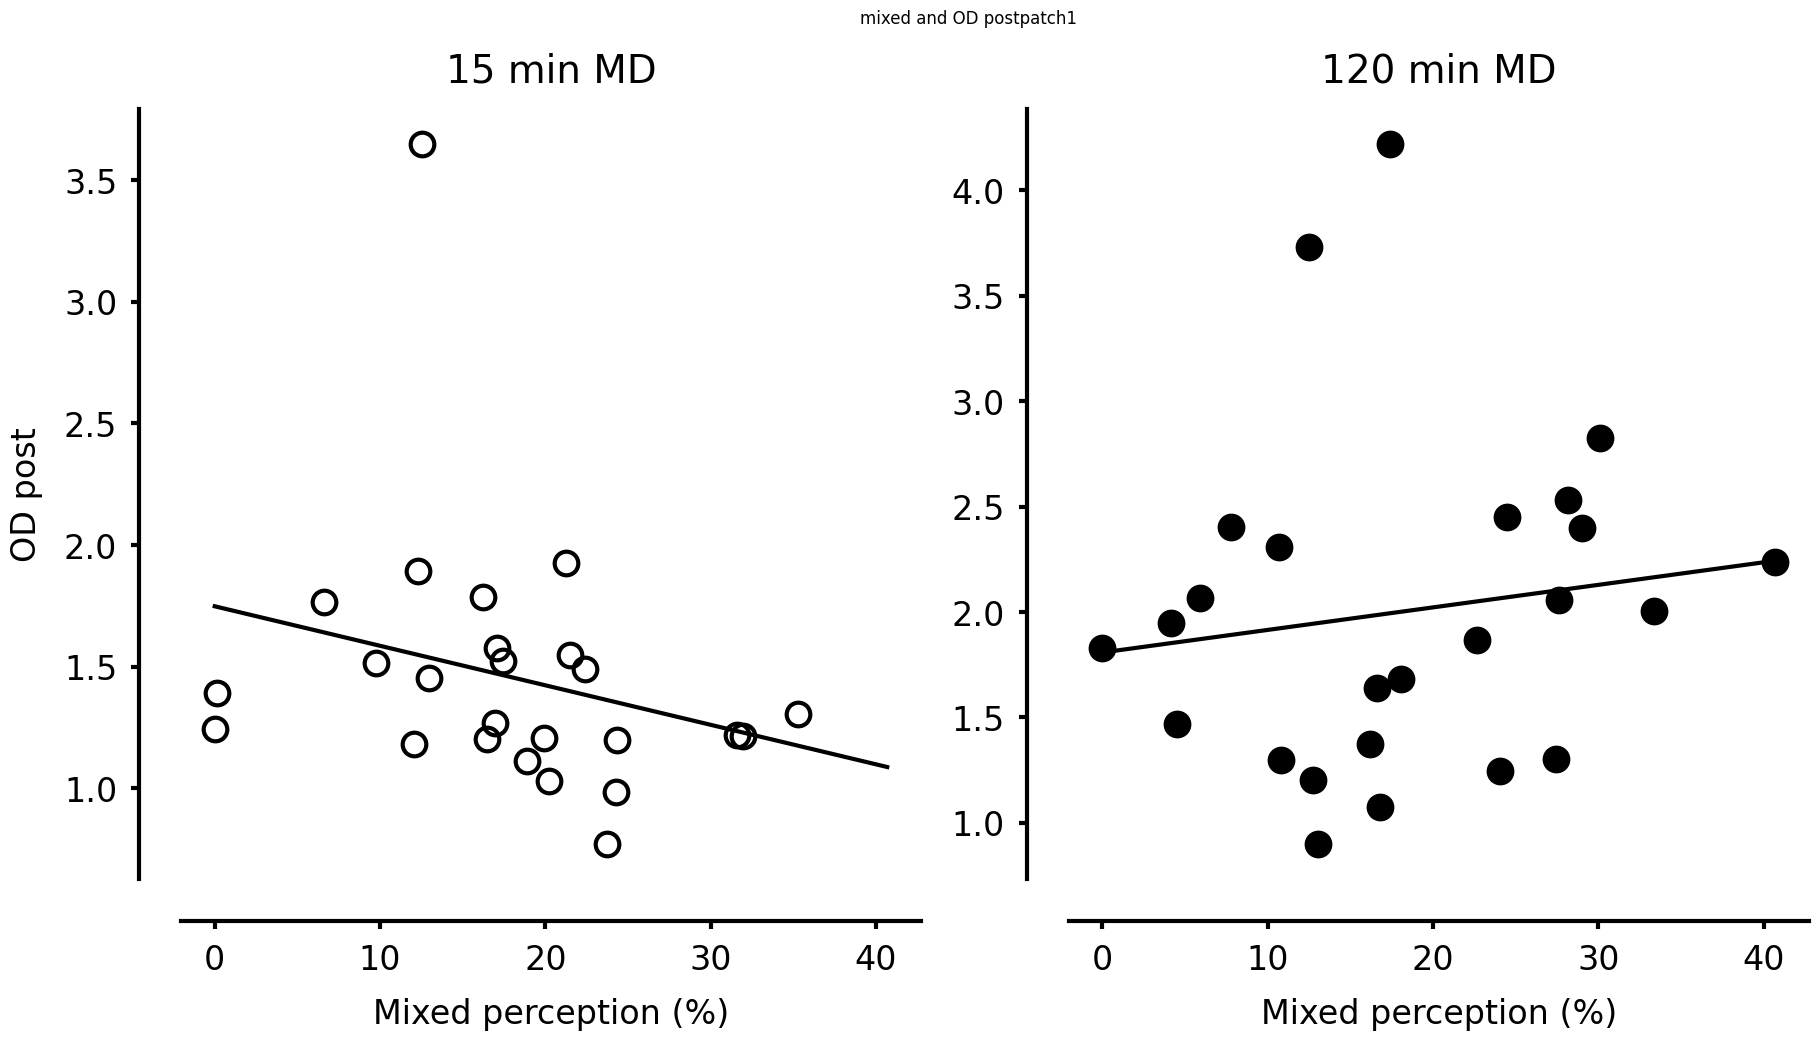

In [61]:
# Rivalry
fig, axes = plt.subplots(1,2,figsize=(21,10))
fig.suptitle('mixed and OD postpatch1')
ax_15, ax_120 = axes[0], axes[1]

ax_15.set_title("15 min MD", fontsize=28, pad=20), ax_120.set_title("120 min MD", fontsize=28, pad=20)
ax_15.set_ylabel("OD post", fontsize=24, labelpad=15), 
ax_15.set_xlabel("Mixed perception (%)", fontsize=24, labelpad=15)
ax_120.set_xlabel("Mixed perception (%)", fontsize=24, labelpad=15)

for ax in axes:
    ax.spines[["top","right"]].set_visible(False)
    ax.spines[["bottom", "left"]].set_linewidth(3)
    ax.tick_params(length=6, width=3, pad=10, labelsize=24)
    ax.tick_params(which="minor", length = 4, width = 2)
    ax.spines[["left", "bottom"]].set_position(("outward", 30))

ax_15.plot(
    mixed_proportion["15min"]["baseline"]*100,
    vertical_raw_df["15min"]["rivalry"]["postpatch1_15min"],
    color = "k",
    marker="o",
    ms = 17,
    fillstyle="none",
    ls="",
    mew = 3
)

ax_120.plot(
    mixed_proportion["120min"]["baseline"]*100,
    vertical_raw_df["120min"]["rivalry"]["postpatch1_120min"],
    color = "k",
    marker="o",
    ms = 17,
    fillstyle="full",
    ls="",
    mew = 3
)

corr, p = spearmanr(mixed_proportion["15min"]["baseline"]*100, vertical_raw_df["15min"]["rivalry"]["postpatch1_15min"])
print(f"Correlation 15min: r={corr}, p={p}")
sig_level = anf.significance_level(p)
# ax_15.text(1.17, -0.045, f"r(25) = {corr:.2f}, p = {p:.6f}", fontsize=24, bbox={"boxstyle":"round","facecolor":"white","lw":.5,"edgecolor":"grey"})
# ax_15.text(26, -0.09, f"r(25) = {corr:.2f}" + r"$^{ns}$", fontsize=24, bbox={"boxstyle":"round","facecolor":"white","lw":.5,"edgecolor":"grey"})

# Linear fit
linear_regression = linregress(mixed_proportion["15min"]["baseline"]*100, vertical_raw_df["15min"]["rivalry"]["postpatch1_15min"])
regression_line_span = np.linspace(min(mixed_proportion["120min"]["baseline"]*100), max(mixed_proportion["120min"]["baseline"]*100))
ax_15.plot(
    regression_line_span,
    linear_regression.intercept + linear_regression.slope * regression_line_span,
    color = "k",
    lw=3
)

corr, p = spearmanr(mixed_proportion["120min"]["baseline"]*100, vertical_raw_df["120min"]["rivalry"]["postpatch1_120min"])
print(f"Correlation 120min: r={corr}, p={p}")
sig_level = anf.significance_level(p)
# ax_120.text(20, 0, f"r(25) = {corr:.2f}, p = {p:.6f}", fontsize=24, bbox={"boxstyle":"round","facecolor":"white","lw":.5,"edgecolor":"grey"})
# ax_120.text(25, -0.035, f"r(25) = {corr:.2f}" + r"$^{ns}$", fontsize=24, bbox={"boxstyle":"round","facecolor":"white","lw":.5,"edgecolor":"grey"})
linear_regression = linregress(mixed_proportion["120min"]["baseline"]*100, vertical_raw_df["120min"]["rivalry"]["postpatch1_120min"])
regression_line_span = np.linspace(min(mixed_proportion["120min"]["baseline"]*100), max(mixed_proportion["120min"]["baseline"]*100))
ax_120.plot(
    regression_line_span,
    linear_regression.intercept + linear_regression.slope * regression_line_span,
    color = "k",
    lw=3
)

fig.savefig(os.path.join(images_dir, "correlation_mixed_percept_od_post1_br_review.png"))

Correlation 15min: r=-0.5107692307692308, p=0.009078735844871143
Correlation 120min: r=-0.2884615384615385, p=0.16199254927892695


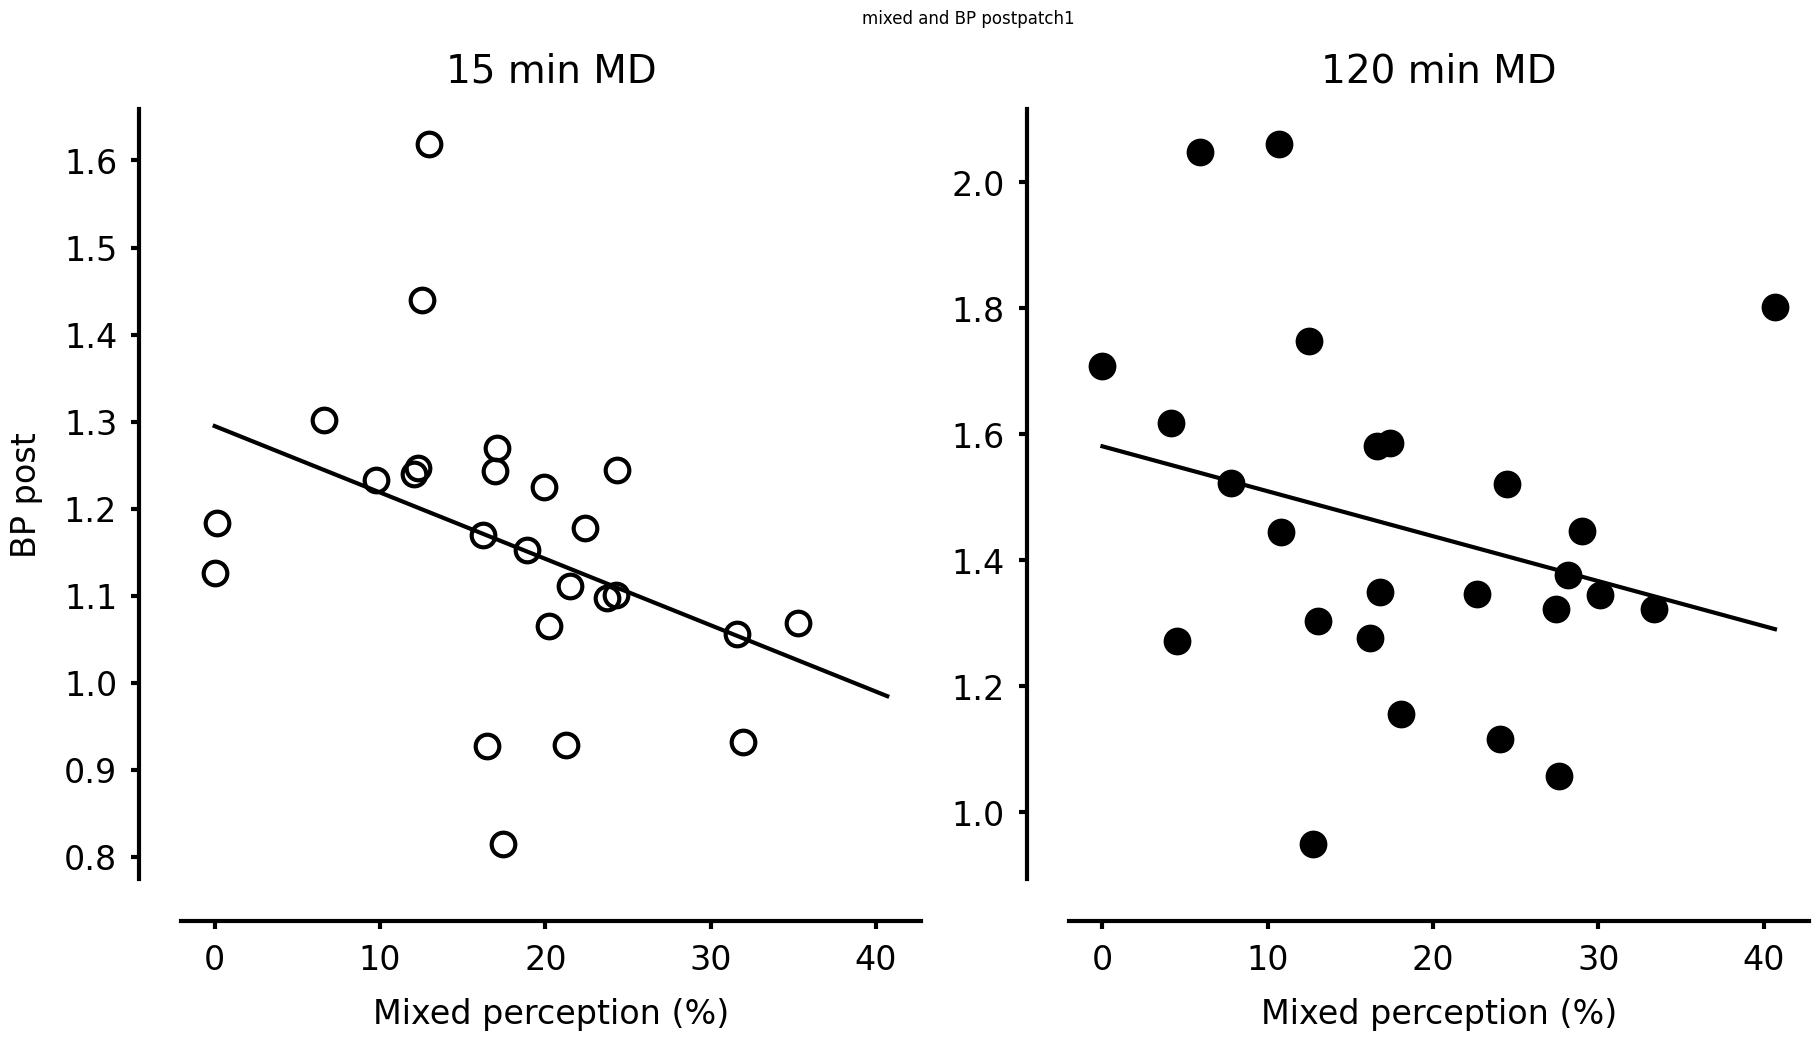

In [62]:
# combination
fig, axes = plt.subplots(1,2,figsize=(21,10))
fig.suptitle('mixed and BP postpatch1')
ax_15, ax_120 = axes[0], axes[1]

ax_15.set_title("15 min MD", fontsize=28, pad=20), ax_120.set_title("120 min MD", fontsize=28, pad=20)
ax_15.set_ylabel("BP post", fontsize=24, labelpad=15), 
ax_15.set_xlabel("Mixed perception (%)", fontsize=24, labelpad=15)
ax_120.set_xlabel("Mixed perception (%)", fontsize=24, labelpad=15)

for ax in axes:
    ax.spines[["top","right"]].set_visible(False)
    ax.spines[["bottom", "left"]].set_linewidth(3)
    ax.tick_params(length=6, width=3, pad=10, labelsize=24)
    ax.tick_params(which="minor", length = 4, width = 2)
    ax.spines[["left", "bottom"]].set_position(("outward", 30))

ax_15.plot(
    mixed_proportion["15min"]["baseline"]*100,
    vertical_raw_df["15min"]["combination"]["postpatch1_15min"],
    color = "k",
    marker="o",
    ms = 17,
    fillstyle="none",
    ls="",
    mew = 3
)

ax_120.plot(
    mixed_proportion["120min"]["baseline"]*100,
    vertical_raw_df["120min"]["combination"]["postpatch1_120min"],
    color = "k",
    marker="o",
    ms = 17,
    fillstyle="full",
    ls="",
    mew = 3
)

corr, p = spearmanr(mixed_proportion["15min"]["baseline"]*100, vertical_raw_df["15min"]["combination"]["postpatch1_15min"])
print(f"Correlation 15min: r={corr}, p={p}")
sig_level = anf.significance_level(p)
# ax_15.text(1.17, -0.045, f"r(25) = {corr:.2f}, p = {p:.6f}", fontsize=24, bbox={"boxstyle":"round","facecolor":"white","lw":.5,"edgecolor":"grey"})
# ax_15.text(26, -0.09, f"r(25) = {corr:.2f}" + r"$^{ns}$", fontsize=24, bbox={"boxstyle":"round","facecolor":"white","lw":.5,"edgecolor":"grey"})

# Linear fit
linear_regression = linregress(mixed_proportion["15min"]["baseline"]*100, vertical_raw_df["15min"]["combination"]["postpatch1_15min"])
regression_line_span = np.linspace(min(mixed_proportion["120min"]["baseline"]*100), max(mixed_proportion["120min"]["baseline"]*100))
ax_15.plot(
    regression_line_span,
    linear_regression.intercept + linear_regression.slope * regression_line_span,
    color = "k",
    lw=3
)

corr, p = spearmanr(mixed_proportion["120min"]["baseline"]*100, vertical_raw_df["120min"]["combination"]["postpatch1_120min"])
print(f"Correlation 120min: r={corr}, p={p}")
sig_level = anf.significance_level(p)
# ax_120.text(20, 0, f"r(25) = {corr:.2f}, p = {p:.6f}", fontsize=24, bbox={"boxstyle":"round","facecolor":"white","lw":.5,"edgecolor":"grey"})
# ax_120.text(25, -0.035, f"r(25) = {corr:.2f}" + r"$^{ns}$", fontsize=24, bbox={"boxstyle":"round","facecolor":"white","lw":.5,"edgecolor":"grey"})
linear_regression = linregress(mixed_proportion["120min"]["baseline"]*100, vertical_raw_df["120min"]["combination"]["postpatch1_120min"])
regression_line_span = np.linspace(min(mixed_proportion["120min"]["baseline"]*100), max(mixed_proportion["120min"]["baseline"]*100))
ax_120.plot(
    regression_line_span,
    linear_regression.intercept + linear_regression.slope * regression_line_span,
    color = "k",
    lw=3
)

fig.savefig(os.path.join(images_dir, "correlation_mixed_percept_od_post1_br_review.png"))